# Preprocessing

In [ ]:
import json
import glob 

keypoints=[]
for i in glob.glob('output_jsons_all/*'):
  # print(i)
  with open(i) as json_file:
    data = json.load(json_file)
    if (data['people']):
      keypoints.append(data['people'][0]['pose_keypoints_2d'])


In [157]:
import json
import glob 

keypoints={}
cm=0
for c,i in enumerate(glob.glob('openpose/openpifpaf_jsons/*')):
  # print(i)
  if(c%10000)==0:
        print(c,cm)
  with open(i) as json_file:
    data = json.load(json_file)
#     print(data)
#     break
    if(len(data)>1):
        cm+=1
    if (data and data[0]['keypoints']):
      keypoints[i]=data[0]['keypoints']
print(cm)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000


In [160]:
print(keypoints['openpose/openpifpaf_jsons\\video_0001_00000_pedestrian1.png.predictions.json'])

[529.87, 743.33, 0.34, 0.0, -4.0, 0.0, 528.22, 740.1, 0.41, 0.0, -4.0, 0.0, 519.92, 741.37, 0.49, 503.99, 746.5, 0.44, 508.09, 753.25, 0.61, 0.0, -4.0, 0.0, 519.1, 789.46, 0.5, 0.0, -4.0, 0.0, 528.35, 803.45, 0.29, 471.17, 772.4, 0.55, 477.27, 776.04, 0.72, 476.98, 811.32, 0.32, 488.21, 810.19, 0.57, 474.31, 837.33, 0.11, 487.75, 841.68, 0.45]


In [159]:
# print(keypoints[0])w  w
import pickle
pickle.dump(keypoints,open('./keypoints_openpifpaf.pickle','wb'))

In [ ]:
pickle.dump(thresarr,open('./keypoints_thres.pickle','wb'))

In [ ]:
print(len(keypoints))

In [ ]:
import numpy as np
kpa=np.array(keypoints)
thresarr=[]
for i in range(kpa.shape[0]):
  vec=kpa[i,1][2::3]
  if (vec > 0.25).all():
    thresarr.append(kpa[i])

print(len(thresarr))

In [ ]:
import numpy as np

thresarr=[]
for i in range(len(temp)):
  vec=temp[i][3][2::3]
  if (vec > 0.2).all():
    thresarr.append(temp[i][3])

print(len(thresarr))

# Old Testing

In [ ]:
!python train.py

In [ ]:
!python test.py

In [43]:
import torch

from imageio import imread, imsave
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt

import numpy as np
from path import Path
import argparse
from tqdm import tqdm

from models import DispResNet
from utils import tensor2array

# parser = argparse.ArgumentParser(description='Inference script for DispNet learned with \
#                                  Structure from Motion Learner inference on KITTI Dataset',
#                                  formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# parser.add_argument("--output-disp", action='store_true', help="save disparity img")
# parser.add_argument("--output-depth", action='store_true', help="save depth img")
# parser.add_argument("--pretrained", required=True, type=str, help="pretrained DispResNet path")
# parser.add_argument("--img-height", default=256, type=int, help="Image height")
# parser.add_argument("--img-width", default=832, type=int, help="Image width")
# parser.add_argument("--no-resize", action='store_true', help="no resizing is done")

# parser.add_argument("--dataset-list", default=None, type=str, help="Dataset list file")
# parser.add_argument("--dataset-dir", default='.', type=str, help="Dataset directory")
# parser.add_argument("--output-dir", default='output', type=str, help="Output directory")
# parser.add_argument("--img-exts", default=['png', 'jpg', 'bmp'], nargs='*', type=str, help="images extensions to glob")
# parser.add_argument('--resnet-layers', required=True, type=int, default=18, choices=[18, 50],
#                     help='depth network architecture.')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
img_height=256
img_width=832
img_exts=['png', 'jpg', 'bmp']
dataset_dir='image'
resnet_layers=18
output_dir='results/'
pretrained='checkpoints/resnet18_depth_256/dispnet_model_best.pth.tar'

with torch.no_grad():

    # args = parser.parse_args()
    # if not(args.output_disp or args.output_depth):
    #     print('You must at least output one value !')
    #     return

    disp_net = DispResNet(resnet_layers, False).to(device)
    weights = torch.load(pretrained)
    disp_net.load_state_dict(weights['state_dict'])
    disp_net.eval()

    dataset_dir = Path(dataset_dir)
    output_dir = Path(output_dir)
    output_dir.makedirs_p()

    test_files = sum([dataset_dir.files('*.{}'.format(ext)) for ext in img_exts], [])

    print('{} files to test'.format(len(test_files)))

    for file in tqdm(test_files):

        img = imread(file).astype(np.float32)

        h, w, _ = img.shape
       
        img = imresize(img, (img_height, img_width)).astype(np.float32)
        
        fig = plt.figure(figsize=(15, 15))
        a = fig.add_subplot(1, 3, 1)
        imgplot = plt.imshow(img.astype(np.uint8))

        img = np.transpose(img, (2, 0, 1))

        tensor_img = torch.from_numpy(img).unsqueeze(0)
        tensor_img = ((tensor_img/255 - 0.45)/0.225).to(device)

        output = disp_net(tensor_img)[0]

        file_path, file_ext = file.relpath(dataset_dir).splitext()
        file_name = '-'.join(file_path.splitall())

        disp = (255*tensor2array(output, max_value=None, colormap='bone')).astype(np.uint8)

        
        depth = 1/output
        depth = (255*tensor2array(depth, max_value=1, colormap='magma')).astype(np.uint8)

        
        
        a = fig.add_subplot(1, 3, 2)
        imgplot = plt.imshow(np.transpose(disp,(1,2,0)))
        a = fig.add_subplot(1, 3, 3)
        imgplot = plt.imshow(np.transpose(depth,(1,2,0)))

      
     
        imsave(output_dir/'{}_disp{}'.format(file_name, file_ext), np.transpose(disp, (1, 2, 0)))
        imsave(output_dir/'{}_depth{}'.format(file_name, file_ext), np.transpose(depth, (1, 2, 0)))
       



ModuleNotFoundError: No module named 'path'

In [ ]:
from inverse_warp import pose_vec2mat
from scipy.ndimage.interpolation import zoom
from inverse_warp import *
import models

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
sequence='test'
pretrained_posenet='./checkpoints/resnet50_pose_256/exp_pose_model_best.pth.tar'
def load_tensor_image(filename):
    img = imread(filename).astype(np.float32)
    h, w, _ = img.shape
    # if (not args.no_resize) and (h != img_height or w != img_width):
    img = imresize(img, (img_height, img_width)).astype(np.float32)
    img = np.transpose(img, (2, 0, 1))
    tensor_img = ((torch.from_numpy(img).unsqueeze(0)/255-0.45)/0.225).to(device)
    return tensor_img


with torch.no_grad():

    weights_pose = torch.load(pretrained_posenet)
    pose_net = models.PoseResNet().to(device)
    pose_net.load_state_dict(weights_pose['state_dict'], strict=False)
    pose_net.eval()

    image_dir = Path(dataset_dir)
    output_dir = Path('./')
    output_dir.makedirs_p()

    test_files = sum([image_dir.files('*.{}'.format(ext)) for ext in img_exts], [])
    test_files.sort()

    print('{} files to test'.format(len(test_files)))

    global_pose = np.eye(4)
    poses = [global_pose[0:3, :].reshape(1, 12)]

    n = len(test_files)
    tensor_img1 = load_tensor_image(test_files[0])

    for iter in tqdm(range(n - 1)):

        tensor_img2 = load_tensor_image(test_files[iter+1])

        pose = pose_net(tensor_img1, tensor_img2)

        pose_mat = pose_vec2mat(pose).squeeze(0).cpu().numpy()
        pose_mat = np.vstack([pose_mat, np.array([0, 0, 0, 1])])
        global_pose = global_pose @  np.linalg.inv(pose_mat)

        poses.append(global_pose[0:3, :].reshape(1, 12))

        # update
        tensor_img1 = tensor_img2

    poses = np.concatenate(poses, axis=0)
    filename = Path(output_dir + sequence + ".txt")
    np.savetxt(filename, poses, delimiter=' ', fmt='%1.8e')




In [ ]:
!cat 

In [ ]:
%cd ..

In [ ]:
!git clone https://github.com/CMU-Perceptual-Computing-Lab/openpose
%cd openpose/

# Autoencoder

Our model comprises of a compressing module that encodes
the 2d = 50 dimensional pose into dae = 10 dimensions, in
three equally proportionate non linear layers.
with dropout in the input layer 0.5
ADAM optimizer [44] with learning rate
10−3

In [245]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
# import pickle
# keypoints=pickle.load(open('./keypoints_all.pickle','rb'))
# print(len(keypoints))


In [ ]:
# import json
# import glob 

# keypoints=[]
# for i in glob.glob('output_jsons_all/*'):
#   print(i)
#   with open(i) as json_file:
#     data = json.load(json_file)
#     if (data['people']):
#       keypoints.append(data['people'][0]['pose_keypoints_2d'])
#   break

In [171]:
import pickle
pickle.dump(keypoints_array_sorted,open('keypoints_sorted_openpifpaf.pickle','wb'))

In [ ]:
# import pickle
# # pickle.dump(keypoints,open('kp.pickle','wb'))
# keypoints=pickle.load(open('kp.pickle','rb'))

# import numpy as np
# kpa=np.array(keypoints)
# thresarr=[]
# for i in range(kpa.shape[0]):
#   vec=kpa[i,2::3]
#   # print(vec)
#   if (vec > 0.25).all():
#     thresarr.append(kpa[i])

# print(len(thresarr))

In [ ]:
print(thresarr[:10])

In [252]:
keypoints=np.array(thresarr)
keypoints_x=keypoints[:,0::3]
keypoints_y=keypoints[:,1::3]
kp_train=np.delete(keypoints, list(range(2, keypoints.shape[1], 3)), axis=1)
print(kp_train.shape)

(6022, 34)


In [281]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.drop =  nn.Dropout(p=0.5)
        self.enc1= nn.Linear(in_features=34, out_features=300)
        self.enc2 = nn.Linear(in_features=300, out_features=300)
#         self.enc3 = nn.Linear(in_features=150, out_features=75)
#         self.enc4 = nn.Linear(in_features=300, out_features=10)
        # decoder 
#         self.dec1 = nn.Linear(in_features=10, out_features=300)
#         self.dec2 = nn.Linear(in_features=75, out_features=150)
#         self.dec3 = nn.Linear(in_features=300, out_features=300)
        self.dec4 = nn.Linear(in_features=300, out_features=34)
        
    def forward(self, x):
        # print(x)
        x = F.relu(x) #self.drop(x)
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
#         x = F.relu(self.enc3(x))
#         x = F.relu(self.enc4(x))
#         x = F.relu(self.dec1(x))
#         x = F.relu(self.dec2(x))
#         x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        
        return x
net = Autoencoder()
print(net)

Autoencoder(
  (drop): Dropout(p=0.5, inplace=False)
  (enc1): Linear(in_features=34, out_features=300, bias=True)
  (enc2): Linear(in_features=300, out_features=300, bias=True)
  (dec4): Linear(in_features=300, out_features=34, bias=True)
)


In [282]:
class PoseDataset(Dataset):

    def __init__(self,keypoints, transform=None):
        self.data=keypoints
      
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.data[idx]

        sample = {'keypoints': torch.from_numpy(image)}

        return sample


In [283]:
def train(net, trainloader,valloader, NUM_EPOCHS, scheduler):
    train_loss = []
    val_losses = []
    max_val_loss=10000
    for epoch in range(NUM_EPOCHS):
        net.train()
        running_loss = 0.0
        running_val_loss = 0.0
        for data in trainloader:
            kp = data['keypoints']
            kp = kp.to(device)
            
            optimizer.zero_grad()
            outputs = net(kp.float())
            
            loss = criterion(outputs, kp.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        
          
        with torch.no_grad():
          net.eval()
          for data in valloader:
              kp = data['keypoints']
              kp = kp.to(device)
              
              

              outputs = net(kp.float())
              
              loss = criterion(outputs, kp.float())
              running_val_loss += loss.item()
          val_loss = running_val_loss / len(valloader)
          val_losses.append(val_loss)

        scheduler.step(loss) 

#         if(epoch%20==19):
        print('Epoch {} of {}, Train Loss: {:.3f}, Val Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss, val_loss))
              
        if val_loss<max_val_loss:
          max_val_loss=val_loss
          torch.save(net.state_dict(), "model_best_drop.weight")

    return train_loss,val_losses

def test_image_reconstruction(net, testloader):
     for data in testloader:
        img = data['image']
        img = img.to(device)
        outputs = net(img.float())
        

[1,
 2,
 1,
 array([5.24415e+02, 7.51092e+02, 3.96977e-01, 5.03897e+02, 7.54026e+02,
        6.53226e-01, 5.06689e+02, 7.59770e+02, 7.24688e-01, 5.09635e+02,
        7.83313e+02, 6.59140e-01, 5.24443e+02, 7.98102e+02, 5.28689e-01,
        5.03753e+02, 7.48164e+02, 5.98396e-01, 5.09714e+02, 7.77515e+02,
        2.24338e-01, 5.24325e+02, 7.89307e+02, 2.07955e-01, 4.80162e+02,
        7.83283e+02, 6.78920e-01, 4.80304e+02, 7.83320e+02, 7.14731e-01,
        4.83122e+02, 8.12969e+02, 6.49367e-01, 4.80117e+02, 8.36520e+02,
        4.70135e-01, 4.74381e+02, 7.80400e+02, 6.16907e-01, 4.80301e+02,
        8.12780e+02, 5.84192e-01, 4.77324e+02, 8.36434e+02, 4.35449e-01,
        5.24327e+02, 7.45230e+02, 4.06360e-01, 5.24418e+02, 7.48091e+02,
        1.12393e-01, 5.12593e+02, 7.42272e+02, 6.08815e-01, 5.09705e+02,
        7.42284e+02, 7.28224e-02, 4.83254e+02, 8.36425e+02, 2.75141e-01,
        4.83180e+02, 8.36292e+02, 2.59364e-01, 4.80079e+02, 8.36477e+02,
        3.54934e-01, 4.86171e+02, 8.394

In [314]:
thresarr=[]
for i in range(len(keypoints_array_sorted)):
  vec=keypoints_array_sorted[i][3][2::3]
#   if (vec > 0.25).all():
  thresarr.append(keypoints_array_sorted[i][3])
keypoints=np.array(thresarr)
# keypoints_x=keypoints[:,0::3]
# keypoints_y=keypoints[:,1::3]
kp_train=np.delete(keypoints, list(range(2, keypoints.shape[1], 3)), axis=1)
print(kp_train.shape)

(42344, 34)


In [324]:
# net = Autoencoder()
device='cuda:0'
net.to(device)
net = net.float()
NUM_EPOCHS = 200
BATCH_SIZE = 30
# net.load_state_dict(torch.load('model_2.weight'))
# kp_train=
# print(len(kp_train))
np.random.shuffle(kp_train)
train_dataset=PoseDataset(kp_train[:30000])
val_dataset=PoseDataset(kp_train[30000:])
#L1
trainloader=DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE,
                          )
valloader=DataLoader(val_dataset, 
                          batch_size=BATCH_SIZE,
                          )
criterion = nn.L1Loss()
# nn.L1Loss
optimizer = optim.Adam(net.parameters(), lr=0.001)
# optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, patience=10, verbose=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20,verbose=True, factor=0.5)
train_loss, val_loss = train(net, trainloader, valloader, NUM_EPOCHS, scheduler)
# train_loss = train(net, trainloader, NUM_EPOCHS)
# torch.save(net.state_dict(), "model_big_1.weight")

Epoch 1 of 200, Train Loss: 3.898, Val Loss: 3.939
Epoch 2 of 200, Train Loss: 4.266, Val Loss: 4.247
Epoch 3 of 200, Train Loss: 3.787, Val Loss: 3.923
Epoch 4 of 200, Train Loss: 3.829, Val Loss: 3.954
Epoch 5 of 200, Train Loss: 4.024, Val Loss: 4.044
Epoch 6 of 200, Train Loss: 3.667, Val Loss: 3.850
Epoch 7 of 200, Train Loss: 4.528, Val Loss: 4.382
Epoch 8 of 200, Train Loss: 4.260, Val Loss: 4.250
Epoch 9 of 200, Train Loss: 3.944, Val Loss: 3.969
Epoch 10 of 200, Train Loss: 3.743, Val Loss: 3.812
Epoch 11 of 200, Train Loss: 4.764, Val Loss: 4.501
Epoch 12 of 200, Train Loss: 3.657, Val Loss: 3.815
Epoch 13 of 200, Train Loss: 3.832, Val Loss: 3.902
Epoch 14 of 200, Train Loss: 3.832, Val Loss: 3.999
Epoch 15 of 200, Train Loss: 4.192, Val Loss: 4.107
Epoch 16 of 200, Train Loss: 3.650, Val Loss: 3.722
Epoch 17 of 200, Train Loss: 3.745, Val Loss: 3.866
Epoch 18 of 200, Train Loss: 3.999, Val Loss: 4.277
Epoch 19 of 200, Train Loss: 3.570, Val Loss: 3.785
Epoch 20 of 200, Trai

Epoch 155 of 200, Train Loss: 2.958, Val Loss: 3.024
Epoch 156 of 200, Train Loss: 2.923, Val Loss: 3.014
Epoch 157 of 200, Train Loss: 2.936, Val Loss: 3.026
Epoch 158 of 200, Train Loss: 2.899, Val Loss: 3.040
Epoch 159 of 200, Train Loss: 2.952, Val Loss: 3.020
Epoch 160 of 200, Train Loss: 2.924, Val Loss: 3.005
Epoch 161 of 200, Train Loss: 2.920, Val Loss: 3.030
Epoch 162 of 200, Train Loss: 2.922, Val Loss: 3.023
Epoch 163 of 200, Train Loss: 2.945, Val Loss: 3.010
Epoch 164 of 200, Train Loss: 2.922, Val Loss: 3.021
Epoch 165 of 200, Train Loss: 2.894, Val Loss: 2.987
Epoch 166 of 200, Train Loss: 2.896, Val Loss: 2.992
Epoch 167 of 200, Train Loss: 2.940, Val Loss: 3.008
Epoch 168 of 200, Train Loss: 2.901, Val Loss: 2.992
Epoch 169 of 200, Train Loss: 2.891, Val Loss: 2.976
Epoch 170 of 200, Train Loss: 2.914, Val Loss: 3.000
Epoch 171 of 200, Train Loss: 2.901, Val Loss: 2.998
Epoch 172 of 200, Train Loss: 2.911, Val Loss: 3.004
Epoch 173 of 200, Train Loss: 2.924, Val Loss:

In [ ]:
# torch.save(net.state_dict(), "model.weight")

Text(0, 0.5, 'Loss')

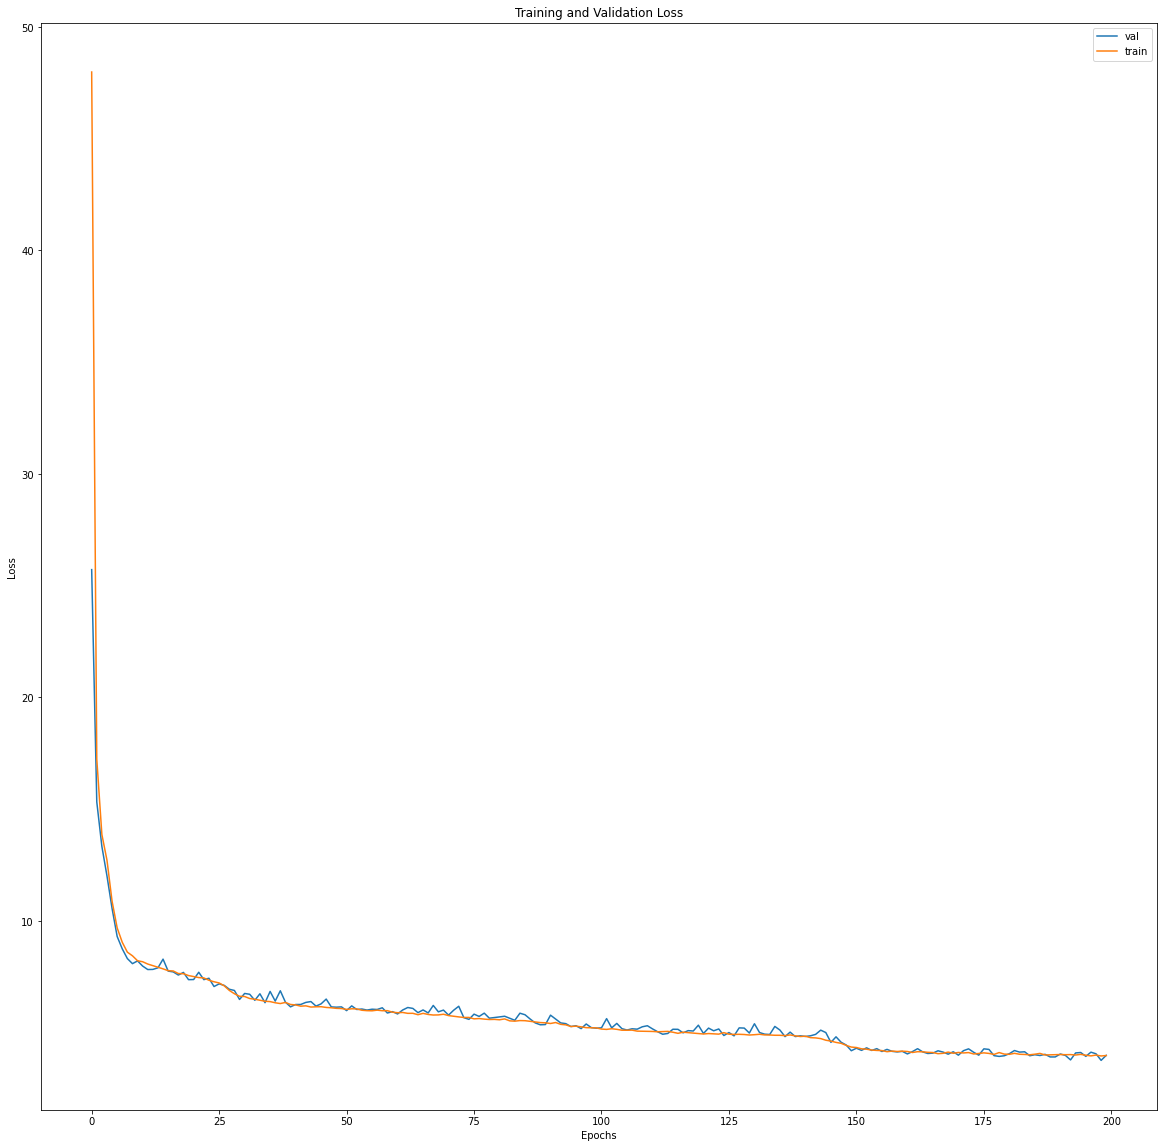

In [316]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("Training and Validation Loss")
plt.plot(val_loss,label="val")
plt.plot(train_loss,label="train")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [ ]:
# train_loss = train(net, trainloader, NUM_EPOCHS)
# torch.save(net.state_dict(), "model_2.weight")
with torch.no_grad():
  running_val_loss=0.0
  net.eval()
  for data in valloader:
      kp = data['keypoints']
      kp = kp.to(device)
      
      

      outputs = net(kp.float())
      
      loss = criterion(outputs, kp.float())
      running_val_loss += loss.item()
  val_loss = running_val_loss / len(valloader)
  print(val_loss)

In [ ]:
!ls

In [317]:
# device='cuda:0'
# net.to(device)
# net = net.float()
net.load_state_dict(torch.load('model_best.weight'))

<All keys matched successfully>

In [203]:
print(len(keypoints_array_sorted))

95233


In [318]:
# from google.colab.patches import cv2_imshow
# import cv2 
device='cuda:0'
xx=keypoints_array_sorted[1000]
# nm='./masked_fil_all/video_'+str(xx[0]).rjust(4, '0')+"_"+str(xx[1]).rjust(5, '0')+"_pedestrian"+str(xx[2])+".png"
# print(nm)
image=np.array([xx[3]])
image=np.delete(image, list(range(2, image.shape[1], 3)), axis=1)
# im=cv2.imread(nm,1)
# cv2_imshow(im)
net.eval()

outputs=net(torch.from_numpy(image).to(device).float())

In [319]:
print(image)
print(outputs)

[[148.48 714.66 151.29 713.15 147.05 712.02 154.05 715.3  143.4  711.82
  150.98 725.54 137.96 724.15 154.76 741.54 141.56 741.32 156.7  751.75
  154.01 748.24 150.86 761.92 143.85 762.57 152.4  792.51 150.96 791.51
  149.25 819.84 132.4  813.04]]
tensor([[146.8693, 712.7045, 150.8143, 710.5068, 146.4729, 709.9093, 153.8502,
         712.3621, 142.5653, 713.4468, 151.5737, 726.2101, 140.3479, 725.0203,
         151.2764, 743.2828, 140.1179, 745.0774, 150.7496, 752.1927, 144.1395,
         754.5323, 148.9243, 762.9126, 140.7017, 762.6835, 153.5971, 789.7710,
         141.3817, 790.1965, 152.9496, 813.0626, 136.9964, 815.1241]],
       device='cuda:0', grad_fn=<ReluBackward0>)


# Visualization

In [1]:
import matplotlib 

edges = [(0,1),(1,2),(2,3),(3,4),(1,5),(5,6),(6,7),(1,8),(8,9),(8,12),(9,10),(10,11),(12,13),(13,14),(11,24),(11,22),(22,23),(14,21),(14,19),(19,20),(0,15),(0,16),(15,17),(16,18)]

def draw_keypoints(outputs, image_in=None):
    # the `outputs` is list which in-turn contains the dictionaries 
    image=np.zeros((1920,1080,3))#image_in.copy()
    for i in range(len(outputs)):
        keypoints = outputs[i].cpu().detach().numpy()
        # print(keypoints)
        # proceed to draw the lines if the confidence score is above 0.9
        # if outputs[0]['scores'][i] > 0.9:
        keypoints = keypoints.reshape(-1, 2)
        # print(keypoints)
        for p in range(keypoints.shape[0]):
            # draw the keypoints
            if( not(keypoints[p,0]==0 and keypoints[p,1]==0)):
              cv2.circle(image, (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                        3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
           
        for ie, e in enumerate(edges):
            # get different colors for the edges
            rgb = matplotlib.colors.hsv_to_rgb([
                ie/float(len(edges)), 1.0, 1.0
            ])
            rgb = rgb*255
            # print(keypoints[e, 0][0])
            # join the keypoint pairs to draw the skeletal structure
            if not((keypoints[e, 0][0]==0 and keypoints[e, 1][0]==0) or (keypoints[e, 0][1]==0 and keypoints[e, 1][1]==0)):
              cv2.line(image, (keypoints[e, 0][0], keypoints[e, 1][0]),
                    (keypoints[e, 0][1], keypoints[e, 1][1]),
                    tuple(rgb), 2, lineType=cv2.LINE_AA)
        # else:
        #     continue
    return image



In [2]:
x=torch.from_numpy(image).to(device).float()
im2=draw_keypoints_op(x)
plt.imshow(im2)
plt.show()

NameError: name 'torch' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


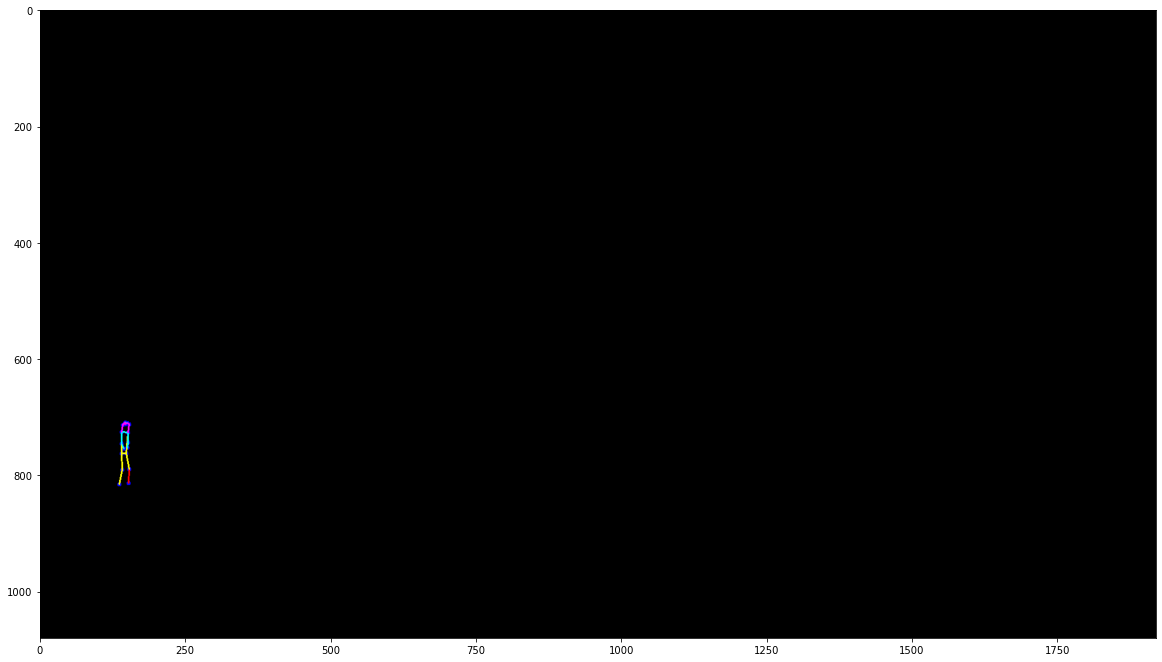

In [322]:
im2=draw_keypoints_op(outputs)
plt.imshow(im2)
plt.show()

In [ ]:
print(keypoints_array_sorted[500])

# Pose Data generation

In [2]:
# from google.colab import drive
# drive.mount('/gdrive',force_remount=True)
# %cd /gdrive/MyDrive/pose/bounding-box-prediction/JAAD
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, utils
import pickle
kpa=[]
keypoints=pickle.load(open("keypoints_all.pickle","rb"))
import numpy as np
kpd={}
for i in keypoints:
	kpd[i]=np.array(keypoints[i])
print(len(kpd))

kpa=[]

for key in list(kpd.keys()):
  x=key.split("_")
  vid_num=int(x[3])
  frame_num=int(x[4])
  ped_num=x[5]
  if(len(ped_num)==11):
    ped_num=int(x[5][10])
  else:
    ped_num=0

  if np.count_nonzero(kpd[key]==0)<4:
      kpa.append([vid_num,frame_num,ped_num,kpd[key]])
 
keypoints_array_sorted=sorted(kpa,key=lambda e:(e[0],e[2],e[1]))
print(len(keypoints_array_sorted))
# thresarr=[]
# for i in range(len(keypoints_array_sorted)):
#   vec=keypoints_array_sorted[i][3][2::3]
#   if (vec > 0.25).all():
#     thresarr.append(keypoints_array_sorted[i][3])

# print(len(thresarr))
# keypoints=np.array(thresarr)
# keypoints_x=keypoints[:,0::3]
# keypoints_y=keypoints[:,1::3]
# kp_train=np.delete(keypoints, list(range(2, keypoints.shape[1], 3)), axis=1)
# print(kp_train.shape)

74892
50623


In [39]:
# c_seq=0
# for seq in kp_seq:
#     ll = np.array(lst)
#     x  = 
# print(c_seq)

In [ ]:
# # import csv
# import pandas as pd
# %cd ./..

# sequence_centric = pd.read_csv('./jaad_train_16_16.csv')
# df = sequence_centric.copy()      
# for v in list(df.columns.values):
#     print(v+' loaded')
#     try:
#         df.loc[:,v] = df.loc[:, v].apply(lambda x: literal_eval(x))
#     except:
#         continue
# sequence_centric[df.columns] = df[df.columns]

In [ ]:
# data=sequence_centric.copy().reset_index(drop=True)

In [ ]:
# data.head()

In [ ]:

# import ast
# for i in range(len(data)):
#   bb = ast.literal_eval(data['bounding_box'][i])
#   fbb = ast.literal_eval(data['future_bounding_box'][i])
  	
#   # fname = ast.literal_eval(data['filename'][i])
#   # bb = list(zip(scene,fname))
#   # for p in bb:
#     # vid_num=int(p[0].replace("./JAAD\\scene\\",""))
#     # frame_num=int(p[1].replace(".png","")))
#   print(len(bb),len(fbb))
#   break

# Openpifpaf data generation

In [7]:
import pickle
kpa=[]
keypoints=pickle.load(open("keypoints_openpifpaf.pickle","rb"))
# print(type(keypoints))
import numpy as np
kpd={}
for i in keypoints:
	kpd[i]=np.array(keypoints[i])
  # break
print(len(kpd))
kpa=[]

for key in list(kpd.keys()):
  
  x=key.replace(".png.predictions.json","").split("_")
#   print(x)
  vid_num=int(x[2])
  frame_num=int(x[3])
  ped_num=x[4]
  if(len(ped_num)==11):
    ped_num=int(x[4][10])
  else:
    ped_num=0
 
#   print(vid_num,frame_num,ped_num,kpd[key])
  if np.count_nonzero(kpd[key]<=0)<=4:
      kpa.append([vid_num,frame_num,ped_num,kpd[key]])


keypoints_array_sorted=sorted(kpa,key=lambda e:(e[0],e[2],e[1]))
print(len(keypoints_array_sorted))
thresarr=[]
for i in range(len(keypoints_array_sorted)):
  vec=keypoints_array_sorted[i][3][2::3]
  if (vec > 0.18).all():
    thresarr.append(keypoints_array_sorted[i][3])

print(len(thresarr))

95233
18387
6022


In [8]:
import itertools

key_f = lambda e: (e[0],e[2])
kp_seq=[]
for key, group in itertools.groupby(keypoints_array_sorted, key_f):
    lg=list(group)
    # print(len(lg))
    kp_seq.append(lg)

In [9]:
print(len(keypoints_array_sorted))
gps=[]
for seq in kp_seq:
  l=[]
  for i in range(len(seq)):
    # print(seq[i][3].shape)
    vec=seq[i][3][2::3]
    if (vec > 0.25).all():
      l.append(keypoints_array_sorted[i][3])
  gps.append(l)

gps = list(filter(None, gps))
print(len(gps))

# for i in gps:

18387
244


In [10]:
def consecutive(data, stepsize=1):
    # print(data[:,1])
    return np.split(data, np.where(np.diff(data[:,1]) != stepsize)[0]+1)

# a = np.array([[0,0,2,[22,22]], [47,12,2,[22,22]], [48,48,2,[22,22]], [49,49,2,[22,22]], [50,50,2,[22,22]], [97,98,2,[22,22]], [98,99,2,[22,22]], [99,100,2,[22,22]]])
# consecutive(a)

In [11]:
print(len(kp_seq))
sequences=[]
seq_len=16
slide=4
c=0
for lst in kp_seq:
  c+=1
  # x=[[lst[i:i + 15],lst[i+15:i + 30]] for i in range(0, len(lst)-15, 15)]
  # for i in x:
  #   if(len(i)!=15):
  #     ll=np.array(i)
  #     idx = np.round(np.linspace(0, len(ll) - 1, 15)).astype(int)
  #     # print(idx)
  #     feat_spaced=ll[idx].tolist()
  #     # print(feat_spaced)
  #     sequences.append(feat_spaced)
  #   else:
  #     sequences.append(i)
  ll=np.array(lst)
  x=[np.array(i) for i in consecutive(ll)]
  
#   print([i.shape for i in xx])
  for tt in x:
    if(len(tt)>=seq_len):

      # print(i[0])
      pp=[[tt[i:i + seq_len],tt[i+seq_len:i + 2*seq_len]] for i in range(0, len(tt)-(2*seq_len), slide)]
      # print(len(pp))
      sequences.extend(pp)
  # print(xx[1][3])
  # if c==1:
    # break
print(len(sequences))


515
702


C:\Users\bigbo\miniconda3\envs\pv-lstm\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [19]:
array_of_seq=[]
tuples_to_save=[]
tups_x=[]
tups_y=[]
array_of_data=[]
for i in sequences:
  # print(len(i[0]),len(i[1]))
  x=np.array([p[3] for p in i[0]])
  y=np.array([p[3] for p in i[1]])
  array_of_seq.append([x,y])
  tuples_to_save.extend([(p[0],p[1],p[2]) for p in i[0]])
  tuples_to_save.extend([(p[0],p[1],p[2]) for p in i[1]])
#     tups_y.append()
  array_of_data.append([x,y,np.array([(p[0],p[1],p[2]) for p in i[0]]),np.array([(p[0],p[1],p[2]) for p in i[1]])])
  
array_of_seq=np.array(array_of_seq)
print(array_of_seq.shape)
print(len(tuples_to_save),tuples_to_save[0])
# array_of_data[0]

(702, 2, 16, 51)
22464 (4, 43, 0)


In [401]:
# print(tups[0])
# vid_num,frame_num,ped_num=tups[0]
# print()
from shutil import copyfile
import pickle
import os
tups=pickle.load(open('./scripts/tups_to_copy.pickle','rb'))
print(len(tups))
for i in range(len(tups)):
    print(i)
    vid_num,frame_num,ped_num=tups[i]
    frame='/work/vita/datasets/JAAD/images/'+'video_'+str(vid_num).rjust(4, '0')+"/"+str(frame_num).rjust(5, '0')+'.png'
    dst='/scratch/izar/prasad/frames/'+'video_'+str(vid_num).rjust(4, '0')+"/"+str(frame_num).rjust(5, '0')+'.png'
    if not os.path.exists(dst):
        print(frame)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        copyfile(frame, dst)
# print('video'+str(vid_num).rjust(4, '0')+"/"+str(frame_num).rjust(5, '0')+'.jpg')

FileNotFoundError: [Errno 2] No such file or directory: './scripts/tups_to_copy_openpifpaf.pickle'

In [402]:
tups=list(set(tuples_to_save))
print(len(tups))
pickle.dump(tups,open('./tups_to_copy_openpifpaf.pickle','wb'))

16104


In [20]:
# print(array_of_seq[0][0])
seq_out=np.delete(array_of_seq, list(range(2, array_of_seq.shape[3], 3)), axis=3)
# seq_out=array_of_seq
print(seq_out.shape)
# pickle.dump(seq_out,open('./sequences_fixed_new_train_test.pickle','wb'))

(702, 2, 16, 34)


In [10]:
# print(seq_out.shape)

In [30]:
import random 
import torch
sequences_all=[]
sequences_obs_speed=[]
sequences_true_speed=[]
sequences_obs_pose=[]
sequences_true_pose=[]
sequences_true_imgs=[]
sequences_obs_imgs=[]
seq_len=16
split=int(0.75*len(seq_out))
for p in range(len(seq_out)):
  outputs = []
#   observed = seq_out[p,0]
#   future = seq_out[p,1]
  
#   obs = torch.tensor([observed[i] for i in range(0,seq_len,1)])
#   true = torch.tensor([future[i] for i in range(0,seq_len,1)])
#   outputs.append(np.round(obs.numpy(),2))
#   outputs.append(np.round(true.numpy(),2))
#   sequences_all.append(outputs)
#   sequences_obs_pose.append(np.round(obs.numpy(),2).tolist())
#   sequences_true_pose.append(np.round(true.numpy(),2).tolist())
  observed = array_of_data[p][0]
  future = array_of_data[p][1]
    
#   print(observed)
  observed=np.delete(observed, list(range(2, observed.shape[1], 3)), axis=1)
  future=np.delete(future, list(range(2, future.shape[1], 3)), axis=1)
#   print(observed)
#   break
  obs = torch.tensor([observed[i] for i in range(0,seq_len,1)])
  true = torch.tensor([future[i] for i in range(0,seq_len,1)])
  sequences_obs_pose.append(np.round(obs.numpy(),2).tolist())
  sequences_true_pose.append(np.round(true.numpy(),2).tolist())
  sequences_true_imgs.append(['/frames/'+'video_'+str(i[0]).rjust(4, '0')+"/"+str(i[1]).rjust(5, '0')+'.png' for i in array_of_data[p][2]])
  sequences_obs_imgs.append(['/frames/'+'video_'+str(i[0]).rjust(4, '0')+"/"+str(i[1]).rjust(5, '0')+'.png' for i in array_of_data[p][3]])
#   print(sequences_true_imgs)
#   break  

c = list(zip(sequences_obs_pose, sequences_true_pose,sequences_true_imgs,sequences_obs_imgs))

random.shuffle(c)

sequences_obs_pose, sequences_true_pose, sequences_true_imgs, sequences_obs_imgs = zip(*c)

sequences_all_train=sequences_all[:split]
sequences_all_val=sequences_all[split:]
# print([i.shape for i in sequences_all[0]])

sequences_all=np.array(sequences_all)
# print(sequences_true.shape)
  # print([outputs[i].size() for i in range(len(outputs))])
# print(x_sp.shape)
# print(x[0,0],"\n",x[0,1],"\n",x_sp)

In [31]:
len(sequences_obs_pose[0][0])

34

In [32]:
import pandas as pd
data = {'Pose': sequences_obs_pose[:split],
        'Future_Pose': sequences_true_pose[:split],
        'Pose_image':sequences_true_imgs[:split],
        'Future_image':sequences_obs_imgs[:split]
        }
data_val = {'Pose': sequences_obs_pose[split:],
        'Future_Pose': sequences_true_pose[split:],
        'Pose_image':sequences_true_imgs[split:],
        'Future_image':sequences_obs_imgs[split:]
        }
df_train = pd.DataFrame (data, columns = ['Pose','Future_Pose','Pose_image','Future_image'])
df_val = pd.DataFrame (data_val, columns = ['Pose','Future_Pose','Pose_image','Future_image'])

df_train.to_csv("./sequences_openpifpaf_thres4_wimage_train.csv",index=False)
df_val.to_csv("./sequences_openpifpaf_thres4_wimage_val.csv", index=False)

print(df_train.head())

                                                Pose  \
0  [[1513.27, 578.7, 1515.99, 575.76, 1510.98, 57...   
1  [[682.14, 690.11, 685.05, 687.08, 679.43, 687....   
2  [[262.33, 685.08, 266.11, 681.11, 258.47, 681....   
3  [[1404.58, 487.19, 1407.12, 483.83, 1401.59, 4...   
4  [[362.05, 655.05, 363.88, 653.05, 360.53, 653....   

                                         Future_Pose  \
0  [[1575.76, 588.09, 1579.25, 584.71, 1574.25, 5...   
1  [[614.25, 688.53, 618.15, 686.12, 612.31, 685....   
2  [[232.52, 681.78, 236.14, 677.87, 228.66, 678....   
3  [[1395.12, 487.47, 1397.91, 484.05, 1392.33, 4...   
4  [[377.03, 655.13, 379.01, 652.63, 375.53, 653....   

                                          Pose_image  \
0  [/frames/video_0177/00054.png, /frames/video_0...   
1  [/frames/video_0223/00221.png, /frames/video_0...   
2  [/frames/video_0223/00329.png, /frames/video_0...   
3  [/frames/video_0231/00044.png, /frames/video_0...   
4  [/frames/video_0124/00275.png, /frames/vide

In [ ]:
train=pickle.load(open('./sequences_fixed_new_train_test.pickle','rb'))

In [13]:
print(df_train.shape,df_val.shape)

(1680, 2) (561, 2)


In [51]:
data = {'Pose': sequences_obs_pose[0:5],
        'Future_Pose': sequences_true_pose[0:5],
        }
data_val = {'Pose': sequences_obs_pose[5:10],
        'Future_Pose': sequences_true_pose[5:10],
        }
df_train = pd.DataFrame (data, columns = ['Pose','Future_Pose'])
df_val = pd.DataFrame (data_val, columns = ['Pose','Future_Pose'])

df_train.to_csv("./sequences_4_train.csv",index=False)
df_val.to_csv("./sequences_4_val.csv",index=False)

print(df_train.head())

                                                Pose  \
0  [[342.0, 669.0, 345.0, 692.0, 321.0, 695.0, 31...   
1  [[1749.0, 645.0, 1761.0, 692.0, 1740.0, 692.0,...   
2  [[1660.0, 692.0, 1669.0, 719.0, 1640.0, 719.0,...   
3  [[1428.0, 595.0, 1422.0, 610.0, 1402.0, 607.0,...   
4  [[1157.0, 601.0, 1163.0, 622.0, 1142.0, 622.0,...   

                                         Future_Pose  
0  [[295.0, 669.0, 298.0, 698.0, 271.0, 698.0, 25...  
1  [[1752.0, 645.0, 1769.0, 686.0, 1740.0, 689.0,...  
2  [[1654.0, 695.0, 1663.0, 722.0, 1637.0, 722.0,...  
3  [[1445.0, 598.0, 1437.0, 621.0, 1422.0, 618.0,...  
4  [[1166.0, 598.0, 1166.0, 622.0, 1146.0, 622.0,...  


In [ ]:
# %cd ./..
# !python train.py
# %cd JAAD

In [ ]:
# for idx in range(0,len(sequences_all_train),100):
#     vals=np.array(sequences_all_train[idx:idx+100])
#     print(vals[1].shape)
#     break

In [ ]:
# class args():
#     def __init__(self):
#         self.loader_workers = 1
#         self.loader_shuffle = True
#         self.device         = 'cuda'
#         self.batch_size     = 1
#         self.n_epochs       = 200
#         self.hidden_size    = 6400
#         self.hardtanh_limit = 100
#         self.input  = 4
#         self.output = 4
#         self.pin_memory= False
#         self.stride = 4
#         self.skip   = 1
#         self.task   = 'pose'
#         self.use_scenes = False       
#         self.lr = 0.001
        
# args = args()
# val_loader=data_loader(args,"val" )
# for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(val_loader):
# #     print(obs_s)
# #     print(target_s)
# #     print(obs_pose)
#     print(target_pose[0])
    
#     preds_p=target_s[:,0:1,:]+obs_pose[:,-1:,:]+2
#     print(preds_p)
#     print(float(ADE_c(preds_p, target_pose[:,0:1,:])))
#     print(float(FDE_c(preds_p, target_pose[:,0:1,:])))
            
# #         for i in range(1,16):
# #             preds_p = speed_preds[:,i,:]+preds_p[:,-1:,:]
# #             ade_train += float(ADE_c(preds_p, target_pose[:,i:i+1,:]))
# #             fde_train += float(FDE_c(preds_p, target_pose[:,i:i+1,:]))
            
        
    
#     break

# Models

In [30]:
# from google.colab import drive
# drive.mount('/gdrive',force_remount=True)
# %cd /gdrive/MyDrive/pose/bounding-box-prediction/JAAD
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, utils
import pickle
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as TF
import pandas as pd
from ast import literal_eval
import glob
import os
import numpy as np
from PIL import Image, ImageDraw
import cv2
import time
import pandas as pd
# np.set_printoptions(suppress=True)

# train=pickle.load(open('./sequences_fixed_new_train_test.pickle','rb'))

import matplotlib 
import cv2
from matplotlib import pyplot as plt
# from google.colab.patches import cv2_imshow
edges = [(0,1),(1,2),(2,3),(3,4),(1,5),(5,6),(6,7),(1,8),(8,9),(8,12),(9,10),(10,11),(12,13),(13,14),(11,24),(11,22),(22,23),(14,21),(14,19),(19,20),(0,15),(0,16),(15,17),(16,18)]

def draw_keypoints(outputs):
#     print(outputs.shape)
    image=np.zeros((1080,1920,3))
    for i in range(len(outputs)):
        keypoints = outputs[i]
        keypoints = keypoints.reshape(-1, 2)
        for p in range(keypoints.shape[0]):
            if( not(keypoints[p,0]==0 and keypoints[p,1]==0)):
              cv2.circle(image, (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                        3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
           
        for ie, e in enumerate(edges):
            # get different colors for the edges
            rgb = matplotlib.colors.hsv_to_rgb([
                ie/float(len(edges)), 1.0, 1.0
            ])
            rgb = rgb*255

            if not((keypoints[e, 0][0]==0 and keypoints[e, 1][0]==0) or (keypoints[e, 0][1]==0 and keypoints[e, 1][1]==0)):
                cv2.line(image, (int(keypoints[e, 0][0]), int(keypoints[e, 1][0])),
                    (int(keypoints[e, 0][1]), int(keypoints[e, 1][1])),
                    tuple(rgb), 2, lineType=cv2.LINE_AA)
        # else:
        #     continue
    image=cv2.resize(image,(1280,720))
    return image

In [144]:
pl

In [218]:
class PV_LSTM(nn.Module):
    def __init__(self, args):
        super(PV_LSTM, self).__init__()
        
        #Speed
        self.speed_encoder = nn.LSTM(input_size=50, hidden_size=args.hidden_size)
        self.speed_decoder  = nn.LSTMCell(input_size=50, hidden_size=args.hidden_size)
        self.fc_speed   = nn.Linear(in_features=args.hidden_size, out_features=50)
        
        #Pose
        self.pose_encoder = nn.LSTM(input_size=50, hidden_size=args.hidden_size)
#         self.pose_embedding = nn.Sequential(nn.Linear(in_features=args.hidden_size, out_features=50),nn.ReLU())
#         self.pose_decoder    = nn.LSTMCell(input_size=50, hidden_size=args.hidden_size)
#         self.fc_pose    = nn.Linear(in_features=args.hidden_size, out_features=50)
        
#         self.speed_encoder_local = nn.LSTM(input_size=50, hidden_size=args.hidden_size)
#         self.speed_decoder_local  = nn.LSTMCell(input_size=50, hidden_size=args.hidden_size)
#         self.fc_speed_local   = nn.Linear(in_features=args.hidden_size, out_features=50)
        
        #Pose
        self.pose_encoder = nn.LSTM(input_size=50, hidden_size=args.hidden_size)

        self.hardtanh = nn.Hardtanh(min_val=-1*args.hardtanh_limit, max_val=args.hardtanh_limit)
        self.softmax = nn.Softmax(dim=1)
        
        self.args = args
        
        
    def forward(self, speed=None, pos=None, pose=None, average=False):

    
        _, (hps, cps) = self.pose_encoder(pose.permute(1,0,2))
        hps = hps.squeeze(0)
        cps = cps.squeeze(0)
        
        _, (hsp, csp) = self.speed_encoder(speed.permute(1,0,2))
        hsp = hsp.squeeze(0)
        csp = csp.squeeze(0)
        
        
        outputs = []
        

        speed_outputs    = torch.tensor([], device=self.args.device)
        in_sp = speed[:,-1,:]
        
        hds = hsp + hps
        cds = csp + cps
        for i in range(self.args.output//self.args.skip):
            hds, cds         = self.speed_decoder(in_sp, (hds, cds))
            speed_output     = self.hardtanh(self.fc_speed(hds))
            speed_outputs    = torch.cat((speed_outputs, speed_output.unsqueeze(1)), dim = 1)
            in_sp            = speed_output#.detach()
            
        
#         pose_outputs = torch.tensor([], device=self.args.device)
#         in_pose = pose[:,-1,:]
          
#         hdp = hps + hsp
#         cdp = cps + csp
#         for i in range(self.args.output//self.args.skip):
#             hdp, cdp     = self.pose_decoder(in_pose, (hdp, cdp))
#             pose_output  = self.fc_pose(hdp)
#             in_pose      = self.pose_embedding(hdp).detach()
# #             pose_output  = self.softmax(pose_output)
#             pose_outputs = torch.cat((pose_outputs, pose_output.unsqueeze(1)), dim = 1)

#         outputs.append(pose_outputs)
        outputs.append(speed_outputs)
    
        return tuple(outputs)
    
    
    #use only speed and add to get position

In [31]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, args, dtype):
        
        self.args = args
        self.dtype = dtype
        print("Loading",self.dtype)
        
        sequence_centric = pd.read_csv("sequences_openpifpaf_"+self.dtype+".csv")
#         sequence_centric = pd.read_csv("sequences_4_"+self.dtype+".csv")

        df = sequence_centric.copy()      
        for v in list(df.columns.values):
            print(v+' loaded')
            try:
                df.loc[:,v] = df.loc[:, v].apply(lambda x: literal_eval(x))
            except:
                continue
        sequence_centric[df.columns] = df[df.columns]
        self.data = sequence_centric.copy().reset_index(drop=True)
    
        print('*'*30)
        

    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):

        seq = self.data.iloc[index]
        outputs = []

#         observed = torch.tensor(np.array(seq.Pose))
#         future = torch.tensor(np.array(seq.Future_Pose))
        
        

        obs = torch.tensor([seq.Pose[i] for i in range(0,self.args.input,self.args.skip)])
        #obs and future global avg of joint 5 & 6 (0 indexed) for openpifpaf
        #local = obs pose-global  for openpifpaf
        
        obs_speed = (obs[1:] - obs[:-1])
    
        outputs.append(obs_speed)
        
        
        true = torch.tensor([seq.Future_Pose[i] for i in range(0,self.args.output,self.args.skip)])
        true_speed = torch.cat(((true[0]-obs[-1]).unsqueeze(0), true[1:]-true[:-1]))


        outputs.append(true_speed)
        outputs.append(obs)
        outputs.append(true)
        
        return tuple(outputs)    
    
    
def data_loader(args,data):
    dataset = myDataset(args,data)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=args.batch_size, shuffle=args.loader_shuffle,
        pin_memory=args.pin_memory)

    return dataloader

#Interpolation

class myDataset_op(torch.utils.data.Dataset):
    def __init__(self, args, dtype):
        
        self.args = args
        self.dtype = dtype
        print("Loading",self.dtype)
        
        sequence_centric = pd.read_csv("sequences_16_overlap_4_thres4_"+self.dtype+".csv")
#         sequence_centric = pd.read_csv("sequences_4_"+self.dtype+".csv")

        df = sequence_centric.copy()      
        for v in list(df.columns.values):
            print(v+' loaded')
            try:
                df.loc[:,v] = df.loc[:, v].apply(lambda x: literal_eval(x))
            except:
                continue
        sequence_centric[df.columns] = df[df.columns]
        self.data = sequence_centric.copy().reset_index(drop=True)
    
        print('*'*30)
        

    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):

        seq = self.data.iloc[index]
        outputs = []

#         observed = torch.tensor(np.array(seq.Pose))
#         future = torch.tensor(np.array(seq.Future_Pose))
        
        

        obs = torch.tensor([seq.Pose[i] for i in range(0,self.args.input,self.args.skip)])
        #obs and future global avg of joint 5 & 6 (0 indexed) for openpifpaf
        #local = obs pose-global  for openpifpaf
        
        obs_speed = (obs[1:] - obs[:-1])
    
        outputs.append(obs_speed)
        
        
        true = torch.tensor([seq.Future_Pose[i] for i in range(0,self.args.output,self.args.skip)])
        true_speed = torch.cat(((true[0]-obs[-1]).unsqueeze(0), true[1:]-true[:-1]))


        outputs.append(true_speed)
        outputs.append(obs)
        outputs.append(true)
        
        return tuple(outputs)    
    
    
def data_loader_op(args,data):
    dataset = myDataset_op(args,data)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=args.batch_size, shuffle=args.loader_shuffle,
        pin_memory=args.pin_memory)

    return dataloader

In [238]:

class myDataset_conf(torch.utils.data.Dataset):
    def __init__(self, args, dtype):
        
        self.args = args
        self.dtype = dtype
        print("Loading",self.dtype)
        
        sequence_centric = pd.read_csv("sequences_openpose_wconfsc_"+self.dtype+".csv")
#         sequence_centric = pd.read_csv("sequences_4_"+self.dtype+".csv")

        df = sequence_centric.copy()      
        for v in list(df.columns.values):
            print(v+' loaded')
            try:
                df.loc[:,v] = df.loc[:, v].apply(lambda x: literal_eval(x))
            except:
                continue
        sequence_centric[df.columns] = df[df.columns]
        self.data = sequence_centric.copy().reset_index(drop=True)
    
        print('*'*30)
        

    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):

        seq = self.data.iloc[index]
        outputs = []

#         observed = torch.tensor(np.array(seq.Pose))
#         future = torch.tensor(np.array(seq.Future_Pose))
        
        

        obs_t = torch.tensor([seq.Pose[i] for i in range(0,self.args.input,self.args.skip)])
        #obs and future global avg of joint 5 & 6 (0 indexed) for openpifpaf
#         print(obs_t.shape)
        obs_resh=obs_t.reshape(-1,25,3)
#         print(obs_resh.shape)
        obs=obs_resh[:,:,0:2].reshape(-1,50)
        obs_conf=obs_resh[:,:,2].reshape(-1,25)
#         print(obs.shape,obs_conf.shape)
        #local = obs pose-global  for openpifpaf
        
        obs_speed = (obs[1:] - obs[:-1])
    
        outputs.append(obs_speed)
        
        
        true_t = torch.tensor([seq.Future_Pose[i] for i in range(0,self.args.output,self.args.skip)])
        true_resh=true_t.reshape(-1,25,3)
#         print(obs_resh.shape)
        true=true_resh[:,:,0:2].reshape(-1,50)
        true_conf=true_resh[:,:,2].reshape(-1,25)
#         print(true_conf)
        true_speed = torch.cat(((true[0]-obs[-1]).unsqueeze(0), true[1:]-true[:-1]))


        outputs.append(true_speed)
        outputs.append(obs)
        outputs.append(true)
        outputs.append(obs_conf)
        outputs.append(true_conf)
        
        return tuple(outputs)    
    
    
def data_loader_conf(args,data):
    dataset = myDataset_conf(args,data)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=args.batch_size, shuffle=args.loader_shuffle,
        pin_memory=args.pin_memory)

    return dataloader

#Interpolation
# train_loader=data_loader_conf(args,"train")
# for i in train_loader:
#     break

In [62]:

def ADE_c(pred, true):
    pred = torch.reshape(pred, (pred.size()[0],pred.size()[1],pred.size()[2]//2,2))
    true = torch.reshape(true, (true.size()[0],true.size()[1],true.size()[2]//2,2))
    
    displacement=torch.sqrt((pred[:,:,:,0]-true[:,:,:,0])**2+(pred[:,:,:,1]-true[:,:,:,1])**2)
    ade = torch.mean(torch.mean(displacement,dim=1))

    return ade


def FDE_c(pred, true):
    pred = torch.reshape(pred, (pred.size()[0],pred.size()[1],pred.size()[2]//2,2))
    true = torch.reshape(true, (true.size()[0],true.size()[1],true.size()[2]//2,2))
    
    displacement=torch.sqrt((pred[:,-1,:,0]-true[:,-1,:,0])**2+(pred[:,-1,:,1]-true[:,-1,:,1])**2)

    fde = torch.mean(torch.mean(displacement,dim=1))
    
    return fde

def speed2pos(preds, obs_p):
    pred_pos = torch.zeros(preds.shape[0], preds.shape[1], preds.shape[2]).to('cuda')
    current = obs_p[:,-1,:]
    
    for i in range(preds.shape[1]):
        pred_pos[:,i,:] = current + preds[:,i,:]
        current = pred_pos[:,i,:]
        
    for i in range(34):
        pred_pos[:,:,i] = torch.min(pred_pos[:,:,i], 1920*torch.ones(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
        pred_pos[:,:,i] = torch.max(pred_pos[:,:,i], torch.zeros(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
        
    return pred_pos

def ADE_c_op(pred, true):
    pred = torch.reshape(pred, (pred.size()[0],pred.size()[1],25,2))
    true = torch.reshape(true, (true.size()[0],true.size()[1],25,2))
    
    displacement=torch.sqrt((pred[:,:,:,0]-true[:,:,:,0])**2+(pred[:,:,:,1]-true[:,:,:,1])**2)
    ade = torch.mean(torch.mean(displacement,dim=1))

    return ade


def FDE_c_op(pred, true):
    pred = torch.reshape(pred, (pred.size()[0],pred.size()[1],25,2))
    true = torch.reshape(true, (true.size()[0],true.size()[1],25,2))
    
    displacement=torch.sqrt((pred[:,-1,:,0]-true[:,-1,:,0])**2+(pred[:,-1,:,1]-true[:,-1,:,1])**2)

    fde = torch.mean(torch.mean(displacement,dim=1))
    
    return fde

def speed2pos_openpose(preds, obs_p):
    pred_pos = torch.zeros(preds.shape[0], preds.shape[1], 50).to('cuda')
    current = obs_p[:,-1,:]
    
    for i in range(preds.shape[1]):
        pred_pos[:,i,:] = current + preds[:,i,:]
        current = pred_pos[:,i,:]
        
    for i in range(50):
        pred_pos[:,:,i] = torch.min(pred_pos[:,:,i], 1920*torch.ones(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
        pred_pos[:,:,i] = torch.max(pred_pos[:,:,i], torch.zeros(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
        
    return pred_pos

# PV-LSTM Openpose

In [244]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import utils
from sklearn.metrics import recall_score, accuracy_score, average_precision_score, precision_score

# import DataLoader
# import network
# import utils

class args():
    def __init__(self):
        self.jaad_dataset = '/data/smailait-data/JAAD/processed_annotations' #folder containing parsed jaad annotations (used when first time loading data)
        self.dtype        = 'train'
        self.from_file    = False #read dataset from csv file or reprocess data
        self.save         = True
        self.file         = '/data/smailait-data/jaad_train_16_16.csv'
        self.save_path    = '/data/smailait-data/jaad_train_16_16.csv'
        self.model_path    = '/data/smailait-data/models/multitask_pv_lstm_trained.pkl'
        self.loader_workers = 1
        self.loader_shuffle = True
        self.pin_memory     = False
        self.image_resize   = [240, 426]
        self.device         = 'cuda'
        self.batch_size     = 50
        self.n_epochs       = 100
        self.hidden_size    = 2000
        self.hardtanh_limit = 100
        self.input  = 16
        self.output = 16
        self.stride = 16
        self.skip   = 1
        # self.task   = 'bounding_box-intention'
        self.task   = 'pose'
        self.use_scenes = False       
        self.lr = 0.001
        
args = args()

# net = PV_LSTM(args).to(args.device)
net = PV_LSTM(args).to(args.device)

mse = nn.MSELoss()
bce = nn.BCELoss()
l1e = nn.L1Loss()
train_s_scores = []
train_pose_scores=[]
val_pose_scores=[]
train_c_scores = []
val_s_scores   = []
val_c_scores   = []

train_loader=data_loader_op(args,"train")
val_loader=data_loader_op(args,"val" )


optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, 
                                                 threshold = 1e-8, verbose=True)
print('='*100)
print('Training ...')

for epoch in range(args.n_epochs):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    
    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(train_loader):
        counter += 1        
        
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
 
        net.zero_grad()
    
        (speed_preds,) = net(pose=obs_pose, speed=obs_s)
#         pose_loss  = mse(pose_preds, target_pose)
#         speed_loss  = mse(speed_preds, target_s)
       
        speed_loss  = mse(speed_preds, target_s)
    
        preds_p = speed2pos_openpose(speed_preds, obs_pose) 
        ade_train += float(ADE_c_op(preds_p, target_pose))
        fde_train += float(FDE_c_op(preds_p, target_pose))
        
    
        speed_loss.backward()
#         loss = speed_loss 
#         loss.backward()
        optimizer.step()
        
    
        avg_epoch_train_s_loss += float(speed_loss)
#         avg_epoch_train_p_loss += float(pose_loss)
        
    avg_epoch_train_s_loss /= counter
    train_s_scores.append(avg_epoch_train_s_loss)
    ade_train  /= counter
    fde_train  /= counter    
#     avg_epoch_train_p_loss/=counter
#     train_pose_scores.append(avg_epoch_train_p_loss)
    
    counter=0

    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(val_loader):
        counter+=1
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        
        with torch.no_grad():
            (speed_preds,) = net(pose=obs_pose,speed=obs_s)
            #           pose_loss  = mse(pose_preds, target_pose)
#             speed_loss  = mse(speed_preds, target_s)
            speed_loss  = mse(speed_preds, target_s)
#             loss = speed_loss
            #           avg_epoch_val_p_loss += float(pose_loss)
            avg_epoch_val_s_loss += float(speed_loss)
            
           
            #           preds_pose=obs_pose+speed_preds
    
            preds_p = speed2pos_openpose(speed_preds, obs_pose)
            ade += float(ADE_c_op(preds_p, target_pose))
            fde += float(FDE_c_op(preds_p, target_pose))

        
    avg_epoch_val_s_loss /= counter
    val_s_scores.append(avg_epoch_val_s_loss)
    
    ade  /= counter
    fde  /= counter     
   
    scheduler.step(loss)
    
     
    print('e:', epoch, '| ts: %.4f'% avg_epoch_train_s_loss, '| tpose: %.4f'% avg_epoch_train_p_loss, '| vs: %.4f'% avg_epoch_val_s_loss, '| vpose: %.4f'% avg_epoch_val_p_loss, '| ade_train: %.4f'% ade_train, '| ade_val: %.4f'% ade, '| fde_train: %.4f'% fde_train,'| fde_val: %.4f'% fde,
          '| t:%.4f'%(time.time()-start))


print('='*100) 
# print('Saving ...')
# torch.save(net.state_dict(), args.model_path)
print('Done !')


Loading train
Pose loaded
Future_Pose loaded
******************************
Loading val
Pose loaded
Future_Pose loaded
******************************
Training ...
e: 0 | ts: 4315.1624 | tpose: 0.0000 | vs: 4259.0390 | vpose: 0.0000 | ade_train: 42.5065 | ade_val: 34.7683 | fde_train: 73.9650 | fde_val: 58.1009 | t:4.8179
e: 1 | ts: 4274.9579 | tpose: 0.0000 | vs: 3982.2458 | vpose: 0.0000 | ade_train: 33.8274 | ade_val: 30.2942 | fde_train: 54.5654 | fde_val: 49.3707 | t:4.7479
e: 2 | ts: 4261.4587 | tpose: 0.0000 | vs: 4128.6621 | vpose: 0.0000 | ade_train: 31.4872 | ade_val: 29.9457 | fde_train: 49.2948 | fde_val: 47.4224 | t:4.7581
e: 3 | ts: 4289.0130 | tpose: 0.0000 | vs: 3996.1155 | vpose: 0.0000 | ade_train: 31.9269 | ade_val: 32.5117 | fde_train: 50.0794 | fde_val: 53.1813 | t:4.7520
e: 4 | ts: 4260.8924 | tpose: 0.0000 | vs: 4098.6472 | vpose: 0.0000 | ade_train: 32.2016 | ade_val: 32.2181 | fde_train: 50.1677 | fde_val: 51.0462 | t:4.7601
e: 5 | ts: 4259.5157 | tpose: 0.0000 

KeyboardInterrupt: 

# PV-LSTM with confidence

In [226]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import utils
from sklearn.metrics import recall_score, accuracy_score, average_precision_score, precision_score

# import DataLoader
# import network
# import utils

class args():
    def __init__(self):
        self.jaad_dataset = '/data/smailait-data/JAAD/processed_annotations' #folder containing parsed jaad annotations (used when first time loading data)
        self.dtype        = 'train'
        self.from_file    = False #read dataset from csv file or reprocess data
        self.save         = True
        self.file         = '/data/smailait-data/jaad_train_16_16.csv'
        self.save_path    = '/data/smailait-data/jaad_train_16_16.csv'
        self.model_path    = '/data/smailait-data/models/multitask_pv_lstm_trained.pkl'
        self.loader_workers = 1
        self.loader_shuffle = True
        self.pin_memory     = False
        self.image_resize   = [240, 426]
        self.device         = 'cuda'
        self.batch_size     = 50
        self.n_epochs       = 250
        self.hidden_size    = 1000
        self.hardtanh_limit = 100
        self.input  = 16
        self.output = 16
        self.stride = 16
        self.skip   = 1
        # self.task   = 'bounding_box-intention'
        self.task   = 'pose'
        self.use_scenes = False       
        self.lr = 0.01
        
args = args()

# net = PV_LSTM(args).to(args.device)
net = PV_LSTM(args).to(args.device)
# train = DataLoader.data_loader(args)
# args.dtype = 'val'
# args.save_path = args.save_path.replace('train', 'val')
# args.file = args.file.replace('train', 'val')
# val = DataLoader.data_loader(args)

optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, 
                                                 threshold = 1e-8, verbose=True)
mse = nn.MSELoss()
bce = nn.BCELoss()
l1e = nn.L1Loss()
train_s_scores = []
train_pose_scores=[]
val_pose_scores=[]
train_c_scores = []
val_s_scores   = []
val_c_scores   = []

train_loader=data_loader_conf(args,"train")
val_loader=data_loader_conf(args,"val" )



optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, 
                                                 threshold = 1e-8, verbose=True)
print('='*100)
print('Training ...')

for epoch in range(args.n_epochs):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    
    for idx, (obs_s, target_s, obs_pose, target_pose, obs_conf, true_conf) in enumerate(train_loader):
        counter += 1        
        
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
 
        net.zero_grad()
    
        (speed_preds,) = net(pose=obs_pose, speed=obs_s)
#         print(speed_preds.shape,true_conf.shape)
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
#         pose_loss  = mse(pose_preds, target_pose)
#         speed_loss  = mse(speed_preds, target_s)
       
        speed_loss  = l1e(speed_preds, target_s)
    
        preds_p = speed2pos_openpose(speed_preds, obs_pose) 
        ade_train += float(ADE_c_op(preds_p, target_pose))
        fde_train += float(FDE_c_op(preds_p, target_pose))
        
    
        speed_loss.backward()
#         loss = speed_loss 
#         loss.backward()
        optimizer.step()
        
    
        avg_epoch_train_s_loss += float(speed_loss)
#         avg_epoch_train_p_loss += float(pose_loss)
        
    avg_epoch_train_s_loss /= counter
    train_s_scores.append(avg_epoch_train_s_loss)
    ade_train  /= counter
    fde_train  /= counter    
#     avg_epoch_train_p_loss/=counter
#     train_pose_scores.append(avg_epoch_train_p_loss)
    
    counter=0

    for idx, (obs_s, target_s, obs_pose, target_pose, obs_conf, true_conf) in enumerate(val_loader):
        counter+=1
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        
        with torch.no_grad():
            (speed_preds,) = net(pose=obs_pose,speed=obs_s)
            #           pose_loss  = mse(pose_preds, target_pose)
            weighted by true conf
            speed_loss  = mse(speed_preds, target_s)
            loss = speed_loss
            #           avg_epoch_val_p_loss += float(pose_loss)
            avg_epoch_val_s_loss += float(speed_loss)
            
           
            #           preds_pose=obs_pose+speed_preds
    
            preds_p = speed2pos_openpose(speed_preds, obs_pose)
            ade += float(ADE_c_op(preds_p, target_pose))
            fde += float(FDE_c_op(preds_p, target_pose))

        
    avg_epoch_val_s_loss /= counter
    val_s_scores.append(avg_epoch_val_s_loss)
    
    ade  /= counter
    fde  /= counter     
   
    scheduler.step(loss)
    
     
    print('e:', epoch, '| ts: %.4f'% avg_epoch_train_s_loss, '| tpose: %.4f'% avg_epoch_train_p_loss, '| vs: %.4f'% avg_epoch_val_s_loss, '| vpose: %.4f'% avg_epoch_val_p_loss, '| ade_train: %.4f'% ade_train, '| ade_val: %.4f'% ade, '| fde_train: %.4f'% fde_train,'| fde_val: %.4f'% fde,
          '| t:%.4f'%(time.time()-start))


print('='*100) 
# print('Saving ...')
# torch.save(net.state_dict(), args.model_path)
print('Done !')
    

Loading train
Pose loaded
Future_Pose loaded
******************************
Loading val
Pose loaded
Future_Pose loaded
******************************
Training ...
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([50, 16, 25])
torch.Size([50, 16, 50]) torch.Size([

KeyboardInterrupt: 

# BP-PV LSTM

In [228]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import utils
from sklearn.metrics import recall_score, accuracy_score, average_precision_score, precision_score

# import DataLoader
# import network
# import utils

class args():
    def __init__(self):
        self.jaad_dataset = '/data/smailait-data/JAAD/processed_annotations' #folder containing parsed jaad annotations (used when first time loading data)
        self.dtype        = 'train'
        self.from_file    = False #read dataset from csv file or reprocess data
        self.save         = True
        self.file         = '/data/smailait-data/jaad_train_16_16.csv'
        self.save_path    = '/data/smailait-data/jaad_train_16_16.csv'
        self.model_path    = '/data/smailait-data/models/multitask_pv_lstm_trained.pkl'
        self.loader_workers = 1
        self.loader_shuffle = True
        self.pin_memory     = False
        self.image_resize   = [240, 426]
        self.device         = 'cuda'
        self.batch_size     = 50
        self.n_epochs       = 250
        self.hidden_size    = 1000
        self.hardtanh_limit = 100
        self.input  = 16
        self.output = 16
        self.stride = 16
        self.skip   = 1
        # self.task   = 'bounding_box-intention'
        self.task   = 'pose'
        self.use_scenes = False       
        self.lr = 0.01
        
args = args()

# net = PV_LSTM(args).to(args.device)
net = BP_LSTM_vel(args).to(args.device)
# train = DataLoader.data_loader(args)
# args.dtype = 'val'
# args.save_path = args.save_path.replace('train', 'val')
# args.file = args.file.replace('train', 'val')
# val = DataLoader.data_loader(args)

optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, 
                                                 threshold = 1e-8, verbose=True)
mse = nn.MSELoss()
bce = nn.BCELoss()
l1e = nn.L1Loss()
train_s_scores = []
train_pose_scores=[]
val_pose_scores=[]
train_c_scores = []
val_s_scores   = []
val_c_scores   = []

train_loader=data_loader(args,"train")
val_loader=data_loader(args,"val" )


Loading train
Pose loaded
Future_Pose loaded
******************************
Loading val
Pose loaded
Future_Pose loaded
******************************


In [229]:

optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, 
                                                 threshold = 1e-8, verbose=True)
print('='*100)
print('Training ...')

for epoch in range(args.n_epochs):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    
    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(train_loader):
        counter += 1        
        
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
 
        net.zero_grad()
    
        (speed_preds,) = net(pose=obs_pose, vel=obs_s)
#         pose_loss  = mse(pose_preds, target_pose)
#         speed_loss  = mse(speed_preds, target_s)
       
        speed_loss  = l1e(speed_preds, target_s)
    
        preds_p = speed2pos(speed_preds, obs_pose) 
        ade_train += float(ADE_c(preds_p, target_pose))
        fde_train += float(FDE_c(preds_p, target_pose))
        
    
        speed_loss.backward()
#         loss = speed_loss 
#         loss.backward()
        optimizer.step()
        
    
        avg_epoch_train_s_loss += float(speed_loss)
#         avg_epoch_train_p_loss += float(pose_loss)
        
    avg_epoch_train_s_loss /= counter
    train_s_scores.append(avg_epoch_train_s_loss)
    ade_train  /= counter
    fde_train  /= counter    
#     avg_epoch_train_p_loss/=counter
#     train_pose_scores.append(avg_epoch_train_p_loss)
    
    counter=0

    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(val_loader):
        counter+=1
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        
        with torch.no_grad():
            (speed_preds,) = net(pose=obs_pose,vel=obs_s)
            #           pose_loss  = mse(pose_preds, target_pose)
#             speed_loss  = mse(speed_preds, target_s)
            speed_loss  = l1e(speed_preds, target_s)
#             loss = speed_loss
            #           avg_epoch_val_p_loss += float(pose_loss)
            avg_epoch_val_s_loss += float(speed_loss)
            
           
            #           preds_pose=obs_pose+speed_preds
    
            preds_p = speed2pos(speed_preds, obs_pose)
            ade += float(ADE_c(preds_p, target_pose))
            fde += float(FDE_c(preds_p, target_pose))

        
    avg_epoch_val_s_loss /= counter
    val_s_scores.append(avg_epoch_val_s_loss)
    
    ade  /= counter
    fde  /= counter     
   
    scheduler.step(loss)
    
     
    print('e:', epoch, '| ts: %.4f'% avg_epoch_train_s_loss, '| tpose: %.4f'% avg_epoch_train_p_loss, '| vs: %.4f'% avg_epoch_val_s_loss, '| vpose: %.4f'% avg_epoch_val_p_loss, '| ade_train: %.4f'% ade_train, '| ade_val: %.4f'% ade, '| fde_train: %.4f'% fde_train,'| fde_val: %.4f'% fde,
          '| t:%.4f'%(time.time()-start))


print('='*100) 
# print('Saving ...')
# torch.save(net.state_dict(), args.model_path)
print('Done !')

Training ...
e: 0 | ts: 2.5145 | tpose: 0.0000 | vs: 2.8875 | vpose: 0.0000 | ade_train: 29.0091 | ade_val: 36.1318 | fde_train: 55.5494 | fde_val: 68.5193 | t:0.4261
e: 1 | ts: 2.4141 | tpose: 0.0000 | vs: 2.6154 | vpose: 0.0000 | ade_train: 26.6815 | ade_val: 31.3682 | fde_train: 51.7258 | fde_val: 59.2816 | t:0.2842
e: 2 | ts: 2.1147 | tpose: 0.0000 | vs: 2.5246 | vpose: 0.0000 | ade_train: 22.7519 | ade_val: 29.6137 | fde_train: 43.0164 | fde_val: 55.7249 | t:0.2741
e: 3 | ts: 1.9490 | tpose: 0.0000 | vs: 2.2941 | vpose: 0.0000 | ade_train: 19.5495 | ade_val: 25.4017 | fde_train: 37.1635 | fde_val: 48.4861 | t:0.2710
e: 4 | ts: 1.7760 | tpose: 0.0000 | vs: 2.0918 | vpose: 0.0000 | ade_train: 16.5046 | ade_val: 21.9771 | fde_train: 31.3200 | fde_val: 42.0923 | t:0.2701
e: 5 | ts: 1.6783 | tpose: 0.0000 | vs: 1.9824 | vpose: 0.0000 | ade_train: 14.8044 | ade_val: 19.9926 | fde_train: 28.4931 | fde_val: 39.1197 | t:0.2701
e: 6 | ts: 1.6457 | tpose: 0.0000 | vs: 1.8783 | vpose: 0.0000 

e: 52 | ts: 1.1106 | tpose: 0.0000 | vs: 1.5352 | vpose: 0.0000 | ade_train: 5.9063 | ade_val: 12.0530 | fde_train: 9.0018 | fde_val: 23.2786 | t:0.2621
e: 53 | ts: 1.1051 | tpose: 0.0000 | vs: 1.5190 | vpose: 0.0000 | ade_train: 5.8144 | ade_val: 11.9126 | fde_train: 8.8148 | fde_val: 22.7305 | t:0.2671
e: 54 | ts: 1.1066 | tpose: 0.0000 | vs: 1.5182 | vpose: 0.0000 | ade_train: 5.8657 | ade_val: 11.8846 | fde_train: 9.1233 | fde_val: 22.7595 | t:0.2770
e: 55 | ts: 1.0998 | tpose: 0.0000 | vs: 1.5295 | vpose: 0.0000 | ade_train: 5.7450 | ade_val: 11.9833 | fde_train: 8.8413 | fde_val: 23.1725 | t:0.2651
e: 56 | ts: 1.0963 | tpose: 0.0000 | vs: 1.5273 | vpose: 0.0000 | ade_train: 5.7004 | ade_val: 11.9973 | fde_train: 8.6899 | fde_val: 23.0323 | t:0.2661
e: 57 | ts: 1.0975 | tpose: 0.0000 | vs: 1.5355 | vpose: 0.0000 | ade_train: 5.7754 | ade_val: 12.0774 | fde_train: 8.8668 | fde_val: 23.3870 | t:0.2655
e: 58 | ts: 1.0932 | tpose: 0.0000 | vs: 1.5333 | vpose: 0.0000 | ade_train: 5.711

e: 105 | ts: 1.0405 | tpose: 0.0000 | vs: 1.5352 | vpose: 0.0000 | ade_train: 5.0646 | ade_val: 11.8778 | fde_train: 7.6118 | fde_val: 22.9272 | t:0.2633
e: 106 | ts: 1.0411 | tpose: 0.0000 | vs: 1.5373 | vpose: 0.0000 | ade_train: 5.0696 | ade_val: 11.8987 | fde_train: 7.6453 | fde_val: 23.0218 | t:0.2731
e: 107 | ts: 1.0409 | tpose: 0.0000 | vs: 1.5381 | vpose: 0.0000 | ade_train: 5.0661 | ade_val: 11.9055 | fde_train: 7.6453 | fde_val: 23.0571 | t:0.2651
e: 108 | ts: 1.0401 | tpose: 0.0000 | vs: 1.5373 | vpose: 0.0000 | ade_train: 5.0636 | ade_val: 11.8967 | fde_train: 7.6180 | fde_val: 23.0119 | t:0.2641
e: 109 | ts: 1.0382 | tpose: 0.0000 | vs: 1.5370 | vpose: 0.0000 | ade_train: 5.0460 | ade_val: 11.8903 | fde_train: 7.5694 | fde_val: 22.9925 | t:0.2811
e: 110 | ts: 1.0395 | tpose: 0.0000 | vs: 1.5372 | vpose: 0.0000 | ade_train: 5.0443 | ade_val: 11.8904 | fde_train: 7.5895 | fde_val: 23.0023 | t:0.2680
e: 111 | ts: 1.0387 | tpose: 0.0000 | vs: 1.5377 | vpose: 0.0000 | ade_train

e: 157 | ts: 1.0363 | tpose: 0.0000 | vs: 1.5383 | vpose: 0.0000 | ade_train: 4.9943 | ade_val: 11.8816 | fde_train: 7.4999 | fde_val: 23.0058 | t:0.2641
e: 158 | ts: 1.0343 | tpose: 0.0000 | vs: 1.5383 | vpose: 0.0000 | ade_train: 4.9886 | ade_val: 11.8806 | fde_train: 7.4694 | fde_val: 23.0035 | t:0.2811
e: 159 | ts: 1.0327 | tpose: 0.0000 | vs: 1.5383 | vpose: 0.0000 | ade_train: 4.9737 | ade_val: 11.8798 | fde_train: 7.4629 | fde_val: 23.0001 | t:0.2661
Epoch   161: reducing learning rate of group 0 to 9.7656e-06.
e: 160 | ts: 1.0355 | tpose: 0.0000 | vs: 1.5383 | vpose: 0.0000 | ade_train: 4.9876 | ade_val: 11.8808 | fde_train: 7.4838 | fde_val: 23.0027 | t:0.2758
e: 161 | ts: 1.0334 | tpose: 0.0000 | vs: 1.5383 | vpose: 0.0000 | ade_train: 4.9815 | ade_val: 11.8804 | fde_train: 7.4590 | fde_val: 23.0013 | t:0.2621
e: 162 | ts: 1.0330 | tpose: 0.0000 | vs: 1.5383 | vpose: 0.0000 | ade_train: 4.9771 | ade_val: 11.8798 | fde_train: 7.4546 | fde_val: 22.9995 | t:0.2650
e: 163 | ts: 1

e: 209 | ts: 1.0325 | tpose: 0.0000 | vs: 1.5382 | vpose: 0.0000 | ade_train: 4.9689 | ade_val: 11.8762 | fde_train: 7.4383 | fde_val: 22.9876 | t:0.2661
e: 210 | ts: 1.0317 | tpose: 0.0000 | vs: 1.5382 | vpose: 0.0000 | ade_train: 4.9704 | ade_val: 11.8762 | fde_train: 7.4478 | fde_val: 22.9877 | t:0.2661
e: 211 | ts: 1.0333 | tpose: 0.0000 | vs: 1.5382 | vpose: 0.0000 | ade_train: 4.9780 | ade_val: 11.8762 | fde_train: 7.4470 | fde_val: 22.9876 | t:0.2771
e: 212 | ts: 1.0334 | tpose: 0.0000 | vs: 1.5382 | vpose: 0.0000 | ade_train: 4.9754 | ade_val: 11.8762 | fde_train: 7.4456 | fde_val: 22.9878 | t:0.2611
e: 213 | ts: 1.0332 | tpose: 0.0000 | vs: 1.5382 | vpose: 0.0000 | ade_train: 4.9727 | ade_val: 11.8763 | fde_train: 7.4605 | fde_val: 22.9879 | t:0.2641
e: 214 | ts: 1.0348 | tpose: 0.0000 | vs: 1.5382 | vpose: 0.0000 | ade_train: 4.9863 | ade_val: 11.8763 | fde_train: 7.4651 | fde_val: 22.9879 | t:0.2635
e: 215 | ts: 1.0344 | tpose: 0.0000 | vs: 1.5382 | vpose: 0.0000 | ade_train

In [166]:
torch.save(net.state_dict(), "./model_openpifpaf_l1.pkl")

In [ ]:
# net.load_state_dict(torch.load('./model_pose_nf.pkl',map_location=torch.device('cpu')))

In [ ]:
def draw_keypoints_op (outputs):
    edges = [(13,15),(13,11),(16,14),(14,12),(11,12),(5,11),(6,12),(5,6),(5,7),(6,8),(8,10),(7,9),
             (1,2),(0,1),(0,2),(1,3),(2,4),(3,5),(4,6)]

    
#     print(outputs.shape)
    image=np.zeros((1080,1920,3))
    for i in range(len(outputs)):
        keypoints = outputs[i]
        keypoints = keypoints.reshape(-1, 2)
        for p in range(keypoints.shape[0]):
            if( not(keypoints[p,0]==0 and keypoints[p,1]==0)):
              cv2.circle(image, (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                        3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
           
        for ie, e in enumerate(edges):
            # get different colors for the edges
            rgb = matplotlib.colors.hsv_to_rgb([
                ie/float(len(edges)), 1.0, 1.0
            ])
            rgb = rgb*255

            if not((keypoints[e, 0][0]==0 and keypoints[e, 1][0]==0) or (keypoints[e, 0][1]==0 and keypoints[e, 1][1]==0)):
                cv2.line(image, (int(keypoints[e, 0][0]), int(keypoints[e, 1][0])),
                    (int(keypoints[e, 0][1]), int(keypoints[e, 1][1])),
                    tuple(rgb), 2, lineType=cv2.LINE_AA)
        # else:
        #     continue
#     image=cv2.resize(image,(1280,720))
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SAMPLE 0 ..................................................
torch.Size([49, 15, 34]) torch.Size([49, 16, 34]) torch.Size([49, 16, 34]) torch.Size([49, 16, 34])
expected ....................................................................................................


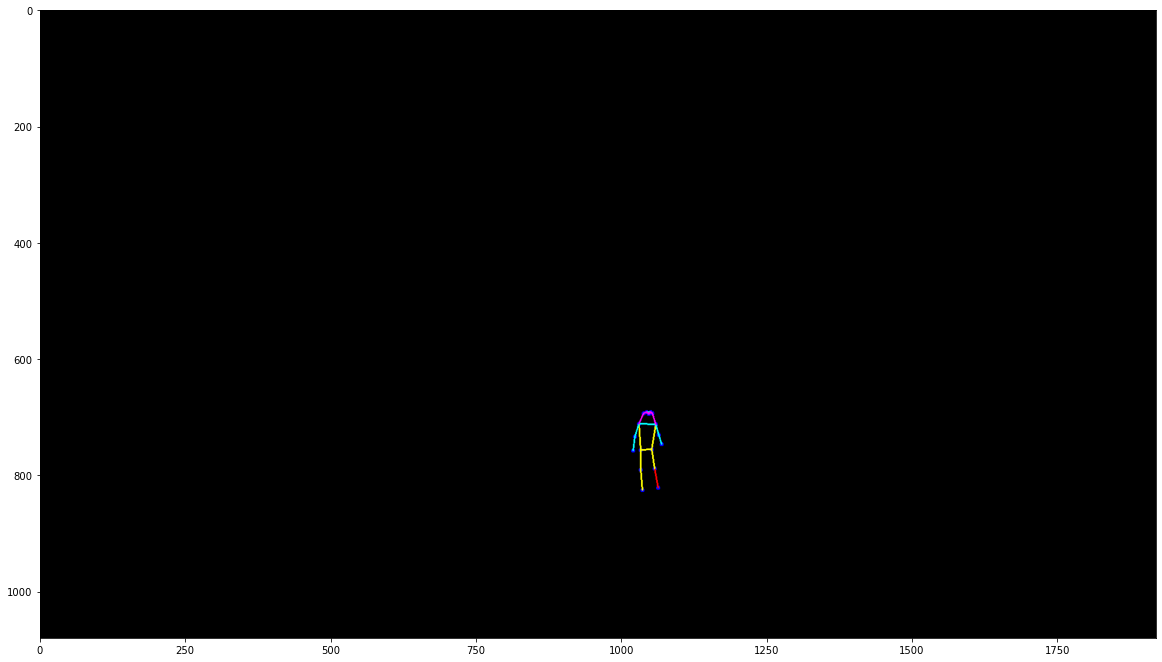

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


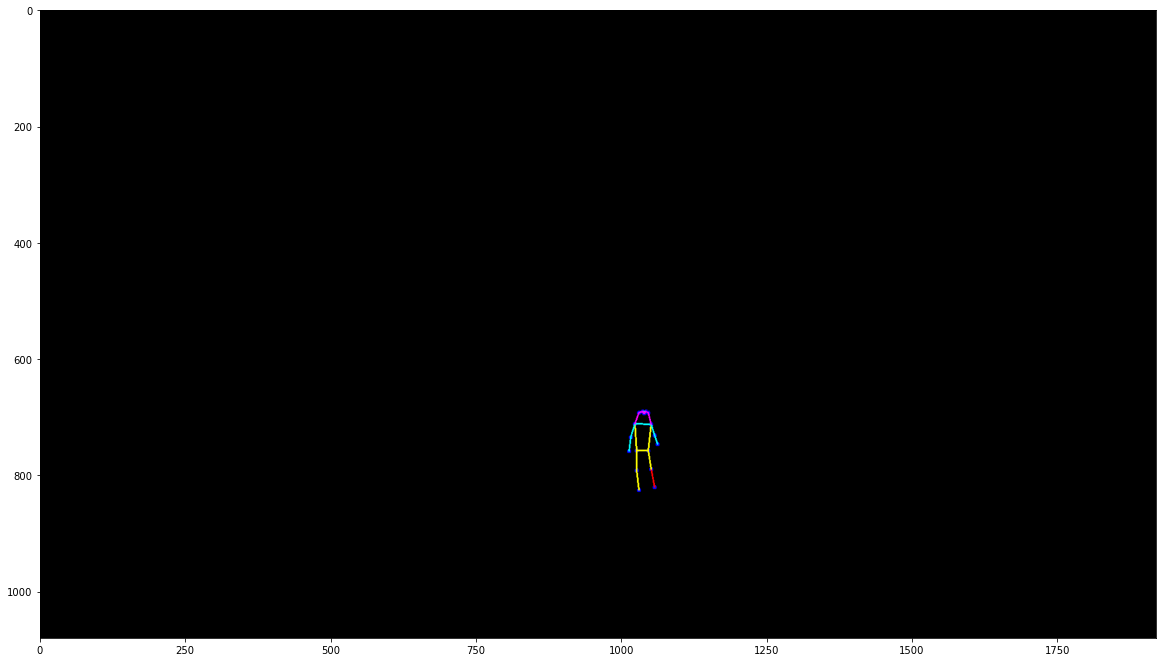

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

In [101]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]

for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(val_loader):
    print("SAMPLE",idx,"."*50)
   
    obs_s    = obs_s.to(device='cuda')
    target_s = target_s.to(device='cuda')
    obs_pose    = obs_pose.to(device='cuda')
    target_pose = target_pose.to(device='cuda')
    print(obs_s.size(),obs_pose.size(),target_s.size(),target_pose.size())
    (speed_preds,) = net(pose=obs_pose,vel=obs_s)
#     speed_preds=speed_preds.detach().cpu().numpy()
#     obs_pose=obs_pose.detach().cpu().numpy()
    pose_preds = speed2pos(speed_preds, obs_pose).detach().cpu().numpy()
    
#     print(target_pose[0,0])
#     print(pose_preds[0,0])
    for cnt in range(obs_s.size()[0]):
        print("expected","."*100)
        for i in range(15): 
          obs_p=target_pose[cnt:cnt+1,i]
          im2=draw_keypoints_op(obs_p)
          plt.imshow(im2)
          plt.show()
        break
#           cv2.imwrite('./outputs/image_expected_'+str(cnt)+"_"+str(i)+".png",im2)

        #   cv2_imshow(im2)
#         print("predicted","."*100)
#         for i in range(15): 
#           expected_pose=pose_preds[cnt:cnt+1,i]
#           im2=draw_keypoints_op(expected_pose)
#           plt.imshow(im2)
#           plt.show()
#           cv2.imwrite('./outputs/image_predicted_'+str(cnt)+"_"+str(i)+".png",im2)
    #   cv2_imshow(im2)

     


In [ ]:
# for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(val_loader):
#     print("SAMPLE",idx,"."*50)
   
#     obs_s    = obs_s.to(device='cuda')
#     target_s = target_s.to(device='cuda')
#     obs_pose    = obs_pose.to(device='cuda')
#     target_pose = target_pose.to(device='cuda')
  
#     (speed_preds,) = net(pose=obs_pose,vel=obs_s)
    
#     pose_preds = speed2pos(speed_preds, obs_pose).detach().cpu().numpy()
#     print(obs_pose+target_s)
#     print(target_pose)
# #     pose_preds=pose_preds
#     target_pose=target_pose.detach().cpu().numpy()

# #     print("expected","."*100)
# #     for i in range(16): 
# #       target_p=target_pose[0:1,i]
# #       im2=draw_keypoints(target_p)
# #       plt.imshow(im2)
# #       plt.show()
        
# #     #   cv2_imshow(im2)
# #     print("predicted","."*100)
# #     for i in range(16): 
# #       expected_pose=preds_p[0:1,i]
# #       im2=draw_keypoints(expected_pose)
# #       plt.imshow(im2)
# #       plt.show()
# #     #   cv2_imshow(im2)


In [ ]:
# # for i in range(len(gps)):
#   # print(len(gps[i]))
# # xx = list(filter(None, gps))
# # for i in range(len(xx)):
#   # print(len(xx[i]))
# print([len(i) for i in xx])
# fil=[]
# for i in range(len(xx)):
#   if len(xx[i])>15:
#     fil.append(xx[i])

# print(len(fil))

In [ ]:
# # # img=torch.from_numpy(image).to(device)
# # obs_pose=torch.from_numpy(np.array([image]))
# # print(obs_pose.size())
# # obs_pose=obs_pose.to(device).float()
# # (pose_preds,) = net(pose=obs_pose)
# # print(pose_preds.size())
# # out_pose=pose_preds.detach()[0,0]
# # print(out_pose.shape)
# # im2=draw_keypoints(out_pose,im)
# # cv2_imshow(im2)
# device="cuda:0"
# print(train_dataset[0][0][14])
# print(train_dataset[0][1][0])
# obs_pose=train_dataset[0,0:1,:].to(device).float()
# # print(obs_pose.size())
# (pose_preds,) = net(pose=obs_pose)
# # print(pose_preds.size())
# print(pose_preds[0][0])


# Disentangle

In [1]:
import os
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import numpy as np
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms, utils
import pickle
import numpy as np
import torch
import torchvision
import torchvision.transforms.functional as TF
import pandas as pd
from ast import literal_eval
import glob
import os
import numpy as np
from PIL import Image, ImageDraw
import cv2
import time
import pandas as pd

In [53]:
class myDataset_DE(torch.utils.data.Dataset):
    def __init__(self, args, dtype):
        
        self.args = args
        self.dtype = dtype
        print("Loading",self.dtype)
        
        sequence_centric = pd.read_csv("sequences_openpifpaf_"+self.dtype+".csv")
#         sequence_centric = pd.read_csv("sequences_16_overlap_4_thres4_"+self.dtype+".csv") 

        df = sequence_centric.copy()      
        for v in list(df.columns.values):
            print(v+' loaded')
            try:
                df.loc[:,v] = df.loc[:, v].apply(lambda x: literal_eval(x))
            except:
                continue
        sequence_centric[df.columns] = df[df.columns]
        self.data = sequence_centric.copy().reset_index(drop=True)
    
        print('*'*30)
        

    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):

        seq = self.data.iloc[index]
        outputs = []

        obs = torch.tensor([seq.Pose[i] for i in range(0,self.args.input,self.args.skip)])        
        obs_speed = (obs[1:] - obs[:-1])
        
        true = torch.tensor([seq.Future_Pose[i] for i in range(0,self.args.output,self.args.skip)])
        true_speed = torch.cat(((true[0]-obs[-1]).unsqueeze(0), true[1:]-true[:-1]))
        

        obs_resh = torch.reshape(obs, (obs.size()[0],17,2))
        
        obs_global=obs_resh[:,0]
        obs_global=obs_global.unsqueeze(1)

        obs_resh=obs_resh-obs_global
    
        obs_resh=obs_resh.reshape(obs.size())
        
        true_resh = torch.reshape(true, (true.size()[0],17,2))
        true_global=true_resh[:,0]
        true_global=true_global.unsqueeze(1)
#         print(obs_resh.size(),obs_global.size())
        true_resh=true_resh-true_global
        true_resh=true_resh.reshape(true.size())
        
        
        obs_global=torch.reshape(obs_global, (obs.size()[0],2))
        true_global=torch.reshape(true_global, (true.size()[0],2))
        
        obs_local_speed=(obs_resh[1:] - obs_resh[:-1])
        true_local_speed=torch.cat(((true_resh[0]-obs_resh[-1]).unsqueeze(0), true_resh[1:]-true_resh[:-1]))
        
        obs_global_speed = (obs_global[1:] - obs_global[:-1])
        true_global_speed = torch.cat(((true_global[0]-obs_global[-1]).unsqueeze(0), true_global[1:]-true_global[:-1]))
        
#         print(obs_resh.size(),true_resh.size(),obs_global.size(),true_global.size())
        
        outputs.append(obs)
        outputs.append(obs_resh)
        outputs.append(true_resh)
        outputs.append(obs_global)
        outputs.append(true_global)
        outputs.append(obs_local_speed)
        outputs.append(true_local_speed)
        outputs.append(obs_global_speed)
        outputs.append(true_global_speed)
        outputs.append(true_speed)
        outputs.append(true)

        
        return tuple(outputs)    
    
    
def data_loader_DE(args,data):
    dataset = myDataset_DE(args,data)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=args.batch_size, shuffle=args.loader_shuffle,
        pin_memory=args.pin_memory)

    return dataloader

#Interpolation

In [60]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import utils
# from sklearn.metrics import recall_score, accuracy_score, average_precision_score, precision_score

# import DataLoader
# import network
# import utils

class args():
    def __init__(self):
        self.jaad_dataset = '/data/smailait-data/JAAD/processed_annotations' #folder containing parsed jaad annotations (used when first time loading data)
        self.dtype        = 'train'
        self.from_file    = False #read dataset from csv file or reprocess data
        self.save         = True
        self.file         = '/data/smailait-data/jaad_train_16_16.csv'
        self.save_path    = '/data/smailait-data/jaad_train_16_16.csv'
        self.model_path    = '/data/smailait-data/models/multitask_pv_lstm_trained.pkl'
        self.loader_workers = 1
        self.loader_shuffle = True
        self.pin_memory     = False
        self.image_resize   = [240, 426]
        self.device         = 'cuda'
        self.batch_size     = 50
        self.n_epochs       = 250
        self.hidden_size    = 1000
        self.hardtanh_limit = 100
        self.input  = 16
        self.output = 16
        self.stride = 16
        self.skip   = 1
        # self.task   = 'bounding_box-intention'
        self.task   = 'pose'
        self.use_scenes = False       
        self.lr = 0.03
        
args = args()


optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, 
                                                 threshold = 1e-8, verbose=True)
mse = nn.MSELoss()
bce = nn.BCELoss()
l1e = nn.L1Loss()
train_s_scores = []
train_pose_scores=[]
val_pose_scores=[]
train_c_scores = []
val_s_scores   = []
val_c_scores   = []
train_g_scores = []
val_g_scores   = []

train_loader=data_loader_DE(args,"train",)
val_loader=data_loader_DE(args,"val")

Loading train
Pose loaded
Future_Pose loaded
******************************
Loading val
Pose loaded
Future_Pose loaded
******************************


In [7]:
def speed2pos_glob(preds, glob_pred, obs_p, obs_global) :
    pred_pos = torch.zeros(preds.shape[0], preds.shape[1], 34).to('cuda')

    current = (obs_p[:,-1,:].reshape(-1,17,2)+ obs_global[:,-1,:].reshape(-1,1,2)).reshape(-1,34)
    
    for i in range(preds.shape[1]):
        pred_pos[:,i,:] = ((current + preds[:,i,:]).reshape(current.size()[0],17,2)+glob_pred[:,i,:].reshape(-1,1,2)).reshape(-1,34)
        current = pred_pos[:,i,:]
        
    for i in range(34):
        pred_pos[:,:,i] = torch.min(pred_pos[:,:,i], 1920*torch.ones(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
        pred_pos[:,:,i] = torch.max(pred_pos[:,:,i], torch.zeros(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
        
    return pred_pos

def ADE_c_DE(pred, true):
    pred = torch.reshape(pred, (pred.size()[0],pred.size()[1],1,2))
    true = torch.reshape(true, (true.size()[0],true.size()[1],1,2))
    
    displacement=torch.sqrt((pred[:,:,:,0]-true[:,:,:,0])**2+(pred[:,:,:,1]-true[:,:,:,1])**2)
    ade = torch.mean(torch.mean(displacement,dim=1))

    return ade


def FDE_c_DE(pred, true):
    pred = torch.reshape(pred, (pred.size()[0],pred.size()[1],1,2))
    true = torch.reshape(true, (true.size()[0],true.size()[1],1,2))
    
    displacement=torch.sqrt((pred[:,-1,:,0]-true[:,-1,:,0])**2+(pred[:,-1,:,1]-true[:,-1,:,1])**2)

    fde = torch.mean(torch.mean(displacement,dim=1))
    
    return fde

In [55]:
class myDataset_DE_op(torch.utils.data.Dataset):
    def __init__(self, args, dtype):
        
        self.args = args
        self.dtype = dtype
        print("Loading",self.dtype)
        
        sequence_centric = pd.read_csv("sequences_16_overlap_4_thres4_"+self.dtype+".csv") 

        df = sequence_centric.copy()      
        for v in list(df.columns.values):
            print(v+' loaded')
            try:
                df.loc[:,v] = df.loc[:, v].apply(lambda x: literal_eval(x))
            except:
                continue
        sequence_centric[df.columns] = df[df.columns]
        self.data = sequence_centric.copy().reset_index(drop=True)
    
        print('*'*30)
        

    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):

        seq = self.data.iloc[index]
        outputs = []

        obs = torch.tensor([seq.Pose[i] for i in range(0,self.args.input,self.args.skip)])        
        obs_speed = (obs[1:] - obs[:-1])
        
        true = torch.tensor([seq.Future_Pose[i] for i in range(0,self.args.output,self.args.skip)])
        true_speed = torch.cat(((true[0]-obs[-1]).unsqueeze(0), true[1:]-true[:-1]))
        

        obs_resh = torch.reshape(obs, (obs.size()[0],25,2))
        
        obs_global=obs_resh[:,1]
        obs_global=obs_global.unsqueeze(1)

        obs_resh=obs_resh-obs_global
    
        obs_resh=obs_resh.reshape(obs.size())
        
        true_resh = torch.reshape(true, (true.size()[0],25,2))
        true_global=true_resh[:,1]
        true_global=true_global.unsqueeze(1)
#         print(obs_resh.size(),obs_global.size())
        true_resh=true_resh-true_global
        true_resh=true_resh.reshape(true.size())
        
        
        obs_global=torch.reshape(obs_global, (obs.size()[0],2))
        true_global=torch.reshape(true_global, (true.size()[0],2))
        
        obs_local_speed=(obs_resh[1:] - obs_resh[:-1])
        true_local_speed=torch.cat(((true_resh[0]-obs_resh[-1]).unsqueeze(0), true_resh[1:]-true_resh[:-1]))
        
        obs_global_speed = (obs_global[1:] - obs_global[:-1])
        true_global_speed = torch.cat(((true_global[0]-obs_global[-1]).unsqueeze(0), true_global[1:]-true_global[:-1]))
        
#         print(obs_resh.size(),true_resh.size(),obs_global.size(),true_global.size())
        
        outputs.append(obs)
        outputs.append(obs_resh)
        outputs.append(true_resh)
        outputs.append(obs_global)
        outputs.append(true_global)
        outputs.append(obs_local_speed)
        outputs.append(true_local_speed)
        outputs.append(obs_global_speed)
        outputs.append(true_global_speed)
        outputs.append(true_speed)
        outputs.append(true)

        
        return tuple(outputs)    
    
    
def data_loader_DE_op(args,data):
    dataset = myDataset_DE_op(args,data)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=args.batch_size, shuffle=args.loader_shuffle,
        pin_memory=args.pin_memory)

    return dataloader

#Interpolation

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms


class PV_LSTM_DE(nn.Module):
    def __init__(self, args):
        '''
           input: observed body poses and velocites global and local
           output: global and local velocities
        '''
        super(PV_LSTM_DE, self).__init__()
        self.in_s=50
        self.pose_encoder = nn.LSTM(input_size=self.in_s, hidden_size=args.hidden_size)
        self.vel_encoder = nn.LSTM(input_size=self.in_s, hidden_size=args.hidden_size)
        self.vel_decoder = nn.LSTMCell(input_size=self.in_s, hidden_size=args.hidden_size)
        self.fc_vel    = nn.Linear(in_features=args.hidden_size, out_features=self.in_s)
        
        self.pose_glob_encoder = nn.LSTM(input_size=2, hidden_size=100)
        self.vel_glob_encoder = nn.LSTM(input_size=2, hidden_size=100)
        self.vel_glob_decoder = nn.LSTMCell(input_size=2, hidden_size=100)
        self.fc_global    = nn.Linear(in_features=100, out_features=2)
        
        self.fc_combine= nn.Linear(in_features=self.in_s, out_features=self.in_s)
        
        self.hardtanh = nn.Hardtanh(min_val=-1*args.hardtanh_limit,max_val=args.hardtanh_limit)
        self.relu = nn.ReLU() 
        self.softmax = nn.Softmax(dim=1)
        
        
        self.args = args
        
    def forward(self, pose_local=None, vel_local=None, pose_glob=None, vel_glob=None):


        _, (hidden_vel, cell_vel) = self.vel_encoder(vel_local.permute(1,0,2))
        hidden_vel = hidden_vel.squeeze(0)
        cell_vel = cell_vel.squeeze(0)


        _, (hidden_pose, cell_pose) = self.pose_encoder(pose_local.permute(1,0,2))
        hidden_pose = hidden_pose.squeeze(0)
        cell_pose = cell_pose.squeeze(0)
        
        _, (hidden_vel_glob, cell_vel_glob) = self.vel_glob_encoder(vel_glob.permute(1,0,2))
        hidden_vel_glob = hidden_vel_glob.squeeze(0)
        cell_vel_glob = cell_vel_glob.squeeze(0)
        
        _, (hidden_pose_glob, cell_pose_glob) = self.pose_glob_encoder(pose_glob.permute(1,0,2))
        hidden_pose_glob = hidden_pose_glob.squeeze(0)
        cell_pose_glob = cell_pose_glob.squeeze(0)
        
        outputs = []
        
 
        vel_local_outputs    = torch.tensor([], device=self.args.device)
        vel_glob_outputs    = torch.tensor([], device=self.args.device)
        vel_combine_outputs = torch.tensor([], device=self.args.device)

        VelDec_inp = vel_local[:,-1,:]
        VelDec_glob_inp = vel_glob[:,-1,:]
        
        hidden_dec = hidden_pose + hidden_vel
        cell_dec = cell_pose + cell_vel
        
        hidden_glob = hidden_pose_glob + hidden_vel_glob
        cell_glob = cell_pose_glob + cell_vel_glob
    
        
        for i in range(self.args.output//self.args.skip):
            hidden_dec, cell_dec = self.vel_decoder(VelDec_inp, (hidden_dec, cell_dec))
            vel_local_output  = self.hardtanh(self.fc_vel(hidden_dec))
            vel_local_outputs = torch.cat((vel_local_outputs, vel_local_output.unsqueeze(1)), dim = 1)
            VelDec_inp  = vel_local_output.detach()
            
            hidden_glob, cell_glob = self.vel_glob_decoder(VelDec_glob_inp, (hidden_glob, cell_glob))
            vel_glob_output  = self.hardtanh(self.fc_global(hidden_glob))
            vel_glob_outputs = torch.cat((vel_glob_outputs, vel_glob_output.unsqueeze(1)), dim = 1)
            VelDec_glob_inp  = vel_glob_output.detach()
            
            
            vel_local=vel_local_output.reshape(-1,self.in_s//2,2)
            vel_glob=vel_glob_output.reshape(-1,1,2)
            
            vel_combine=(vel_local+vel_glob).reshape(-1,self.in_s)
            
#             vel_combine_output=self.fc_combine(vel_combine)
            
            vel_combine_outputs = torch.cat((vel_combine_outputs, vel_combine.unsqueeze(1)), dim = 1)#_output

            
        outputs.append(vel_local_outputs)
        outputs.append(vel_glob_outputs)
        outputs.append(vel_combine_outputs)
        
        return tuple(outputs)

net = PV_LSTM_DE(args).to(args.device)

In [88]:
train_loader=data_loader_DE_op(args,"train",)
val_loader=data_loader_DE_op(args,"val")

Loading train
Pose loaded
Future_Pose loaded
******************************
Loading val
Pose loaded
Future_Pose loaded
******************************


In [91]:

optimizer = optim.Adam(net.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=8, 
                                                 threshold = 1e-8, verbose=True)
print('='*100)
print('Training ...')
alpha=0.3

for epoch in range(200):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    avg_epoch_train_g_loss   = 0
    avg_epoch_val_g_loss     = 0
    avg_epoch_train_loss   = 0
    avg_epoch_val_loss     = 0 
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    
    for idx, (obs_pose, obs_pose_local, target_pose_local, obs_pose_global, target_pose_global, obs_s_l, target_s_l, obs_s_g, target_s_g, target_s, target) in enumerate(train_loader):
        counter += 1        
               
        obs_pose = obs_pose.to(device='cuda')
        obs_pose_local    = obs_pose_local.to(device='cuda')
        target_pose_local = target_pose_local.to(device='cuda')
        obs_pose_global = obs_pose_global.to(device='cuda')
        target_pose_global = target_pose_global.to(device='cuda')
        obs_s_l  = obs_s_l.to(device='cuda')
        target_s_l = target_s_l.to(device='cuda')
        obs_s_g  = obs_s_g.to(device='cuda')
        target_s_g = target_s_g.to(device='cuda')
        target_s = target_s.to(device='cuda')
        target = target.to(device='cuda')
        
        net.zero_grad()
    
        (speed_preds,global_preds,target_preds) = net(pose_local=obs_pose_local, vel_local=obs_s_l, pose_glob=obs_pose_global, vel_glob=obs_s_g)

        speed_loss  = l1e(speed_preds, target_s_l)
        global_loss =  l1e(global_preds, target_s_g)
        act_loss = l1e(target_preds,target_s)
        
        loss = 0.25*speed_loss + 0.25*global_loss + 0.5*act_loss
        loss.backward()
    
        preds_p=speed2pos(target_preds,obs_pose)
        
        ade_train += float(ADE_c(preds_p, target))
        fde_train += float(FDE_c(preds_p, target))
        
        optimizer.step()
        
        avg_epoch_train_s_loss += float(speed_loss)
        avg_epoch_train_g_loss += float(global_loss)
        avg_epoch_train_loss += float(act_loss)
        
    avg_epoch_train_s_loss /= counter
    avg_epoch_train_g_loss /= counter
    avg_epoch_train_loss /= counter
    
    ade_train  /= counter
    fde_train  /= counter  
    counter=0

    for idx, (obs_pose, obs_pose_local, target_pose_local, obs_pose_global, target_pose_global, obs_s_l, target_s_l, obs_s_g, target_s_g, target_s, target) in enumerate(val_loader):
        counter+=1
        
        obs_pose = obs_pose.to(device='cuda')
        obs_pose_local = obs_pose_local.to(device='cuda')
        target_pose_local = target_pose_local.to(device='cuda')
        obs_pose_global = obs_pose_global.to(device='cuda')
        target_pose_global = target_pose_global.to(device='cuda')
        obs_s_l  = obs_s_l.to(device='cuda')
        target_s_l = target_s_l.to(device='cuda')
        obs_s_g  = obs_s_g.to(device='cuda')
        target_s_g = target_s_g.to(device='cuda')
        target_s = target_s.to(device='cuda')
        target = target.to(device='cuda')
        

        
        with torch.no_grad():
            
            (speed_preds,global_preds,target_preds) = net(pose_local=obs_pose_local, vel_local=obs_s_l, pose_glob=obs_pose_global, vel_glob=obs_s_g)
            
            speed_loss  = l1e(speed_preds, target_s_l)
            global_loss =  l1e(global_preds, target_s_g)
            act_loss = l1e(target_preds,target_s)

            val_loss = 0.25*speed_loss + 0.25*global_loss + 0.5*act_loss
            
            preds_p=speed2pos(target_preds,obs_pose)
            
            avg_epoch_val_s_loss += float(speed_loss)
            avg_epoch_val_g_loss += float(global_loss)
            avg_epoch_val_loss += float(act_loss)
            
            ade += float(ADE_c(preds_p, target))
            fde += float(FDE_c(preds_p, target))

        
    avg_epoch_val_s_loss /= counter
    avg_epoch_val_g_loss /= counter
    avg_epoch_val_loss /= counter
    
    ade  /= counter
    fde  /= counter     
    
    scheduler.step(val_loss)
    
     
    print('e:', epoch, '| ts: %.2f'% avg_epoch_train_s_loss, '| tg: %.2f'% avg_epoch_train_g_loss, '| vs: %.2f'% avg_epoch_val_s_loss, '| vg: %.2f'% avg_epoch_val_g_loss, '| t: %.2f'% avg_epoch_train_loss, '| v: %.2f'% avg_epoch_val_loss, '| ade_train: %.2f'% ade_train, '| ade_val: %.2f'% ade, '| fde_train: %.2f'% fde_train,'| fde_val: %.2f'% fde)



print('='*100) 
print('Done !')

Training ...
e: 0 | ts: 8.87 | tg: 2.47 | vs: 8.79 | vg: 2.34 | t: 8.63 | v: 8.71 | ade_train: 30.28 | ade_val: 31.06 | fde_train: 48.43 | fde_val: 51.64
e: 1 | ts: 8.72 | tg: 2.21 | vs: 8.73 | vg: 2.30 | t: 8.56 | v: 8.62 | ade_train: 30.10 | ade_val: 29.75 | fde_train: 47.67 | fde_val: 48.29
e: 2 | ts: 8.69 | tg: 2.18 | vs: 8.57 | vg: 2.29 | t: 8.53 | v: 8.46 | ade_train: 29.01 | ade_val: 29.79 | fde_train: 46.38 | fde_val: 48.93
e: 3 | ts: 8.68 | tg: 2.19 | vs: 8.60 | vg: 2.28 | t: 8.51 | v: 8.50 | ade_train: 29.11 | ade_val: 29.51 | fde_train: 46.15 | fde_val: 48.23
e: 4 | ts: 8.61 | tg: 2.15 | vs: 8.57 | vg: 2.27 | t: 8.44 | v: 8.46 | ade_train: 28.58 | ade_val: 29.65 | fde_train: 44.97 | fde_val: 48.49
e: 5 | ts: 8.84 | tg: 2.16 | vs: 8.45 | vg: 2.29 | t: 8.67 | v: 8.35 | ade_train: 29.33 | ade_val: 29.90 | fde_train: 46.32 | fde_val: 49.06
e: 6 | ts: 8.51 | tg: 2.15 | vs: 8.65 | vg: 2.26 | t: 8.33 | v: 8.54 | ade_train: 28.50 | ade_val: 30.09 | fde_train: 45.12 | fde_val: 49.14


e: 56 | ts: 8.59 | tg: 2.05 | vs: 8.71 | vg: 2.25 | t: 8.37 | v: 8.61 | ade_train: 26.91 | ade_val: 30.58 | fde_train: 41.64 | fde_val: 49.44
e: 57 | ts: 8.53 | tg: 2.03 | vs: 8.42 | vg: 2.26 | t: 8.30 | v: 8.32 | ade_train: 26.44 | ade_val: 29.67 | fde_train: 41.30 | fde_val: 49.14
e: 58 | ts: 8.52 | tg: 2.01 | vs: 8.50 | vg: 2.25 | t: 8.28 | v: 8.41 | ade_train: 26.61 | ade_val: 30.02 | fde_train: 41.14 | fde_val: 49.07
Epoch    60: reducing learning rate of group 0 to 3.1250e-04.
e: 59 | ts: 8.32 | tg: 2.02 | vs: 8.42 | vg: 2.22 | t: 8.08 | v: 8.31 | ade_train: 26.54 | ade_val: 29.46 | fde_train: 41.05 | fde_val: 48.28
e: 60 | ts: 8.56 | tg: 2.03 | vs: 8.85 | vg: 2.25 | t: 8.32 | v: 8.75 | ade_train: 27.58 | ade_val: 30.13 | fde_train: 42.87 | fde_val: 48.91
e: 61 | ts: 8.57 | tg: 2.04 | vs: 8.66 | vg: 2.26 | t: 8.33 | v: 8.56 | ade_train: 26.80 | ade_val: 30.07 | fde_train: 41.37 | fde_val: 48.93
e: 62 | ts: 8.46 | tg: 2.04 | vs: 8.53 | vg: 2.26 | t: 8.21 | v: 8.42 | ade_train: 26.

e: 112 | ts: 8.45 | tg: 2.01 | vs: 8.68 | vg: 2.27 | t: 8.21 | v: 8.59 | ade_train: 25.83 | ade_val: 30.29 | fde_train: 39.88 | fde_val: 49.31
e: 113 | ts: 8.80 | tg: 2.04 | vs: 8.44 | vg: 2.25 | t: 8.55 | v: 8.35 | ade_train: 27.10 | ade_val: 29.89 | fde_train: 41.24 | fde_val: 49.08
e: 114 | ts: 8.57 | tg: 2.03 | vs: 8.65 | vg: 2.26 | t: 8.33 | v: 8.55 | ade_train: 26.46 | ade_val: 30.29 | fde_train: 40.66 | fde_val: 49.45
e: 115 | ts: 8.43 | tg: 2.01 | vs: 8.69 | vg: 2.25 | t: 8.18 | v: 8.59 | ade_train: 26.16 | ade_val: 29.75 | fde_train: 40.69 | fde_val: 48.50
e: 116 | ts: 8.51 | tg: 2.01 | vs: 8.83 | vg: 2.27 | t: 8.26 | v: 8.73 | ade_train: 26.56 | ade_val: 30.05 | fde_train: 41.25 | fde_val: 49.58
e: 117 | ts: 8.32 | tg: 2.02 | vs: 8.57 | vg: 2.24 | t: 8.06 | v: 8.48 | ade_train: 25.78 | ade_val: 29.53 | fde_train: 39.97 | fde_val: 48.18
e: 118 | ts: 8.51 | tg: 2.03 | vs: 8.46 | vg: 2.23 | t: 8.27 | v: 8.36 | ade_train: 26.17 | ade_val: 29.57 | fde_train: 42.33 | fde_val: 48.88

e: 167 | ts: 8.69 | tg: 2.05 | vs: 8.64 | vg: 2.26 | t: 8.45 | v: 8.55 | ade_train: 26.48 | ade_val: 30.27 | fde_train: 41.51 | fde_val: 49.40
e: 168 | ts: 8.64 | tg: 2.02 | vs: 8.58 | vg: 2.26 | t: 8.40 | v: 8.47 | ade_train: 26.48 | ade_val: 29.81 | fde_train: 40.64 | fde_val: 49.40
e: 169 | ts: 8.37 | tg: 2.03 | vs: 8.44 | vg: 2.24 | t: 8.12 | v: 8.35 | ade_train: 26.34 | ade_val: 29.90 | fde_train: 40.57 | fde_val: 49.18
e: 170 | ts: 8.59 | tg: 2.02 | vs: 8.68 | vg: 2.26 | t: 8.35 | v: 8.57 | ade_train: 26.51 | ade_val: 29.79 | fde_train: 41.04 | fde_val: 48.66
e: 171 | ts: 8.62 | tg: 2.04 | vs: 8.47 | vg: 2.22 | t: 8.37 | v: 8.37 | ade_train: 26.47 | ade_val: 29.98 | fde_train: 41.00 | fde_val: 48.58
e: 172 | ts: 8.56 | tg: 2.03 | vs: 8.38 | vg: 2.25 | t: 8.31 | v: 8.28 | ade_train: 26.18 | ade_val: 29.48 | fde_train: 40.65 | fde_val: 48.63
e: 173 | ts: 8.45 | tg: 2.02 | vs: 8.58 | vg: 2.25 | t: 8.20 | v: 8.49 | ade_train: 26.75 | ade_val: 30.01 | fde_train: 41.64 | fde_val: 49.57

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


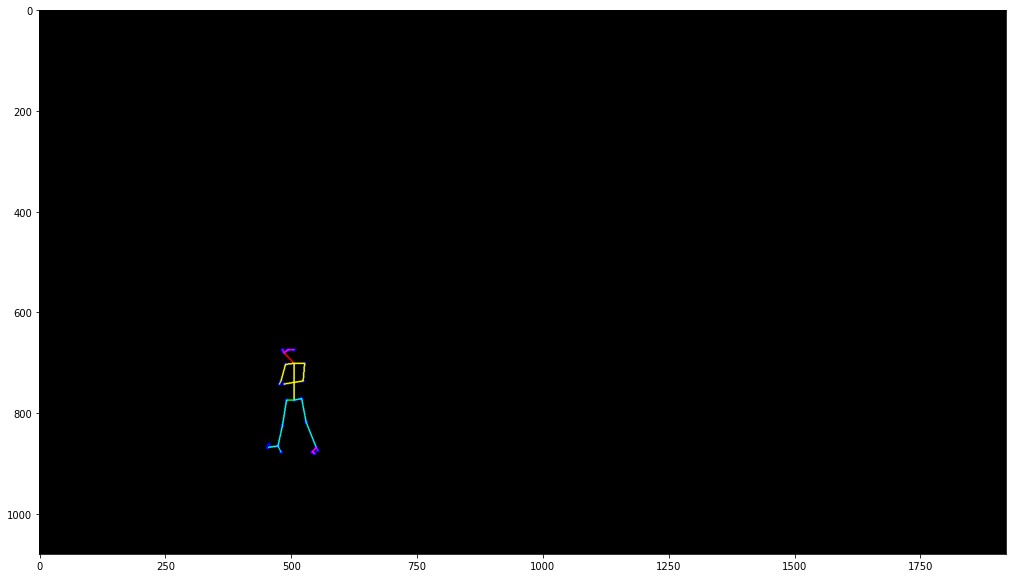

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


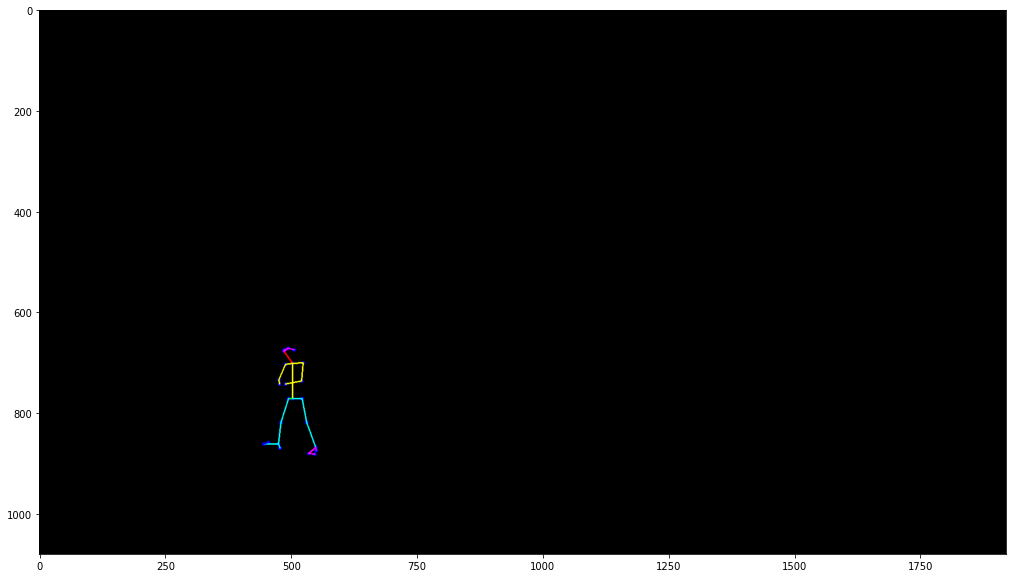

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


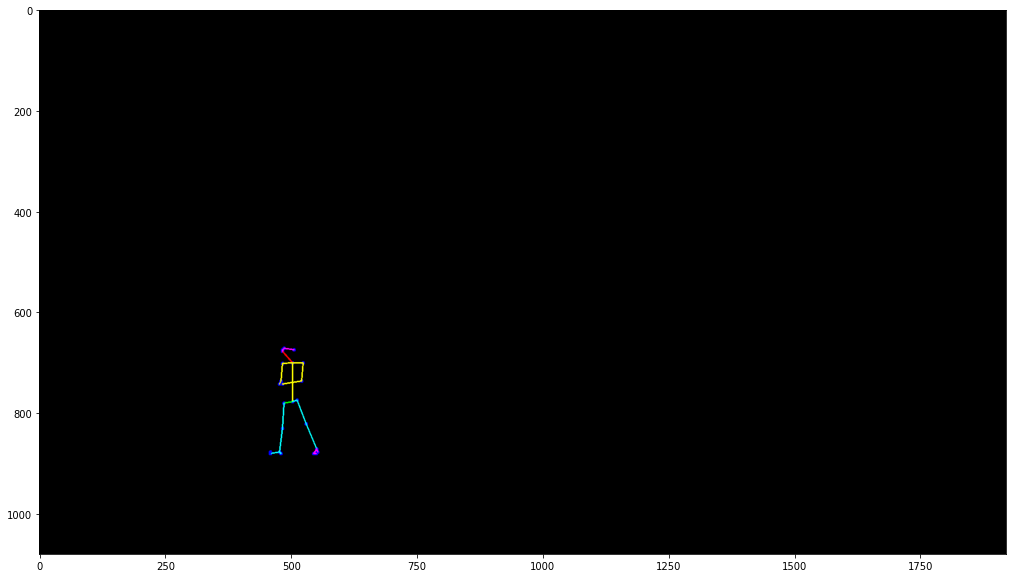

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


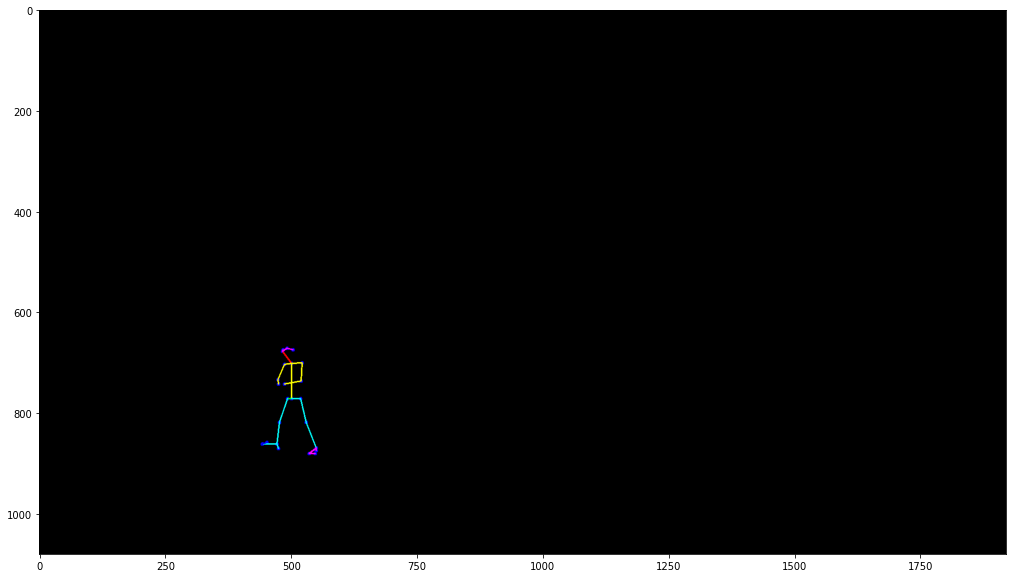

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


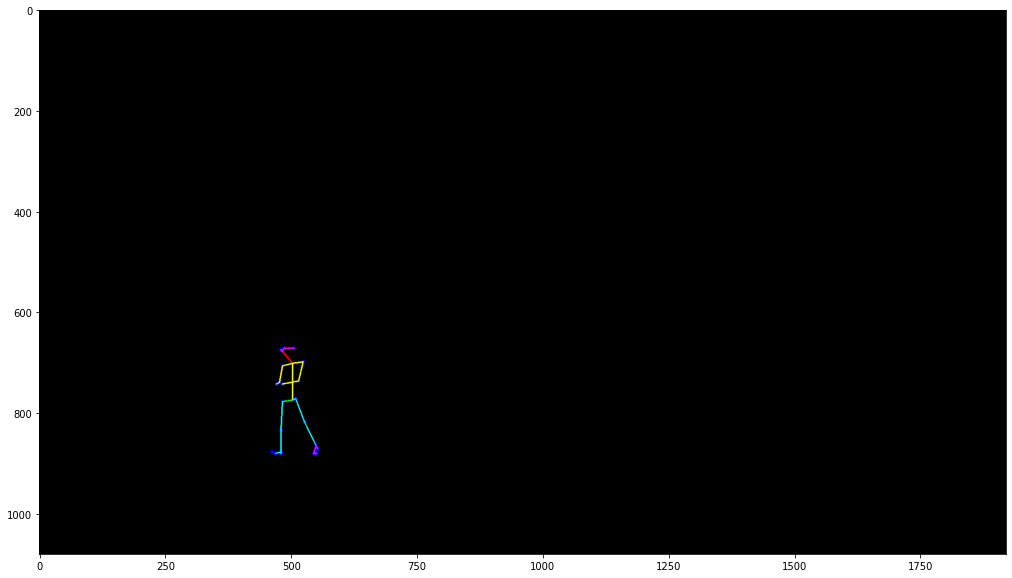

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


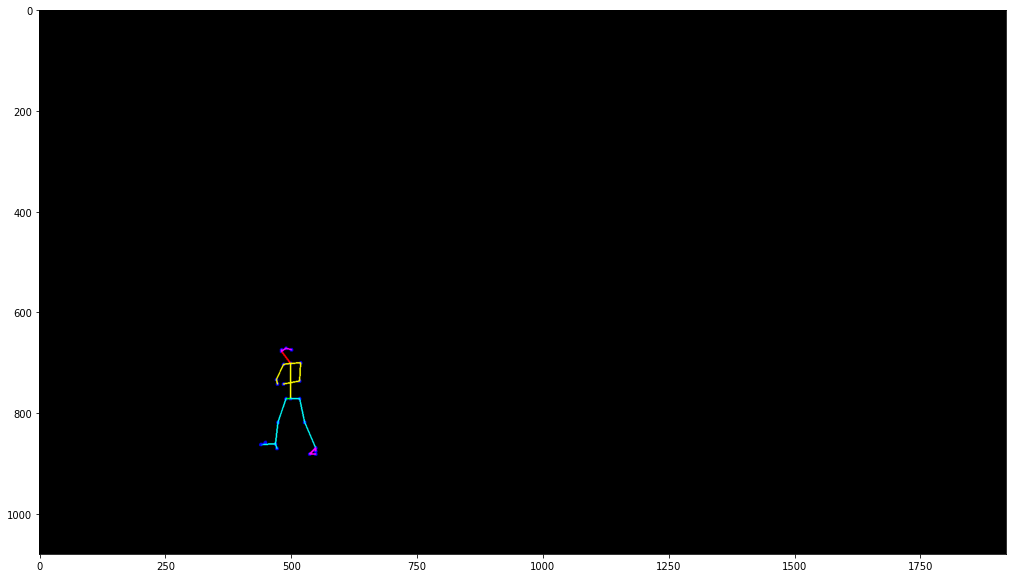

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


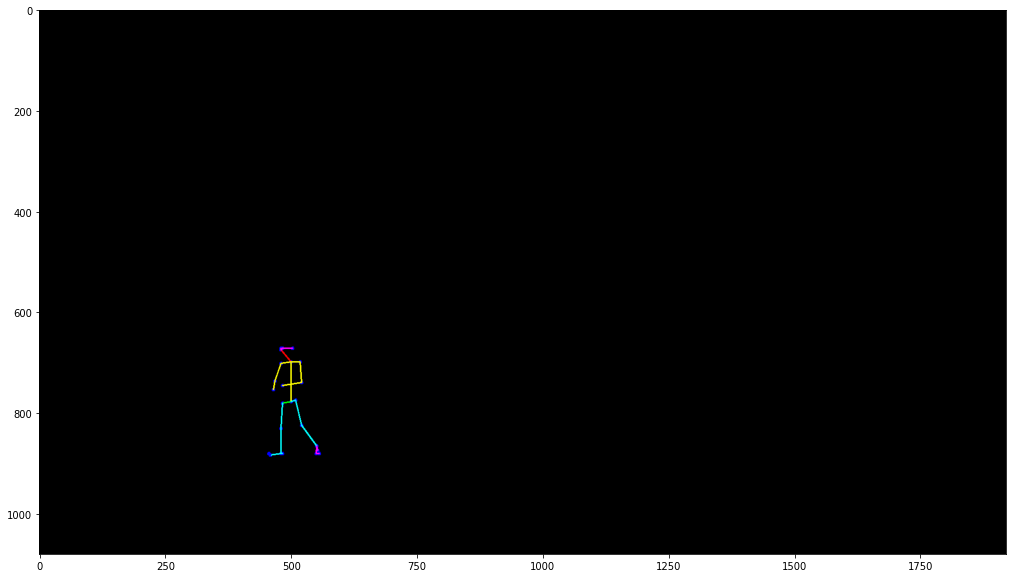

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


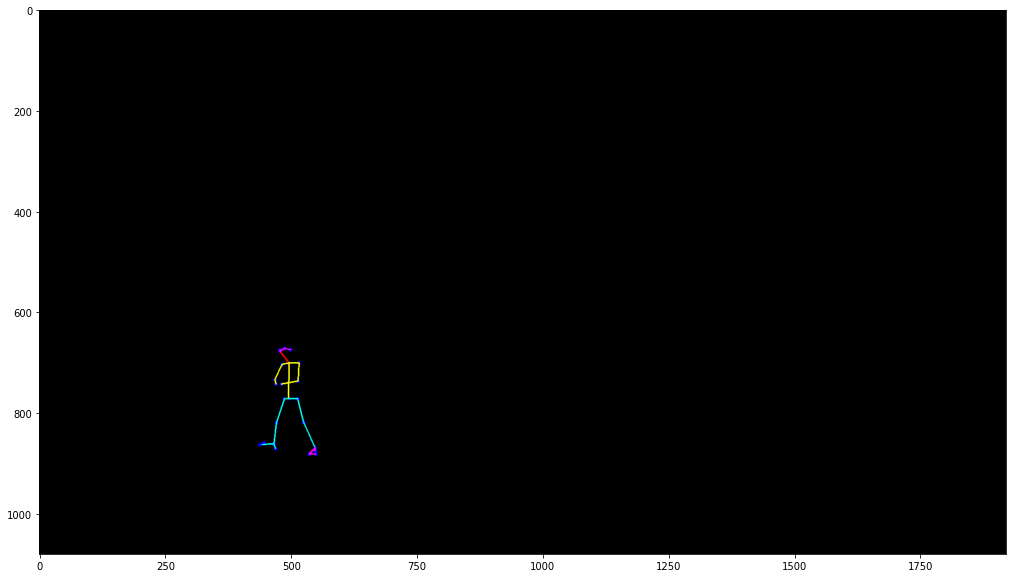

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


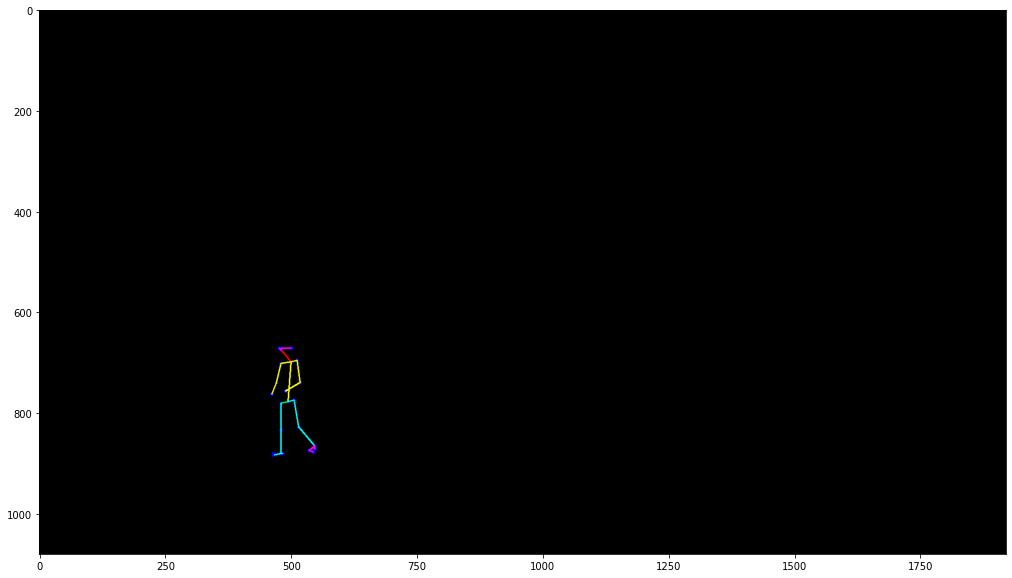

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


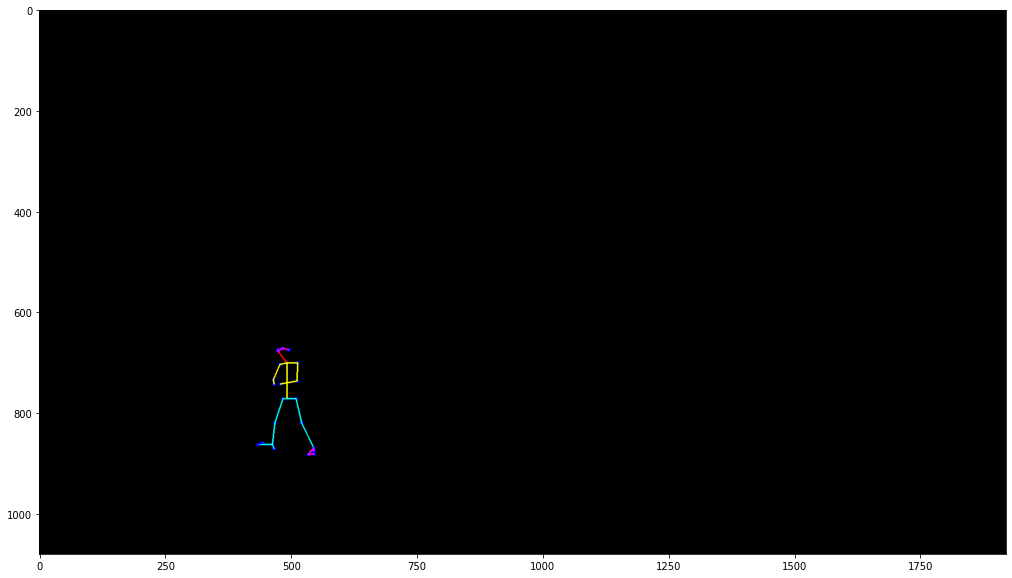

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


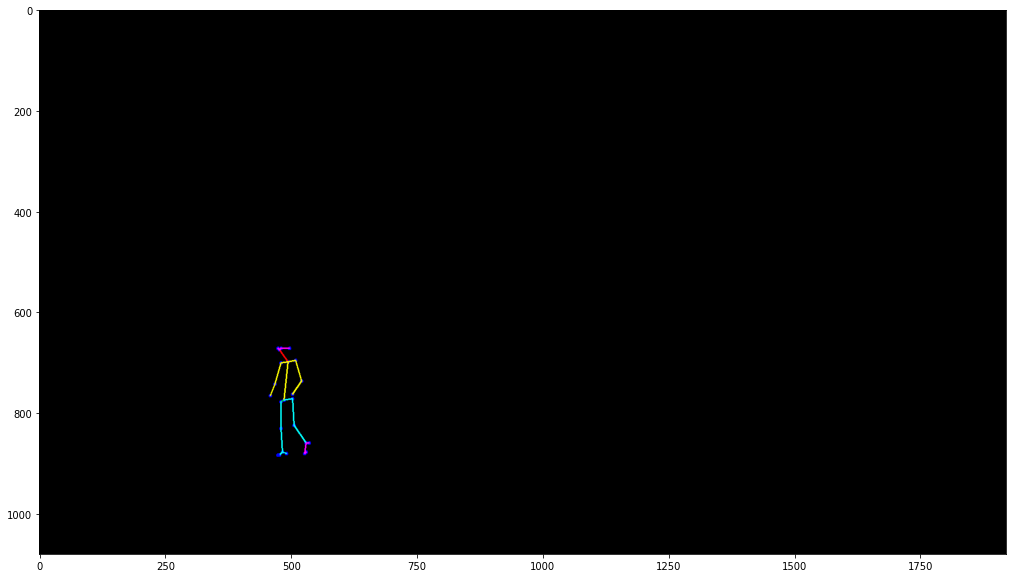

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


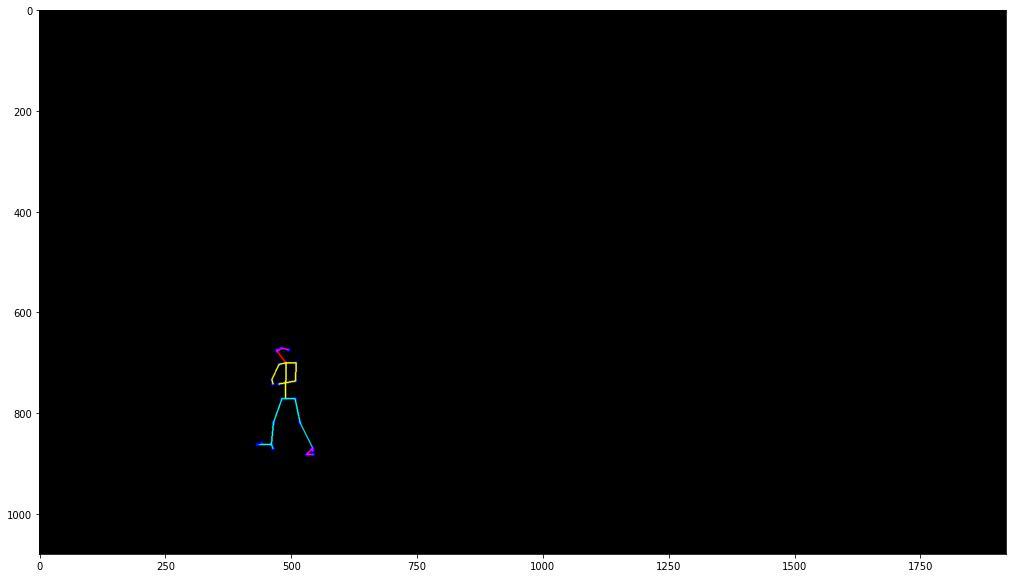

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


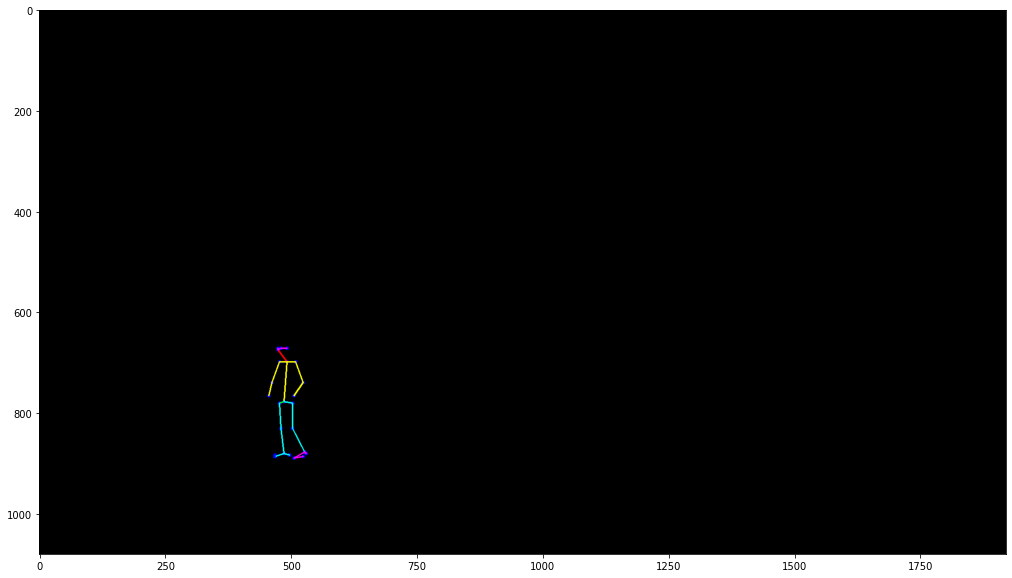

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


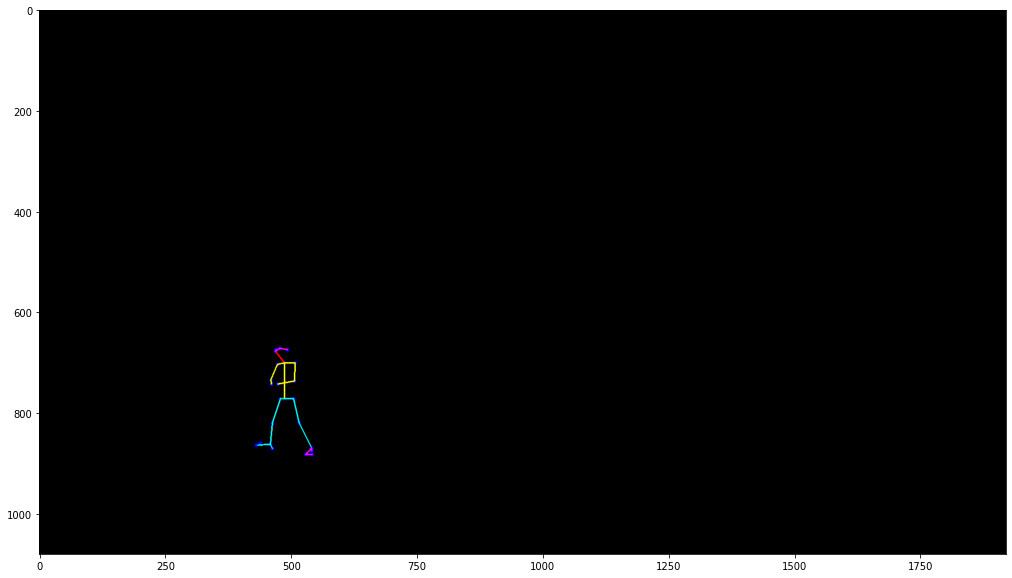

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


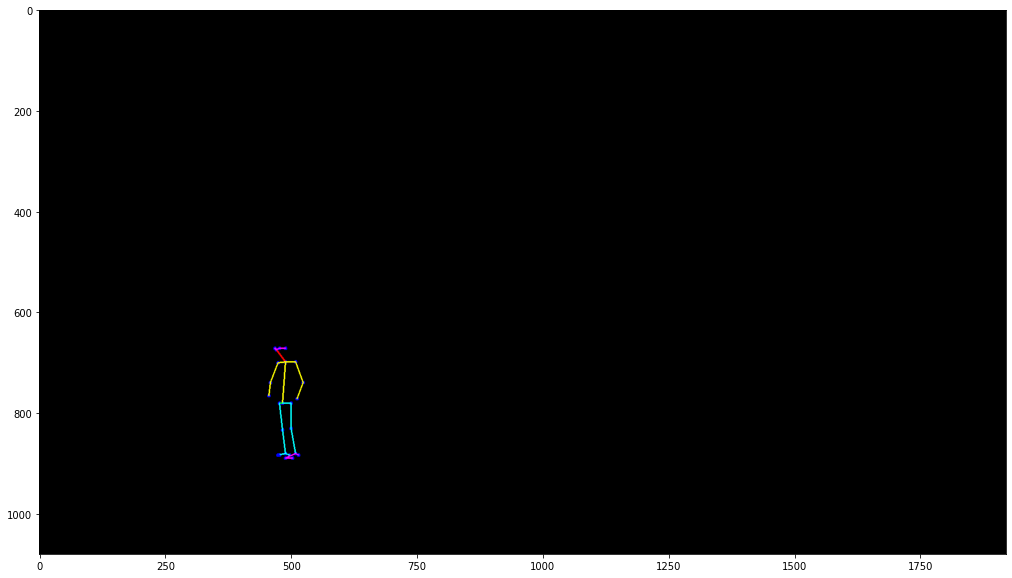

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


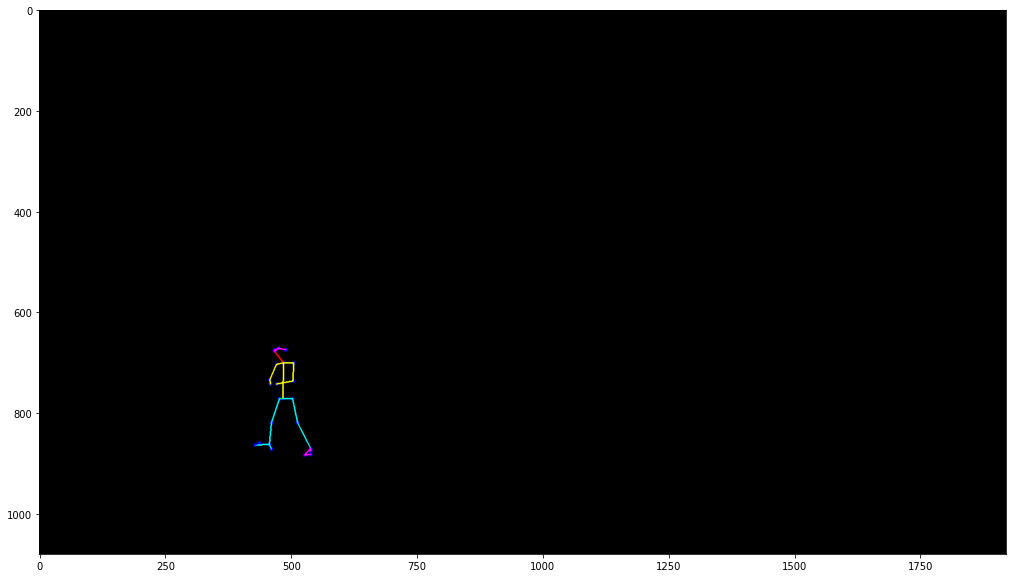

(25, 2)
(25, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


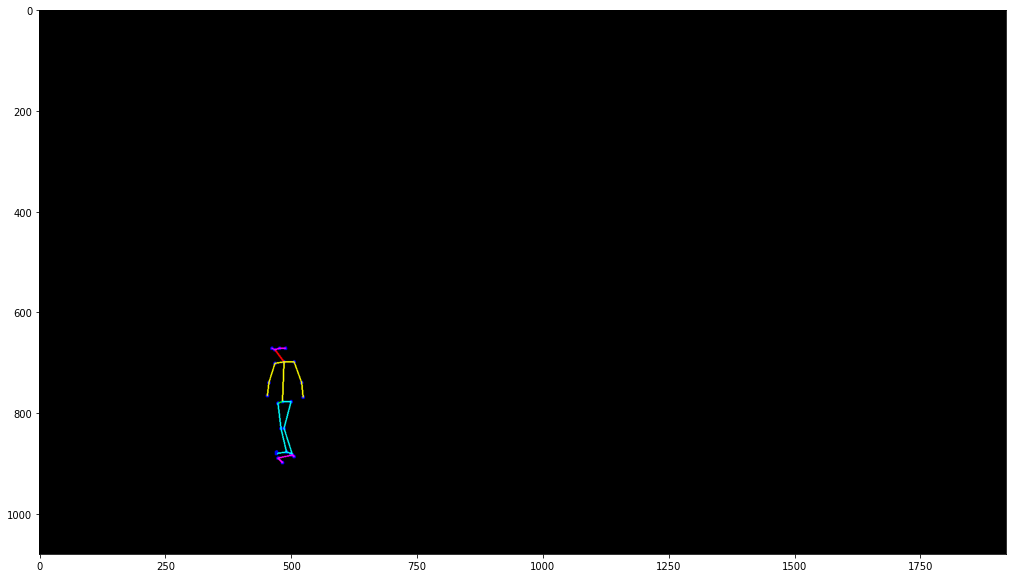

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


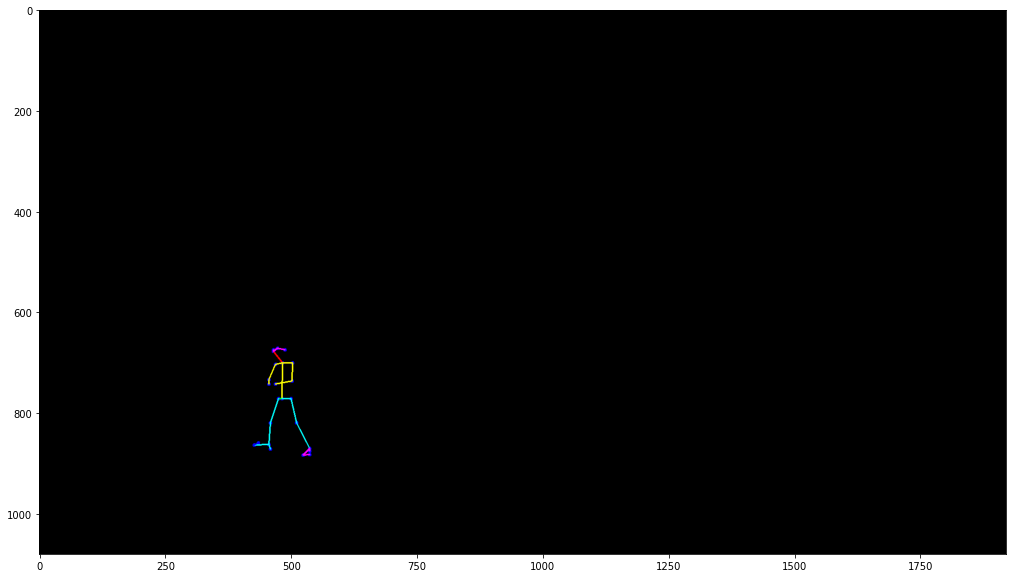

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


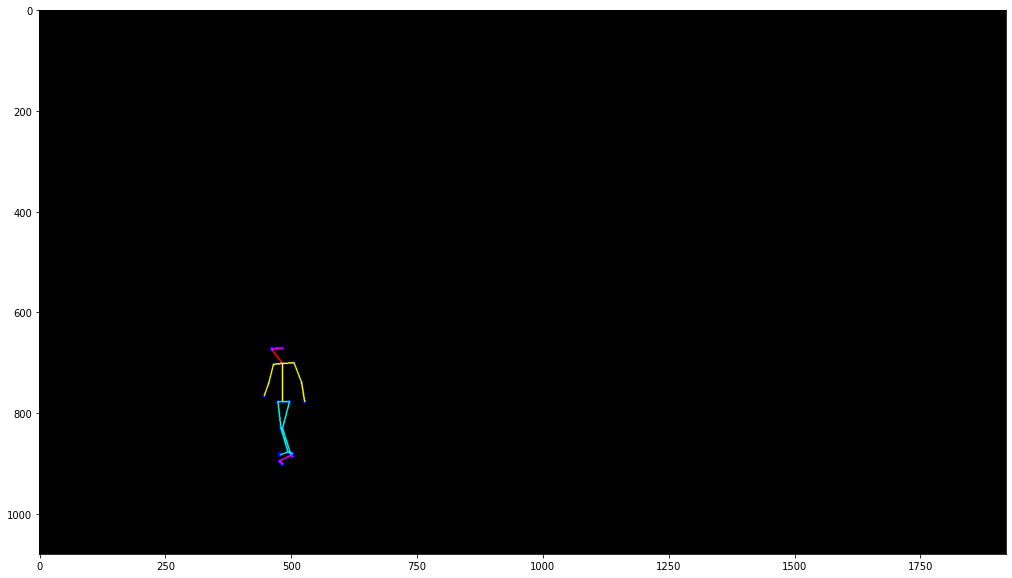

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


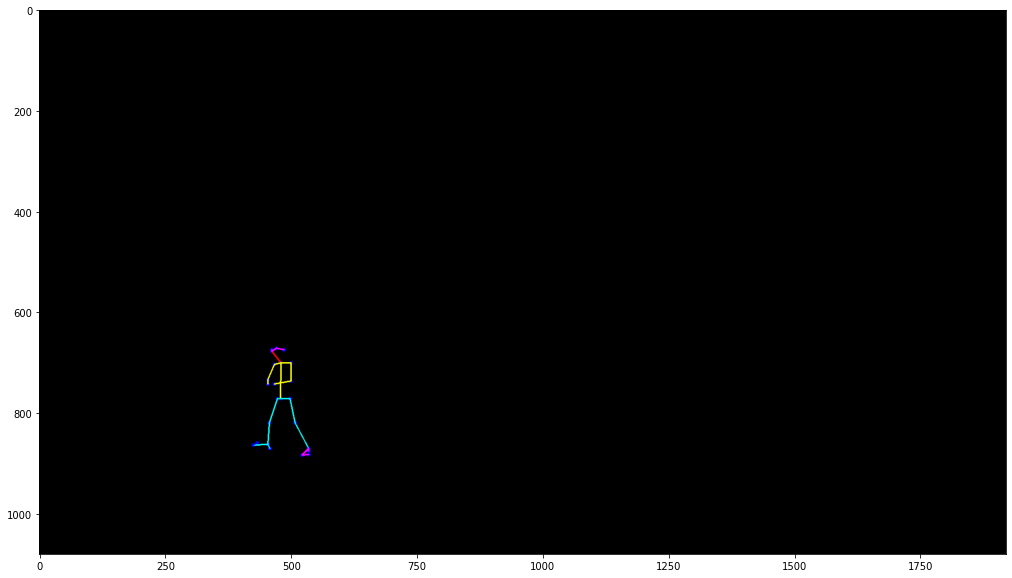

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


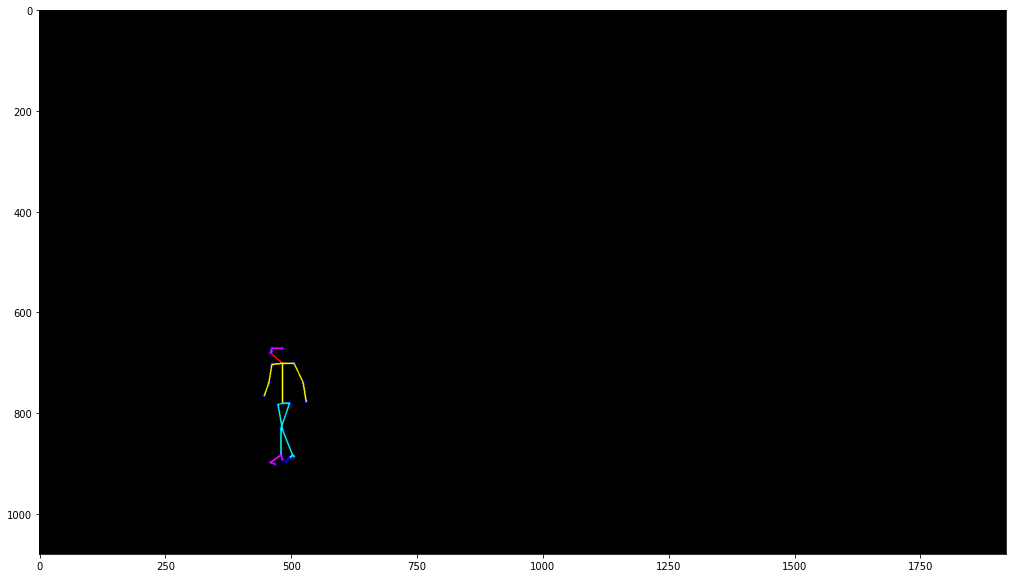

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


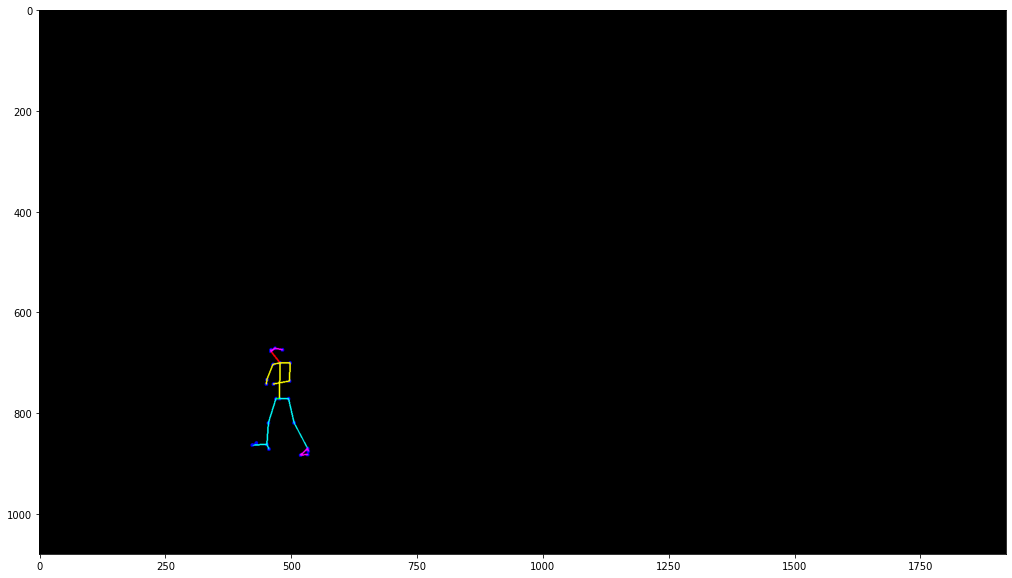

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


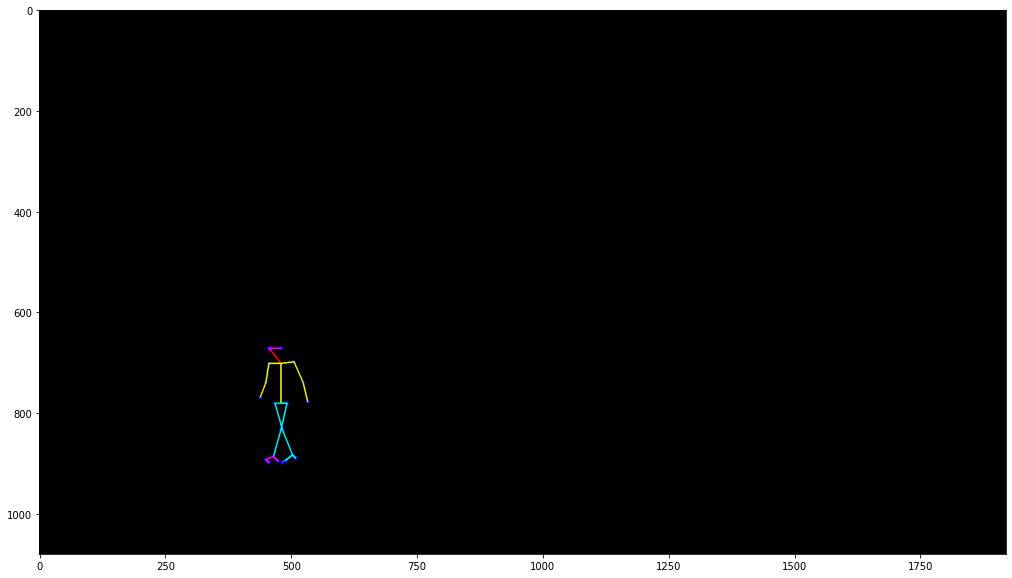

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


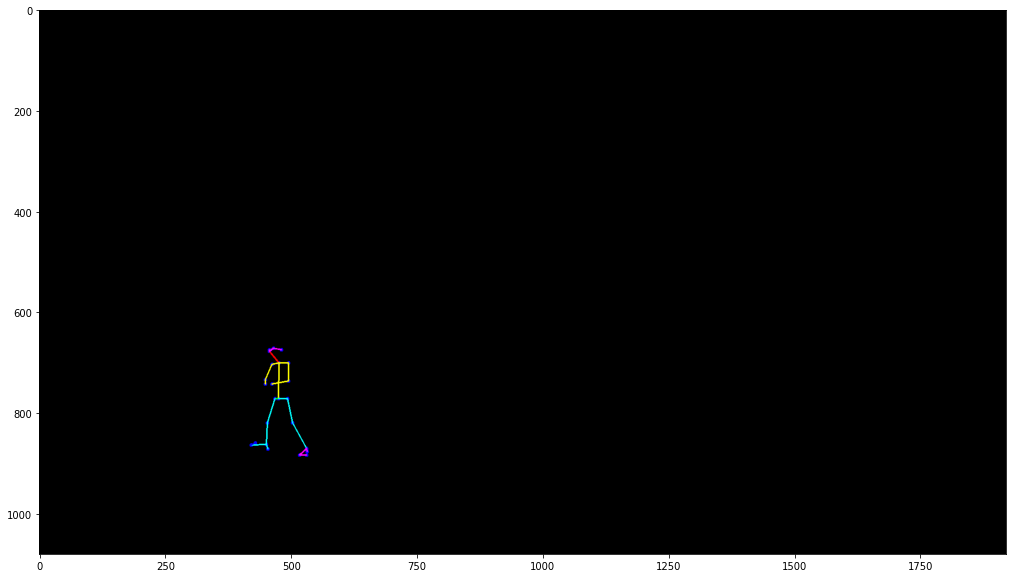

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


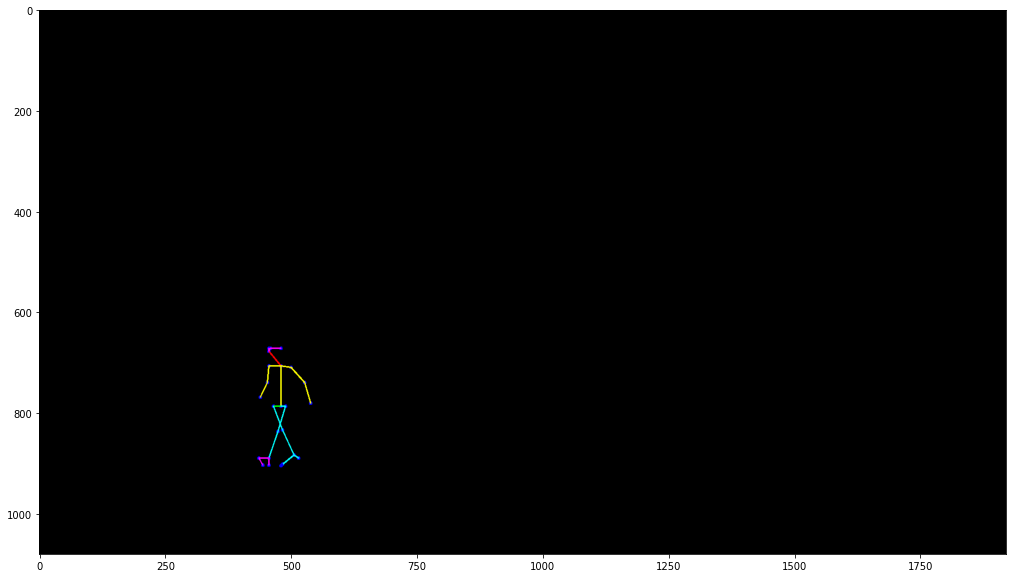

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


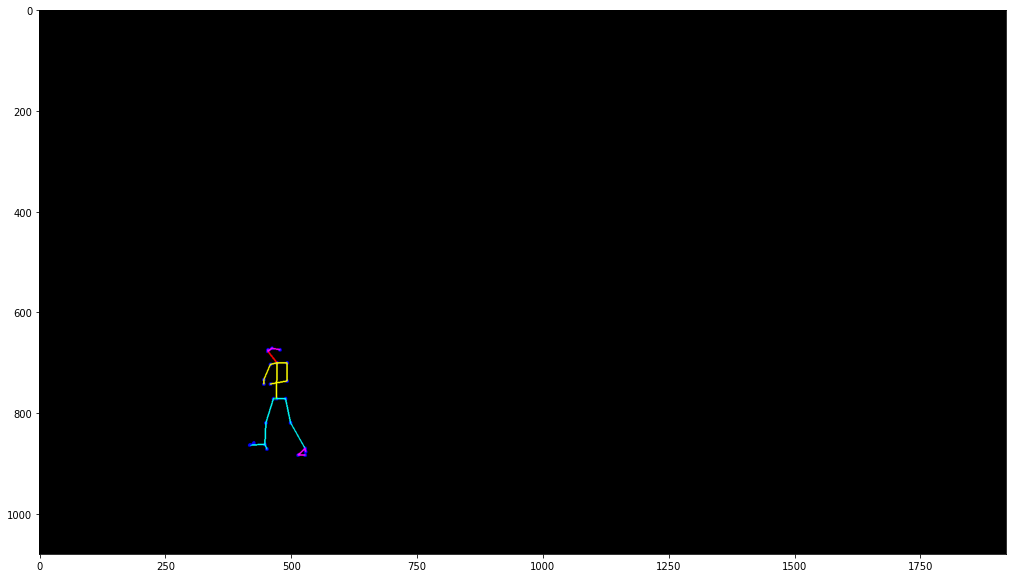

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


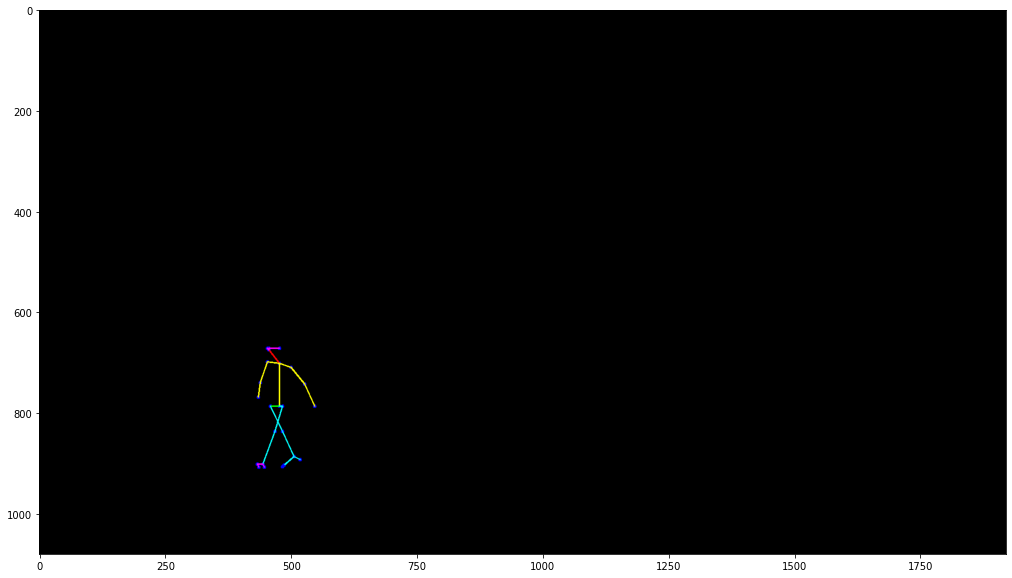

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


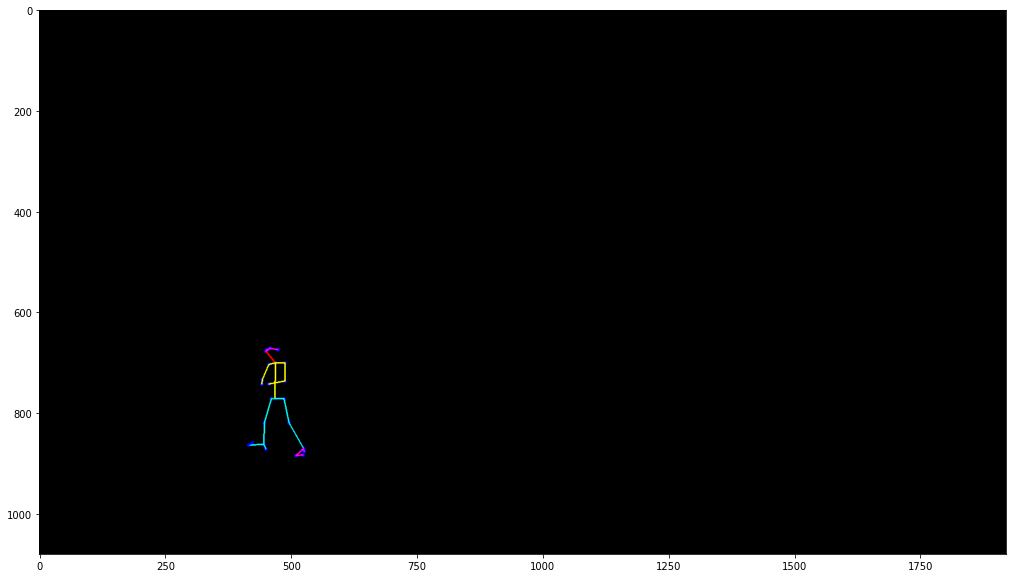

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


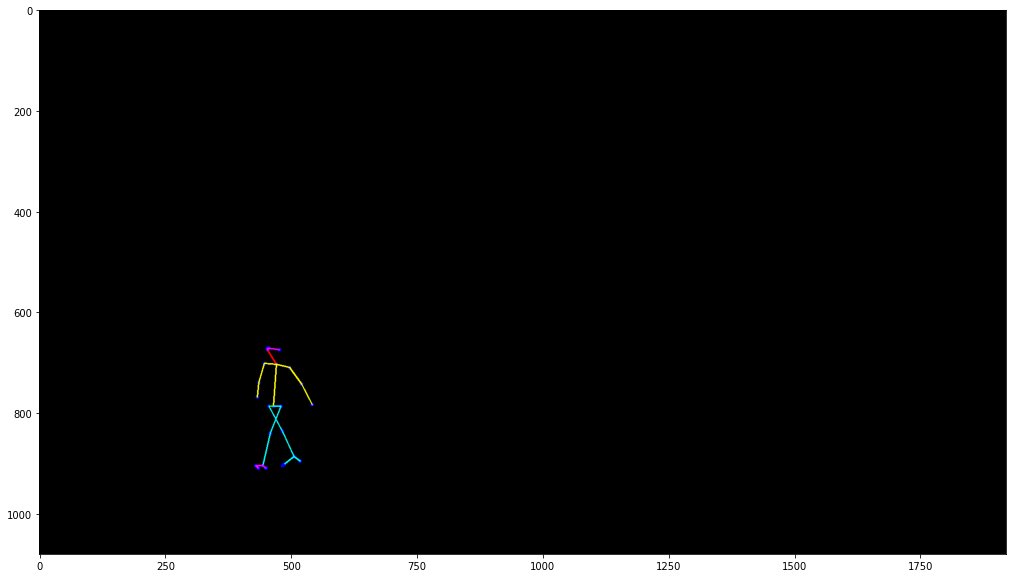

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


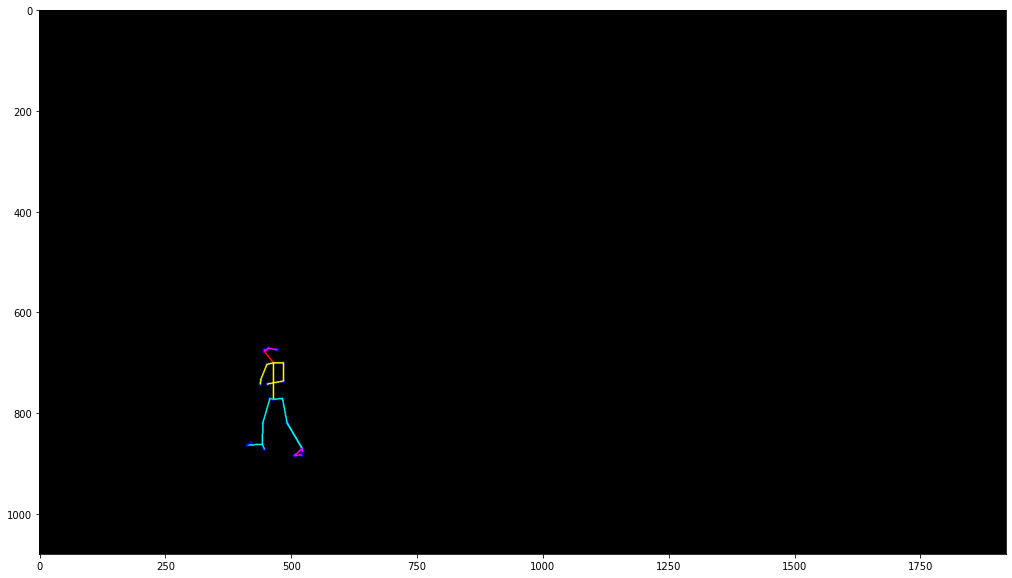

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(25, 2)
(25, 2)


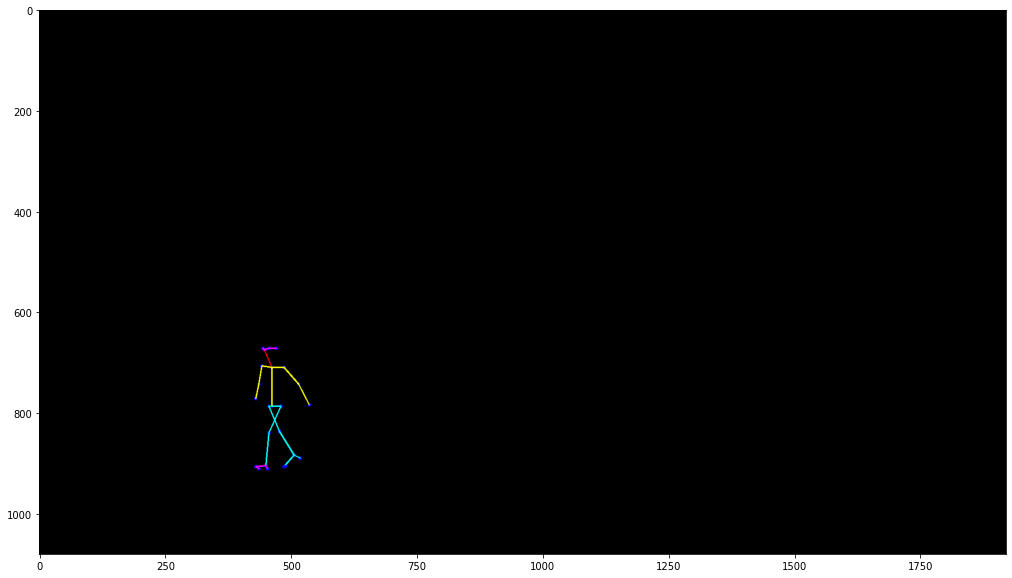

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


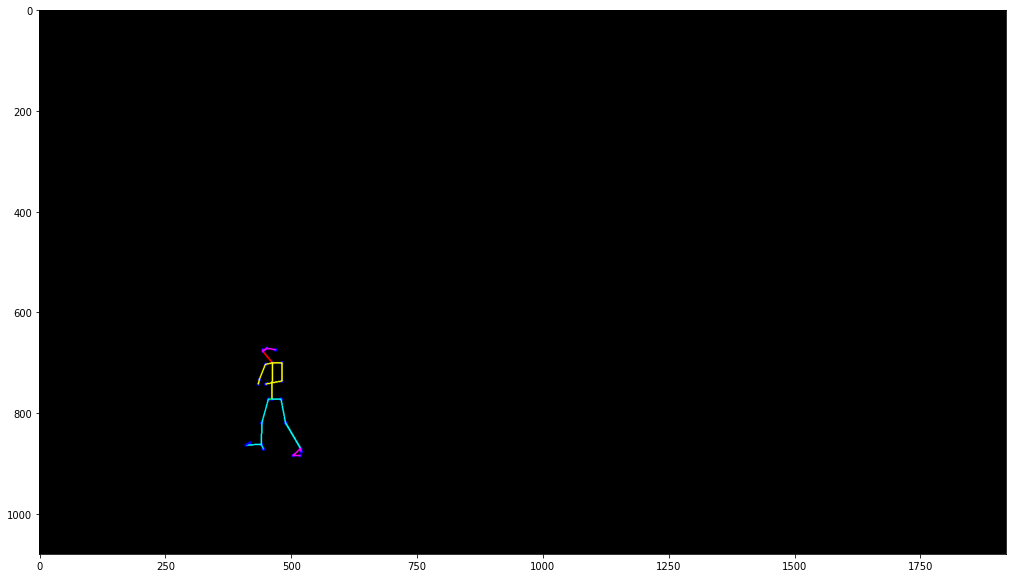

In [86]:
import matplotlib 
plt.rcParams['figure.figsize'] = [20, 10]

   
def draw_keypoints_op(outputs, image_in=None):
        edges = [(0,1),(1,2),(2,3),(3,4),(1,5),(5,6),(6,7),(1,8),(8,9),(8,12),(9,10),(10,11),(12,13),(13,14),(11,24),(11,22),(22,23),(14,21),(14,19),(19,20),(0,15),(0,16),(15,17),(16,18)]

        image=np.zeros((1080,1920,3))
#     for i in range(len(outputs)):
        keypoints = outputs
        
        keypoints = keypoints.reshape(-1, 2)
        print(keypoints.shape)
        for p in range(keypoints.shape[0]):
            # draw the keypoints
            if( not(keypoints[p,0]<=0 and keypoints[p,1]<=0)):
              cv2.circle(image, (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                        3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)
            
#               cv2.putText(image, f"{p}", (int(keypoints[p, 0]+10), int(keypoints[p, 1]-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
                
        for ie, e in enumerate(edges):
            # get different colors for the edges
            rgb = matplotlib.colors.hsv_to_rgb([
                ie/float(len(edges)), 1.0, 1.0
            ])
            rgb = rgb*255
            # print(keypoints[e, 0][0])
            # join the keypoint pairs to draw the skeletal structure
            if not((keypoints[e, 0][0]<=0 and keypoints[e, 1][0]<=0) or (keypoints[e, 0][1]<=0 and keypoints[e, 1][1]<=0)):
              cv2.line(image, (keypoints[e, 0][0], keypoints[e, 1][0]),
                    (keypoints[e, 0][1], keypoints[e, 1][1]),
                    tuple(rgb), 2, lineType=cv2.LINE_AA)
        
        return image

for idx, (obs_pose, obs_pose_local, target_pose_local, obs_pose_global, target_pose_global, obs_s_l, target_s_l, obs_s_g, target_s_g, target_s, target) in enumerate(train_loader):
      
        obs_pose = obs_pose.to(device='cuda')
        obs_pose_local = obs_pose_local.to(device='cuda')
        target_pose_local = target_pose_local.to(device='cuda')
        obs_pose_global = obs_pose_global.to(device='cuda')
        target_pose_global = target_pose_global.to(device='cuda')
        obs_s_l  = obs_s_l.to(device='cuda')
        target_s_l = target_s_l.to(device='cuda')
        obs_s_g  = obs_s_g.to(device='cuda')
        target_s_g = target_s_g.to(device='cuda')
        target_s = target_s.to(device='cuda')
        target_pose = target.to(device='cuda')
        
        (speed_preds,global_preds,target_preds) = net(pose_local=obs_pose_local, vel_local=obs_s_l, pose_glob=obs_pose_global, vel_glob=obs_s_g)
            
        preds_p = speed2pos(target_preds, obs_pose)
#         print(speed_preds[23])
#         print(target_pose.shape)
        for i in range(16):
            actual=target_pose[12][i].detach().cpu().numpy()
            pred=preds_p[12][i].detach().cpu().numpy()
            
            x1=draw_keypoints_op(actual.astype(int))
            x2=draw_keypoints_op(pred.astype(int))
            
#             f, axarr = plt.subplots(1,2)
            plt.imshow(x1)
            plt.show()
            plt.imshow(x2)
            plt.show()
            

        
        break

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]

for idx, (obs_s, target_s, obs_pose, target_pose, obs_pose_global, target_pose_global, obs_s_g, target_s_g, target) in enumerate(val_loader):
    print("SAMPLE",idx,"."*50)
    
    obs_s = obs_s.to(device='cuda')
    target_s = target_s.to(device='cuda')
    obs_pose    = obs_pose.to(device='cuda')
    target_pose = target_pose.to(device='cuda')
    obs_pose_global = obs_pose_global.to(device='cuda')
    target_pose_global = target_pose_global.to(device='cuda')
    obs_s_g  = obs_s_g.to(device='cuda')
    target_s_g = target_s_g.to(device='cuda')
    target = target.to(device='cuda')
    
#     im2=draw_keypoints_op((obs_pose[0,0].reshape(-1,17,2)+obs_pose_global[0,0].reshape(-1,1,2)).reshape(-1,34))
#     plt.imshow(im2)
#     plt.show()
        
    (speed_preds,global_preds) = net(pose=obs_pose, vel=obs_s, pose_glob=obs_pose_global, vel_glob=obs_s_g)
    
#     vv=(obs_pose[0,-1].reshape(-1,17,2)+obs_pose_global[0,-1].reshape(-1,1,2)+speed_preds[0,0].reshape(-1,17,2)+global_preds[0,0].reshape(-1,1,2)).reshape(-1,34)
#     im2=draw_keypoints_op(vv)
#     plt.imshow(im2)
#     plt.show()
    
# #     print(target.size(),vv.size())
#     im2=draw_keypoints_op(target[0,0:1])
#     plt.imshow(im2)
#     plt.show()

    preds_p = speed2pos_glob(speed_preds, global_preds, obs_pose, obs_pose_global).detach().cpu().numpy()
    
    for cnt in range(2):
        print("expected","."*100)
        for i in range(15): 
          obs_p=target[cnt:cnt+1,i]
          im2=draw_keypoints_op(obs_p)
          plt.imshow(im2)
          plt.show()
    
        print("predicted","."*100)
        for i in range(15): 
          expected_pose=preds_p[cnt:cnt+1,i]
          im2=draw_keypoints_op(expected_pose)
          plt.imshow(im2)
          plt.show()
        
        
    
    break


     

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms


class PV_LSTM_DE_op(nn.Module):
    def __init__(self, args):
        '''
           input: observed body poses and velocites global and local
           output: global and local velocities
        '''
        super(PV_LSTM_DE_op, self).__init__()
         
        self.pose_encoder = nn.LSTM(input_size=50, hidden_size=args.hidden_size)
        self.vel_encoder = nn.LSTM(input_size=50, hidden_size=args.hidden_size)
        self.vel_decoder = nn.LSTMCell(input_size=50, hidden_size=args.hidden_size)
        self.fc_vel    = nn.Linear(in_features=args.hidden_size, out_features=50)
        
        self.pose_glob_encoder = nn.LSTM(input_size=2, hidden_size=100)
        self.vel_glob_encoder = nn.LSTM(input_size=2, hidden_size=100)
        self.vel_glob_decoder = nn.LSTMCell(input_size=2, hidden_size=100)
        self.fc_global    = nn.Linear(in_features=100, out_features=2)
        
        
        
        self.hardtanh = nn.Hardtanh(min_val=-1*args.hardtanh_limit,max_val=args.hardtanh_limit)
        self.relu = nn.ReLU() 
        self.softmax = nn.Softmax(dim=1)
        
        
        self.args = args
        
    def forward(self, pose=None, vel=None, pose_glob=None, vel_glob=None):


        _, (hidden_vel, cell_vel) = self.vel_encoder(vel.permute(1,0,2))
        hidden_vel = hidden_vel.squeeze(0)
        cell_vel = cell_vel.squeeze(0)


        _, (hidden_pose, cell_pose) = self.pose_encoder(pose.permute(1,0,2))
        hidden_pose = hidden_pose.squeeze(0)
        cell_pose = cell_pose.squeeze(0)
        
        outputs = []
        
      
        #predicting the velocity of poses and poses
        vel_outputs    = torch.tensor([], device=self.args.device)
        #pose_outputs   = torch.tensor([], device=self.args.device)
        glob_outputs    = torch.tensor([], device=self.args.device)

        VelDec_inp = vel[:,-1,:]
        #PoseDec_inp = pose[:,-1,:]
        
        hidden_dec = hidden_pose + hidden_vel
        cell_dec = cell_pose + cell_vel
        for i in range(self.args.output//self.args.skip):
            hidden_dec, cell_dec = self.vel_decoder(VelDec_inp, (hidden_dec, cell_dec))
            vel_output  = self.hardtanh(self.fc_vel(hidden_dec))
            vel_outputs = torch.cat((vel_outputs, vel_output.unsqueeze(1)), dim = 1)
            VelDec_inp  = vel_output.detach()
          
        outputs.append(vel_outputs)
        
        _, (hidden_vel_glob, cell_vel_glob) = self.vel_glob_encoder(vel_glob.permute(1,0,2))
        hidden_vel_glob = hidden_vel_glob.squeeze(0)
        cell_vel_glob = cell_vel_glob.squeeze(0)
        
        _, (hidden_pose_glob, cell_pose_glob) = self.pose_glob_encoder(pose_glob.permute(1,0,2))
        hidden_pose_glob = hidden_pose_glob.squeeze(0)
        cell_pose_glob = cell_pose_glob.squeeze(0)
        
        glob_inp = pose_glob[:,-1,:]
        
        hidden_glob = hidden_pose_glob + hidden_vel_glob
        cell_glob = cell_pose_glob + cell_vel_glob
        for i in range(self.args.output//self.args.skip):
            hidden_glob, cell_glob = self.vel_glob_decoder(glob_inp, (hidden_glob, cell_glob))
            glob_output  = self.fc_global(hidden_glob)
            glob_outputs = torch.cat((glob_outputs, glob_output.unsqueeze(1)), dim = 1)
            glob_inp  = glob_output.detach()
       
        outputs.append(glob_outputs)
        
       
        return tuple(outputs)


class myDataset_DE_op(torch.utils.data.Dataset):
    def __init__(self, args, dtype):
        
        self.args = args
        self.dtype = dtype
        print("Loading",self.dtype)
        
#         sequence_centric = pd.read_csv("sequences_openpifpaf_"+self.dtype+".csv")
        sequence_centric = pd.read_csv("sequences_16_overlap_4_thres4_"+self.dtype+".csv")

        df = sequence_centric.copy()      
        for v in list(df.columns.values):
            print(v+' loaded')
            try:
                df.loc[:,v] = df.loc[:, v].apply(lambda x: literal_eval(x))
            except:
                continue
        sequence_centric[df.columns] = df[df.columns]
        self.data = sequence_centric.copy().reset_index(drop=True)
    
        print('*'*30)
        

    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):

        seq = self.data.iloc[index]
        outputs = []

        obs = torch.tensor([seq.Pose[i] for i in range(0,self.args.input,self.args.skip)])        
        obs_speed = (obs[1:] - obs[:-1])
        
        true = torch.tensor([seq.Future_Pose[i] for i in range(0,self.args.output,self.args.skip)])
        true_speed = torch.cat(((true[0]-obs[-1]).unsqueeze(0), true[1:]-true[:-1]))
        
        outputs.append(obs_speed)
        outputs.append(true_speed)
        #obs and future global avg of joint 5 & 6 (0 indexed) for openpifpaf
        #local = obs pose-global  for openpifpaf
        #do serparately for x and y
        obs_resh = torch.reshape(obs, (obs.size()[0],25,2))
        
        obs_global=obs_resh[:,1]
        obs_global=obs_global.unsqueeze(1)

        obs_resh=obs_resh-obs_global
    
#         print("-"*100,"\n",obs)
#         print("-"*100,"\n",obs_resh)
#         print("-"*100,"\n",obs_global)
#         print("-"*100,"\n",obs_resh+obs_global)
    
        obs_resh=obs_resh.reshape(obs.size())
        
        true_resh = torch.reshape(true, (true.size()[0],25,2))
        true_global=true_resh[:,1]
        true_global=true_global.unsqueeze(1)
#         print(obs_resh.size(),obs_global.size())
        true_resh=true_resh-true_global
        true_resh=true_resh.reshape(true.size())
        
        obs_global=torch.reshape(obs_global, (obs.size()[0],2))
        true_global=torch.reshape(true_global, (true.size()[0],2))
        
        obs_global_speed = (obs_global[1:] - obs_global[:-1])
        true_global_speed = torch.cat(((true_global[0]-obs_global[-1]).unsqueeze(0), true_global[1:]-true_global[:-1]))
        
#         print(obs_resh.size(),true_resh.size(),obs_global.size(),true_global.size())
        
        outputs.append(obs_resh)
        outputs.append(true_resh)
        outputs.append(obs_global)
        outputs.append(true_global)
        outputs.append(obs_global_speed)
        outputs.append(true_global_speed)
        outputs.append(true)
#         print(obs_resh.size())
#         obs_y_global=(obs_resh[:,5,1]+obs_resh[:,6,1])/2.0
#         print(obs_global.size())
#         print(obs_global)
#         print(obs_y_global)
        
#         print(obs.size(),obs_resh.size())
#         obs_global= torch.mean(obs[:,5:7],dim=1).unsqueeze(1)
#         print(obs_global)
#         obs=obs-obs_global
#         print(obs)
#         true_global=torch.mean(true[:,5:7],dim=1).unsqueeze(1)
#         true=true-true_global
       
        
        
        return tuple(outputs)    
    
    
def data_loader_DE_op(args,data):
    dataset = myDataset_DE_op(args,data)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=args.batch_size, shuffle=args.loader_shuffle,
        pin_memory=args.pin_memory)

    return dataloader

#Interpolation

In [30]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import utils
from sklearn.metrics import recall_score, accuracy_score, average_precision_score, precision_score

# import DataLoader
# import network
# import utils

class args():
    def __init__(self):
        self.jaad_dataset = '/data/smailait-data/JAAD/processed_annotations' #folder containing parsed jaad annotations (used when first time loading data)
        self.dtype        = 'train'
        self.from_file    = False #read dataset from csv file or reprocess data
        self.save         = True
        self.file         = '/data/smailait-data/jaad_train_16_16.csv'
        self.save_path    = '/data/smailait-data/jaad_train_16_16.csv'
        self.model_path    = '/data/smailait-data/models/multitask_pv_lstm_trained.pkl'
        self.loader_workers = 1
        self.loader_shuffle = True
        self.pin_memory     = False
        self.image_resize   = [240, 426]
        self.device         = 'cuda'
        self.batch_size     = 50
        self.n_epochs       = 250
        self.hidden_size    = 1200
        self.hardtanh_limit = 100
        self.input  = 16
        self.output = 16
        self.stride = 16
        self.skip   = 1
        # self.task   = 'bounding_box-intention'
        self.task   = 'pose'
        self.use_scenes = False       
        self.lr = 0.03
        
args = args()

# net = PV_LSTM(args).to(args.device)
net = PV_LSTM_DE_op(args).to(args.device)
# train = DataLoader.data_loader(args)
# args.dtype = 'val'
# args.save_path = args.save_path.replace('train', 'val')
# args.file = args.file.replace('train', 'val')
# val = DataLoader.data_loader(args)

optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, 
                                                 threshold = 1e-8, verbose=True)
mse = nn.MSELoss()
l1e = nn.L1Loss()
bce = nn.BCELoss()
train_s_scores = []
train_pose_scores=[]
val_pose_scores=[]
train_c_scores = []
val_s_scores   = []
val_c_scores   = []
train_g_scores = []
val_g_scores   = []

train_loader=data_loader_DE_op(args,"train")
val_loader=data_loader_DE_op(args,"val" )

def speed2pos_glob_op(preds, glob_pred, obs_p, obs_global) :
    pred_pos = torch.zeros(preds.shape[0], preds.shape[1], 50).to('cuda')

    current = (obs_p[:,-1,:].reshape(-1,25,2)+ obs_global[:,-1,:].reshape(-1,1,2)).reshape(-1,50)
    
    for i in range(preds.shape[1]):
        pred_pos[:,i,:] = ((current + preds[:,i,:]).reshape(current.size()[0],25,2)+glob_pred[:,i,:].reshape(-1,1,2)).reshape(-1,50)
        current = pred_pos[:,i,:]
        
    for i in range(34):
        pred_pos[:,:,i] = torch.min(pred_pos[:,:,i], 1920*torch.ones(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
        pred_pos[:,:,i] = torch.max(pred_pos[:,:,i], torch.zeros(pred_pos.shape[0], pred_pos.shape[1], device='cuda'))
        
    return pred_pos


optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, 
                                                 threshold = 1e-8, verbose=True)
print('='*100)
print('Training ...')
alpha=0.2

for epoch in range(args.n_epochs):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    avg_epoch_train_g_loss   = 0
    avg_epoch_val_g_loss     = 0 
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    
    for idx, (obs_s, target_s, obs_pose, target_pose, obs_pose_global, target_pose_global, obs_s_g, target_s_g, target) in enumerate(train_loader):
        counter += 1        
        
#         print(obs_s.size(), target_s.size(), obs_pose.size(), target_pose.size(), obs_global.size(), target_global.size())
        
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        obs_pose_global = obs_pose_global.to(device='cuda')
        target_pose_global = target_pose_global.to(device='cuda')
        obs_s_g  = obs_s_g.to(device='cuda')
        target_s_g = target_s_g.to(device='cuda')
        target = target.to(device='cuda')
        
        net.zero_grad()
    
        (speed_preds,global_preds) = net(pose=obs_pose, vel=obs_s, pose_glob=obs_pose_global, vel_glob=obs_s_g)

#         speed_loss  = mse(speed_preds, target_s)
#         global_loss =  mse(global_preds, target_s_g)
        
        speed_loss  = l1e(speed_preds, target_s)
        global_loss =  l1e(global_preds, target_s_g)
    
        loss = (1-alpha)*speed_loss + alpha*global_loss
        loss.backward()
    
        preds_p = speed2pos_glob_op(speed_preds, global_preds, obs_pose, obs_pose_global) 
    
        ade_train += float(ADE_c_op(preds_p, target))
        fde_train += float(FDE_c_op(preds_p, target))
        
        optimizer.step()
        
        avg_epoch_train_s_loss += float(speed_loss)
        avg_epoch_train_g_loss += float(global_loss)
        
    avg_epoch_train_s_loss /= counter
    avg_epoch_train_g_loss /= counter
    ade_train  /= counter
    fde_train  /= counter   
    train_s_scores.append(avg_epoch_train_s_loss)
    train_g_scores.append(avg_epoch_train_g_loss)
    counter=0
    

    for idx, (obs_s, target_s, obs_pose, target_pose, obs_pose_global, target_pose_global, obs_s_g, target_s_g, target) in enumerate(val_loader):
        counter+=1
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        obs_pose_global = obs_pose_global.to(device='cuda')
        target_pose_global = target_pose_global.to(device='cuda')
        obs_s_g  = obs_s_g.to(device='cuda')
        target_s_g = target_s_g.to(device='cuda')
        target = target.to(device='cuda')
        
        
        with torch.no_grad():
            (speed_preds,global_preds) = net(pose=obs_pose, vel=obs_s, pose_glob=obs_pose_global, vel_glob=obs_s_g)

            speed_loss  = l1e(speed_preds, target_s)
            global_loss =  l1e(global_preds, target_s_g)
            loss = (1-alpha)*speed_loss + alpha*global_loss
            avg_epoch_val_s_loss += float(speed_loss)
            avg_epoch_val_g_loss += float(global_loss)
            
            preds_p = speed2pos_glob_op(speed_preds, global_preds, obs_pose, obs_pose_global) 
            
            ade += float(ADE_c_op(preds_p, target))
            fde += float(FDE_c_op(preds_p, target))

        
    avg_epoch_val_s_loss /= counter
    avg_epoch_val_g_loss /= counter
    val_s_scores.append(avg_epoch_val_s_loss)
    val_g_scores.append(avg_epoch_val_g_loss)
    
    ade  /= counter
    fde  /= counter     
    
    scheduler.step(loss)
    
     
    print('e:', epoch, '| ts: %.4f'% avg_epoch_train_s_loss, '| tg: %.4f'% avg_epoch_train_g_loss, '| vs: %.4f'% avg_epoch_val_s_loss, '| vg: %.4f'% avg_epoch_val_g_loss, '| ade_train: %.4f'% ade_train, '| ade_val: %.4f'% ade, '| fde_train: %.4f'% fde_train,'| fde_val: %.4f'% fde)
#           ,'| t:%.4f'%(time.time()-start))


print('='*100) 
# print('Saving ...')
# torch.save(net.state_dict(), args.model_path)
print('Done !')

ModuleNotFoundError: No module named 'sklearn'

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import torchvision.transforms as transforms


class LSTM_spat(nn.Module):
    def __init__(self, args):
        '''
           input: observed body poses and velocites 
           output: predicted poses(not trained), velocities of poses, and intentions
        '''
        super(LSTM_spat, self).__init__()
        self.encoded_size=10
         
        self.pose_encoder = nn.LSTM(input_size=self.encoded_size, hidden_size=args.hidden_size)
#         self.vel_encoder = nn.LSTM(input_size=34, hidden_size=args.hidden_size)
        
        self.pose_embedding = nn.Sequential(nn.Linear(in_features=args.hidden_size, out_features=300),
                                           nn.ReLU())
        
        self.pose_decoder = nn.LSTMCell(input_size=self.encoded_size, hidden_size=args.hidden_size)
#         self.vel_decoder = nn.LSTMCell(input_size=34, hidden_size=args.hidden_size)

#         self.fc_vel    = nn.Linear(in_features=args.hidden_size, out_features=34)
        self.fc_pose   = nn.Linear(in_features=args.hidden_size, out_features=self.encoded_size)

        
        self.hardtanh = nn.Hardtanh(min_val=-1*args.hardtanh_limit,max_val=args.hardtanh_limit)
        self.relu = nn.ReLU() 
        self.softmax = nn.Softmax(dim=1)
        
        self.enc1= nn.Linear(in_features=34, out_features=300)
        self.enc2 = nn.Linear(in_features=300, out_features=self.encoded_size)
        self.dec = nn.Linear(in_features=self.encoded_size, out_features=34)
        
        self.args = args
        
    def forward(self, pose=None, vel=None, average=False):
        
#         poses=pose.permute(1,0,2)
        pose_encoded = torch.tensor([], device=self.args.device)
        
        for i in range(pose.size()[0]):
#             print(i)
            x = self.relu(self.enc1(self.relu(pose[i])))
            x = self.relu(self.enc2(x))
            pose_encoded = torch.cat((pose_encoded, x.unsqueeze(1)), dim = 1)
        
#         print(pose_encoded.size())
#         _, (hidden_vel, cell_vel) = self.vel_encoder()
#         hidden_vel = hidden_vel.squeeze(0)
#         cell_vel = cell_vel.squeeze(0)

#         print(pose_encoded.shape)
        _, (hidden_pose, cell_pose) = self.pose_encoder(pose_encoded)
        hidden_pose = hidden_pose.squeeze(0)
        cell_pose = cell_pose.squeeze(0)
        
        outputs = []
        pose_outputs   = torch.tensor([], device=self.args.device)
        PoseDec_inp = pose_encoded.permute(1,0,2)[:,-1,:]
#         print(PoseDec_inp.size())
        hidden_dec=hidden_pose
        cell_dec=cell_pose
        for i in range(self.args.output//self.args.skip):
            hidden_dec, cell_dec = self.pose_decoder(PoseDec_inp, (hidden_dec, cell_dec))
            pose_output_encoded  = self.fc_pose(hidden_dec)
            pose_output= self.relu(self.dec(pose_output_encoded))
            pose_outputs = torch.cat((pose_outputs, pose_output.unsqueeze(1)), dim = 1)
            PoseDec_inp  = pose_output_encoded.detach()
        
        #if 'bounding_box' in self.args.task:
        #predicting the velocity of poses and poses
#         vel_outputs    = torch.tensor([], device=self.args.device)
        

#         VelDec_inp = vel[:,-1,:]
        #PoseDec_inp = pose[:,-1,:]
        
#         hidden_dec = hidden_pose + hidden_vel
#         cell_dec = cell_pose + cell_vel
#         for i in range(self.args.output//self.args.skip):
#             hidden_dec, cell_dec = self.vel_decoder(VelDec_inp, (hidden_dec, cell_dec))
#             vel_output  = self.hardtanh(self.fc_vel(hidden_dec))
#             vel_outputs = torch.cat((vel_outputs, vel_output.unsqueeze(1)), dim = 1)
#             VelDec_inp  = vel_output.detach()
            #pose_output = PoseDec_inp + VelDec_inp 
            #pose_outputs = torch.cat((pose_outputs, pose_output.unsqueeze(1)), dim = 1)
            #PoseDec_inp = pose_output
            
#         outputs.append(vel_outputs)
        outputs.append(pose_outputs)

            
        return tuple(outputs)



In [33]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import utils
from sklearn.metrics import recall_score, accuracy_score, average_precision_score, precision_score

# import DataLoader
# import network
# import utils

class args():
    def __init__(self):
        self.jaad_dataset = '/data/smailait-data/JAAD/processed_annotations' #folder containing parsed jaad annotations (used when first time loading data)
        self.dtype        = 'train'
        self.from_file    = False #read dataset from csv file or reprocess data
        self.save         = True
        self.file         = '/data/smailait-data/jaad_train_16_16.csv'
        self.save_path    = '/data/smailait-data/jaad_train_16_16.csv'
        self.model_path    = '/data/smailait-data/models/multitask_pv_lstm_trained.pkl'
        self.loader_workers = 1
        self.loader_shuffle = True
        self.pin_memory     = False
        self.image_resize   = [240, 426]
        self.device         = 'cuda'
        self.batch_size     = 50
        self.n_epochs       = 250
        self.hidden_size    = 1000
        self.hardtanh_limit = 100
        self.input  = 16
        self.output = 16
        self.stride = 16
        self.skip   = 1
        # self.task   = 'bounding_box-intention'
        self.task   = 'pose'
        self.use_scenes = False       
        self.lr = 0.01
        
args = args()

# net = PV_LSTM(args).to(args.device)
net = LSTM_spat(args).to(args.device)
# train = DataLoader.data_loader(args)
# args.dtype = 'val'
# args.save_path = args.save_path.replace('train', 'val')
# args.file = args.file.replace('train', 'val')
# val = DataLoader.data_loader(args)

optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, 
                                                 threshold = 1e-8, verbose=True)
mse = nn.MSELoss()
bce = nn.BCELoss()
l1e = nn.L1Loss()
train_s_scores = []
train_pose_scores=[]
val_pose_scores=[]
train_c_scores = []
val_s_scores   = []
val_c_scores   = []

train_loader=data_loader(args,"train")
val_loader=data_loader(args,"val" )

# state_dict = torch.load('model_best.weight')
# print(state_dict)
with torch.no_grad():
    net.enc1.weight.copy_(state_dict['enc1.weight'])
    net.enc1.bias.copy_(state_dict['enc1.bias'])
    net.enc2.weight.copy_(state_dict['enc2.weight'])
    net.enc2.bias.copy_(state_dict['enc2.bias'])
    net.dec.weight.copy_(state_dict['dec4.weight'])
    net.dec.bias.copy_(state_dict['dec4.bias'])
    net.enc1.requires_grad = False
    net.enc2.requires_grad = False
    net.dec.requires_grad = False
    

Loading train
Pose loaded
Future_Pose loaded
******************************
Loading val
Pose loaded
Future_Pose loaded
******************************


In [25]:

optimizer = optim.Adam(net.parameters(), lr=args.lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=15, 
                                                 threshold = 1e-8, verbose=True)
print('='*100)
print('Training ...')

for epoch in range(args.n_epochs):
    start = time.time()
    
    avg_epoch_train_s_loss = 0
    avg_epoch_val_s_loss   = 0
    avg_epoch_train_p_loss   = 0
    avg_epoch_val_p_loss     = 0 
    ade  = 0
    fde  = 0
    ade_train  = 0
    fde_train  = 0
    counter = 0
    
    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(train_loader):
        counter += 1        
        
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
 
        net.zero_grad()
    
        (pose_preds,) = net(pose=obs_pose)
#         pose_loss  = mse(pose_preds, target_pose)
#         speed_loss  = mse(speed_preds, target_s)
#         print(pose_preds.shape)
        loss  = l1e(pose_preds, target_pose)
    
#         preds_p = speed2pos(speed_preds, obs_pose) 
        ade_train += float(ADE_c(pose_preds, target_pose))
        fde_train += float(FDE_c(pose_preds, target_pose))
        
    
        loss.backward()
#         loss = speed_loss 
#         loss.backward()
        optimizer.step()
        
    
        avg_epoch_train_p_loss += float(loss)
#         avg_epoch_train_p_loss += float(pose_loss)
        
    avg_epoch_train_s_loss /= counter
    train_s_scores.append(avg_epoch_train_s_loss)
    ade_train  /= counter
    fde_train  /= counter    
#     avg_epoch_train_p_loss/=counter
#     train_pose_scores.append(avg_epoch_train_p_loss)
    
    counter=0

    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(val_loader):
        counter+=1
        obs_s    = obs_s.to(device='cuda')
        target_s = target_s.to(device='cuda')
        obs_pose    = obs_pose.to(device='cuda')
        target_pose = target_pose.to(device='cuda')
        
        with torch.no_grad():
            (pose_preds,) = net(pose=obs_pose)
            #           pose_loss  = mse(pose_preds, target_pose)
#             speed_loss  = mse(speed_preds, target_s)
            
            loss  = l1e(pose_preds, target_pose)
#             loss = speed_loss
            #           avg_epoch_val_p_loss += float(pose_loss)
            avg_epoch_val_p_loss += float(loss)
            
           
            #           preds_pose=obs_pose+speed_preds
    
#             preds_p = speed2pos(speed_preds, obs_pose)
            ade += float(ADE_c(pose_preds, target_pose))
            fde += float(FDE_c(pose_preds, target_pose))

        
    avg_epoch_val_s_loss /= counter
    val_s_scores.append(avg_epoch_val_s_loss)
    
    ade  /= counter
    fde  /= counter     
   
    scheduler.step(loss)
    
     
    print('e:', epoch, '| ts: %.4f'% avg_epoch_train_s_loss, '| tpose: %.4f'% avg_epoch_train_p_loss, '| vs: %.4f'% avg_epoch_val_s_loss, '| vpose: %.4f'% avg_epoch_val_p_loss, '| ade_train: %.4f'% ade_train, '| ade_val: %.4f'% ade, '| fde_train: %.4f'% fde_train,'| fde_val: %.4f'% fde,
          '| t:%.4f'%(time.time()-start))


print('='*100) 
# print('Saving ...')
# torch.save(net.state_dict(), args.model_path)
print('Done !')

Training ...


NameError: name 'train_loader' is not defined

In [39]:
# %cd ..
import pandas as pd
# import numpy as np
from ast import literal_eval

sequence_centric = pd.read_csv("sequences_openpifpaf_thres4_wimage_val.csv")

df = sequence_centric.copy()      
for v in list(df.columns.values):
    print(v+' loaded')
    try:
        df.loc[:,v] = df.loc[:, v].apply(lambda x: literal_eval(x))
    except:
        continue
sequence_centric[df.columns] = df[df.columns]
data = sequence_centric.copy().reset_index(drop=True)

Pose loaded
Future_Pose loaded
Pose_image loaded
Future_image loaded


In [40]:
print(len(data))

176


In [41]:
outputs = []
for index in range(len(data)):
    seq = data.iloc[index]
#     print(seq.Pose_image)
    img_true=[seq.Pose_image[i] for i in range(len(seq.Pose_image))]
    img_future=[seq.Future_image[i] for i in range(len(seq.Future_image))]
    outputs.append(img_true)
    outputs.append(img_future)

print(len(outputs),outputs[0])

352 ['/frames/video_0305/00095.png', '/frames/video_0305/00096.png', '/frames/video_0305/00097.png', '/frames/video_0305/00098.png', '/frames/video_0305/00099.png', '/frames/video_0305/00100.png', '/frames/video_0305/00101.png', '/frames/video_0305/00102.png', '/frames/video_0305/00103.png', '/frames/video_0305/00104.png', '/frames/video_0305/00105.png', '/frames/video_0305/00106.png', '/frames/video_0305/00107.png', '/frames/video_0305/00108.png', '/frames/video_0305/00109.png', '/frames/video_0305/00110.png']


In [36]:
%cd Sc-sfmlearner

C:\Users\bigbo\Desktop\College\Project\Sc-sfmlearner


In [42]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import glob
import numpy as np
from inverse_warp import pose_vec2mat
from scipy.ndimage.interpolation import zoom
from inverse_warp import *
import models
from imageio import imread, imsave
from skimage.transform import resize as imresize
from tqdm import tqdm

img_height=256
img_width=832
img_exts=['png', 'jpg', 'bmp']

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# sequence='test'
pretrained_posenet='./checkpoints/resnet50_pose_256/exp_pose_model_best.pth.tar'
def load_tensor_image(filename):
    img = imread('./../'+filename).astype(np.float32)
    h, w, _ = img.shape
    # if (not args.no_resize) and (h != img_height or w != img_width):
    img = imresize(img, (img_height, img_width)).astype(np.float32)
    img = np.transpose(img, (2, 0, 1))
    tensor_img = ((torch.from_numpy(img).unsqueeze(0)/255-0.45)/0.225).to(device)
    return tensor_img


with torch.no_grad():

    weights_pose = torch.load(pretrained_posenet)
    pose_net = models.PoseResNet().to(device)
    pose_net.load_state_dict(weights_pose['state_dict'], strict=False)
    pose_net.eval()

    for i in tqdm(range(len(outputs))):
#         test=outputs[i]
        test_files=outputs[i]    
        test_files.sort()
        dst='./egomotion/'+test_files[0].replace('/frames/','').replace('/','-').replace('.png','_to_')+test_files[-1].replace('/frames/','').replace('/','-').replace('.png','.txt')
#         print(dst)
#         print(i)
        if not os.path.exists(dst):
            os.makedirs(os.path.dirname(dst), exist_ok=True)
#             print('{} files to test'.format(len(test_files)))
#             break
            global_pose = np.eye(4)
            poses = [global_pose[0:3, :].reshape(1, 12)]

            n = len(test_files)
            tensor_img1 = load_tensor_image(test_files[0])
    
            for iter in range(n - 1):

                tensor_img2 = load_tensor_image(test_files[iter+1])

                pose = pose_net(tensor_img1, tensor_img2)

                pose_mat = pose_vec2mat(pose).squeeze(0).cpu().numpy()
                pose_mat = np.vstack([pose_mat, np.array([0, 0, 0, 1])])
                global_pose = global_pose @  np.linalg.inv(pose_mat)

                poses.append(global_pose[0:3, :].reshape(1, 12))

                # update
                tensor_img1 = tensor_img2

            poses = np.concatenate(poses, axis=0)
            np.savetxt(dst, poses, delimiter=' ', fmt='%1.8e')
        


100%|████████████████████████████████████████████████████████████████████████████████| 352/352 [12:08<00:00,  2.07s/it]


In [75]:
!pip install sequitur

  Created wheel for sequitur: filename=sequitur-1.2.4-py3-none-any.whl size=9624 sha256=17aee33e60baa1e593a67e21216a8f79446216985e0c4ed1ce87a7d8fed65ab6
  Stored in directory: c:\users\bigbo\appdata\local\pip\cache\wheels\a6\72\17\d63e70847cd9e9ee2d14d3a023ca2569a3be8330ac20918ea6
Successfully built sequitur


In [13]:
from statistics import mean
from torch.nn import MSELoss

def train_model(model, train_set, verbose, lr, epochs, denoise):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = MSELoss(size_average=False)

    mean_losses = []
    for epoch in range(1, epochs + 1):
        model.train()

        # # Reduces learning rate every 50 epochs
        # if not epoch % 50:
        #     for param_group in optimizer.param_groups:
        #         param_group["lr"] = lr * (0.993 ** epoch)

        losses = []
        for x in train_set:
            optimizer.zero_grad()
            x=x.to(device)

            # Forward pass
            x_prime = model(x)

            loss = criterion(x_prime, x)

            # Backward pass
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        mean_loss = mean(losses)
        mean_losses.append(mean_loss)

        if verbose:
            print(f"Epoch: {epoch}, Loss: {mean_loss}")

    return mean_losses


def get_encodings(model, train_set):
    model.eval()
    encodings = [model.encoder(x) for x in train_set]
    return encodings


def quick_train(model, train_set, encoding_dim, verbose=False, lr=1e-3,
                epochs=50, denoise=False, **kwargs):
    losses = train_model(model, train_set, verbose, lr, epochs, denoise)
    encodings = get_encodings(model, train_set)

    return model.encoder, model.decoder, encodings, losses

In [44]:
from sequitur.models import LSTM_AE
import torch

model = LSTM_AE(
  input_dim=34,
  encoding_dim=10,
  h_dims=[150,50,10],
)

lra=0.001
epochs=50
denoise=False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lra)
criterion = MSELoss(size_average=False)
mean_losses=[]
mean_val_losses=[]

for epoch in range(1, epochs + 1):
    model.train()

    # # Reduces learning rate every 50 epochs
    # if not epoch % 50:
    #     for param_group in optimizer.param_groups:
    #         param_group["lr"] = lr * (0.993 ** epoch)

    losses = []
    losses_val = []
    for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(train_loader):
        optimizer.zero_grad()
        x=obs_pose.to(device)
#         print(x.shape)
        x_prime=torch.tensor([], device=device)
        for elem in range(x.size()[0]):
            # Forward pass
            x_prime = torch.cat((x_prime, model(x[elem]).unsqueeze(0)), dim = 0) 
#         print(x_prime.size())
        loss = criterion(x_prime, x)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    mean_loss = mean(losses)
    mean_losses.append(mean_loss)
    
    model.eval()
    with torch.no_grad():
        for idx, (obs_s, target_s, obs_pose, target_pose) in enumerate(val_loader):

            x=obs_pose.to(device)
            x_prime=torch.tensor([], device=device)
            for elem in range(x.size()[0]):
                # Forward pass
                x_prime = torch.cat((x_prime, model(x[elem]).unsqueeze(0)), dim = 0) 

            loss_val = criterion(x_prime, x)

            
            losses_val.append(loss_val.item())

        mean_val_loss = mean(losses_val)
        mean_val_losses.append(mean_val_loss)

    print(f"Epoch: {epoch}, Loss: {mean_loss}, Val Loss: {mean_val_loss}")


Epoch: 1, Loss: 22783877802.666668, Val Loss: 24881784832.0
Epoch: 2, Loss: 22179203754.666668, Val Loss: 24179679232.0
Epoch: 3, Loss: 21525628928.0, Val Loss: 23555387392.0
Epoch: 4, Loss: 20974323712.0, Val Loss: 23058841600.0
Epoch: 5, Loss: 20534839978.666668, Val Loss: 22668742656.0
Epoch: 6, Loss: 20199791957.333332, Val Loss: 22399412224.0
Epoch: 7, Loss: 19982206976.0, Val Loss: 22227599360.0
Epoch: 8, Loss: 19839858005.333332, Val Loss: 22118600704.0
Epoch: 9, Loss: 19749454506.666668, Val Loss: 22044737536.0
Epoch: 10, Loss: 19684868096.0, Val Loss: 21987833856.0
Epoch: 11, Loss: 19634490709.333332, Val Loss: 21940830208.0
Epoch: 12, Loss: 19593003008.0, Val Loss: 21901238272.0
Epoch: 13, Loss: 19555855018.666668, Val Loss: 21863122944.0
Epoch: 14, Loss: 19520538624.0, Val Loss: 21828620288.0
Epoch: 15, Loss: 19490150400.0, Val Loss: 21800132608.0
Epoch: 16, Loss: 19463713450.666668, Val Loss: 21773824000.0
Epoch: 17, Loss: 19439185920.0, Val Loss: 21748498432.0
Epoch: 18, L

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

2 files to test


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.37s/it]


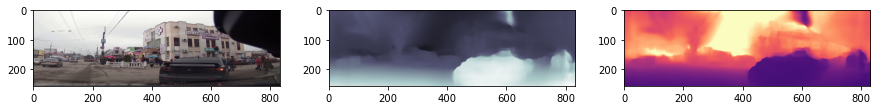

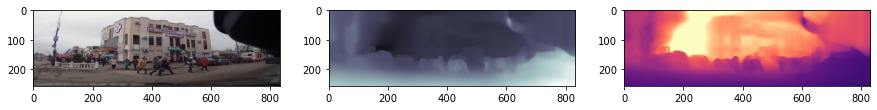

In [45]:
import torch

from imageio import imread, imsave
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt

import numpy as np
# from path import Path
import argparse
from tqdm import tqdm

from models import DispResNet
from utils2 import tensor2array

# parser = argparse.ArgumentParser(description='Inference script for DispNet learned with \
#                                  Structure from Motion Learner inference on KITTI Dataset',
#                                  formatter_class=argparse.ArgumentDefaultsHelpFormatter)
# parser.add_argument("--output-disp", action='store_true', help="save disparity img")
# parser.add_argument("--output-depth", action='store_true', help="save depth img")
# parser.add_argument("--pretrained", required=True, type=str, help="pretrained DispResNet path")
# parser.add_argument("--img-height", default=256, type=int, help="Image height")
# parser.add_argument("--img-width", default=832, type=int, help="Image width")
# parser.add_argument("--no-resize", action='store_true', help="no resizing is done")

# parser.add_argument("--dataset-list", default=None, type=str, help="Dataset list file")
# parser.add_argument("--dataset-dir", default='.', type=str, help="Dataset directory")
# parser.add_argument("--output-dir", default='output', type=str, help="Output directory")
# parser.add_argument("--img-exts", default=['png', 'jpg', 'bmp'], nargs='*', type=str, help="images extensions to glob")
# parser.add_argument('--resnet-layers', required=True, type=int, default=18, choices=[18, 50],
#                     help='depth network architecture.')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
img_height=256
img_width=832
img_exts=['png', 'jpg', 'bmp']
dataset_dir='image'
resnet_layers=18
output_dir='results/'
pretrained='checkpoints/resnet18_depth_256/dispnet_model_best.pth.tar'

with torch.no_grad():

    # args = parser.parse_args()
    # if not(args.output_disp or args.output_depth):
    #     print('You must at least output one value !')
    #     return

    disp_net = DispResNet(resnet_layers, False).to(device)
    weights = torch.load(pretrained)
    disp_net.load_state_dict(weights['state_dict'])
    disp_net.eval()

#     dataset_dir = Path(dataset_dir)
#     output_dir = Path(output_dir)
#     output_dir.makedirs_p()

#     test_files = sum([dataset_dir.files('*.{}'.format(ext)) for ext in img_exts], [])
    test_files=['./image/00078.png','./image/00234.png']
    print('{} files to test'.format(len(test_files)))

    for file in tqdm(test_files):

        img = imread(file).astype(np.float32)

        h, w, _ = img.shape
       
        img = imresize(img, (img_height, img_width)).astype(np.float32)
        
        fig = plt.figure(figsize=(15, 15))
        a = fig.add_subplot(1, 3, 1)
        imgplot = plt.imshow(img.astype(np.uint8))

        img = np.transpose(img, (2, 0, 1))

        tensor_img = torch.from_numpy(img).unsqueeze(0)
        tensor_img = ((tensor_img/255 - 0.45)/0.225).to(device)

        output = disp_net(tensor_img)[0]

        
        disp = (255*tensor2array(output, max_value=None, colormap='bone')).astype(np.uint8)

        
        depth = 1/output
        depth = (255*tensor2array(depth, max_value=1, colormap='magma')).astype(np.uint8)

        
        
        a = fig.add_subplot(1, 3, 2)
        imgplot = plt.imshow(np.transpose(disp,(1,2,0)))
        a = fig.add_subplot(1, 3, 3)
        imgplot = plt.imshow(np.transpose(depth,(1,2,0)))

      
     
        imsave(file.replace(".png","_disp.png"), np.transpose(disp, (1, 2, 0)))
        imsave(file.replace(".png","_depth.png"), np.transpose(depth, (1, 2, 0)))
       

